# ENVIRONMENT

In [1]:
! pip install pmdarima pandoc nbconvert

In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import statsmodels.api as sm
from IPython.core.interactiveshell import InteractiveShell
from scipy import signal, stats
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf

InteractiveShell.ast_node_interactivity = "all"

# suppress scientific notation in Pandas
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("precision", 3)
pd.set_option("display.max_colwidth", None)

plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.dpi"] = 150

sns.set()
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")

import warnings

warnings.filterwarnings("ignore")

RANDOM_STATE = 1

original_df = pd.read_csv("./src/churn/teleco_time_series.csv")
df = original_df.copy()


# Introduction 

In the telecom munications industry, customers can choose from multiple service providers and actively switch from one provider to another. Customer churn is defined as the percentage of customers who stopped using a provider’s product or service during a certain time frame. In this highly competitive market, some telecommunications industries can experience average annual churn rates as high as 25 Given that it costs 10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many providers retaining highly profitable customers is the number one business goal. To reduce customer churn, telecom munications companies need to predict which customers are at high risk of churn.

As part of the “churn” project, executives would like to see consider a time series on revenue from the first years of operation. Once they understand any patterns in that data, they feel confident in understanding the impact of churn in current times. The given time series data records the daily revenue, in million dollars, during the first two years of operation.

**Data File being used:**
teleco_time_series.csv

**Data Dictionary:**
- The data set consists of 731 rows and two columns:
    - Day Day during first two years of operation
    - Revenue Revenue in million dollars
    
Review the data dictionary and considerations related to the raw data file you have chosen and prepare the data for time series modeling. You will then analyze that data set using time series modeling, create visualizations, generate forecasts, and deliver the results of your analysis.

1. ✅ Import the initial dataset into a data frame.
0. ✅ Clean the data.
0. ✅ Difference the data set to coerce stationarity and save it.
0. ✅ Split the clean data into training and test sets (80%  training and 20% test).
0. Perform spectral density to see the periodicities.
0. Perform acf / pacf on train dataset to confirm stationarity.
    - One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF).
        - the number of significant lags for the PACF indicate the order of the AR model
0. Decompose the clean data to see components of the Time Series.
0. Plot the trend, seasonal, and residual components individually.
0. Perform AIC to pick the best order of ARIMA.
    - Another tool to identify the order of a model is to look at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These measures compute the goodness of fit with the estimated parameters, but apply a penalty function on the number of parameters in the model.
    - In practice, the way to use the information criteria is to fit several models, each with a different number of parameters, and choose the one with the lowest Bayesian information criterion.
    - create a plot with different AR models and their AIC and BIC
0. Create and fit ARMA(p, q) model using SARIMAX and the model order from AIC
    - An ARMA model is a combination of an AR and MA model. Here is the formula for an ARMA(1,1) model, which has the familiar AR(1) and MA(1) components. ARMA models can be converted to pure AR or pure MA models.
    - autoregressive models: AR(p)
    - moving average models: MA(q)
    - mixed autoregressive moving average models: ARMA(p, q)
    - integration models: ARIMA(p, d, q)
    - seasonal models: SARIMA(P, D, Q, s)
    
    
0. Use auto_arima on train_df
0. Fit ARIMA model using hyper-parameters from auto_arima and the training dataset.  
0. Create the time series model using SARIMAX with the model order from AIC.
0. Predict with the test set.
0. Perform forecast on the training set.
0. Validate with test set.
0. Save the model.


#### Comparison of PACF for Different AR Models
1. Choosing the Right Model
In practice, you will ordinarily not be told the order of the model that you're trying to estimate.

2. Identifying the Order of an AR Model
There are two techniques that can help determine the order of the AR model: The Partial Autocorrelation Function, and the Information Criteria

3. Partial Autocorrelation Function (PACF)
The Partial Autocorrelation Function measures the incremental benefit of adding another lag. Imagine running several regressions, where you regress returns on more and more lagged values. The coefficients in the red boxes represent the values of the partial autocorrelation function for different lags. For example, in the bottom row, the coefficient in the red box, phi 4-4, is the lag-4 value of the Partial Autocorrelation Function, and it represents how significant adding a fourth lag is when you already have three lags.

4. Plot PACF in Python
plot_pacf is the statsmodels function for plotting the partial autocorrelation function. The arguments are the same as that of the plot_acf module that you saw earlier. The input x is a series or array. The argument lags indicates how many lags of the parital autocorrelation function will be plotted. And the alpha argument sets the width of the confidence interval.

5. Comparison of PACF for Different AR Models
These plots show the Partial Autocorrelation Function for AR models of different orders. In the upper left, for an AR(1) model, only the lag-*1* PACF is significantly different from zero. Similarly, for an AR(2) model, two lags are different from zero, and for and AR(3), three lags are different from zero. Finally, for White Noise, there are no lags that are significantly different from zero.

6. Information Criteria
The more parameters in a model, the better the model will fit the data. But this can lead to overfitting of the data. The information criteria adjusts the goodness-of-fit of a model by imposing a penalty based on the number of parameters used. Two common adjusted goodness-of-fit measures are called the Akaike Information Criterion and the Bayesian Information Criterion.

7. Information Criteria
This is the full output from estimating an AR(2) model. The AIC and BIC are highlighted in the red box. To get the AIC and BIC statistics,

8. Getting Information Criteria From `statsmodels`
you follow the same procedure from the last section to fit the data to a model. In the last section, you learned how to get the full output using summary or just the AR parameters using the params attribute. You can also get the AIC or BIC using those attributes. In practice, the way to use the information criteria is to fit several models, each with a different number of parameters, and choose the one with the lowest Bayesian information criterion.

9. Information Criteria
Suppose we are given a time series of data, and unknown to us, it was simulated from an AR(3) model. Here is a plot of the BIC when we fit the data to an AR(1) up to an AR(8) model. You can see that the lowest BIC occurs for an AR(3).

In [3]:
m = pm.auto_arima(y=original_df.Revenue)
m
m.summary()


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -488.561
Date:                Tue, 20 Sep 2022   AIC                            983.122
Time:                        23:53:29   BIC                            996.901
Sample:                             0   HQIC                           988.438
                                - 731                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0332      0.018      1.895      0.058      -0.001       0.068
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.000       0.199       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Part 0: Data Exploration

In [51]:
original_df.shape
original_df.head()


(731, 2)

Day  Revenue
0    1     0.00
1    2     0.00
2    3     0.83
3    4     0.32
4    5     1.08

In [5]:
original_df.describe()


Day  Revenue
count 731.00   731.00
mean  366.00     9.82
std   211.17     3.85
min     1.00     0.00
25%   183.50     6.87
50%   366.00    10.79
75%   548.50    12.57
max   731.00    18.15

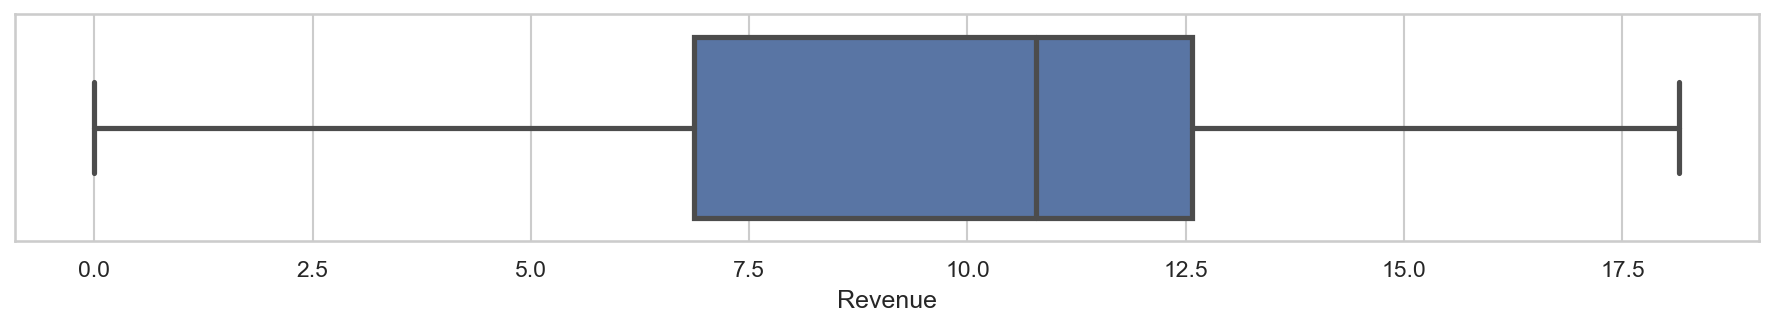

In [6]:
fig, axs = plt.subplots(ncols=1, figsize=(15, 2))
ax = sns.boxplot(original_df.Revenue)
plt.show()


[Text(0.5, 1.0, 'Revenue')]

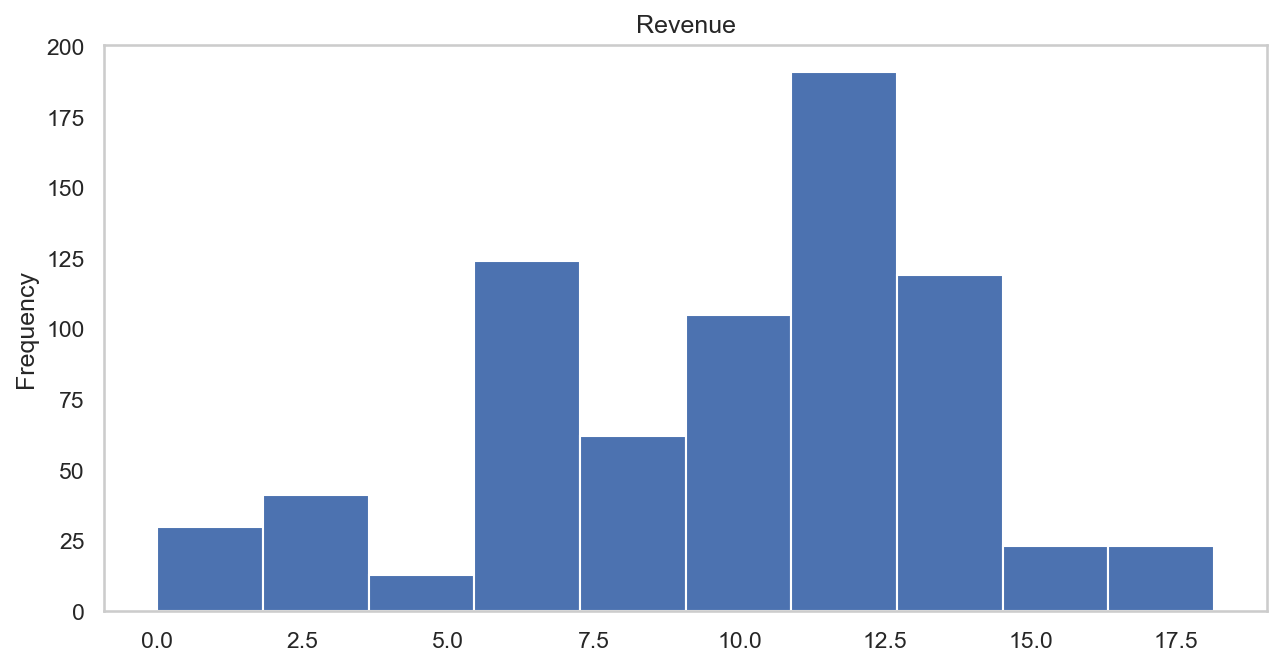

In [54]:
ax = original_df.Revenue.plot.hist()
ax.set(title="Revenue")
ax.grid(False)
plt.show()


In [9]:
# splitting dataset in two reveals the halves have a different mean and variance
X = prep_df.Revenue
split = round(len(X) / 2)
split

pd.DataFrame(
    [
        {
            **prep_df.iloc[:split, :].Revenue.describe(),
            "variance": prep_df.iloc[:split, :].Revenue.var(),
        },
        {
            **prep_df.iloc[split:, :].Revenue.describe(),
            "variance": prep_df.iloc[split:, :].Revenue.var(),
        },
    ],
    index=["Partition 1", "Partition 2"],
)


366

count  mean  std  min   25%   50%   75%   max  variance
Partition 1 366.00  6.81 2.95 0.00  5.63  6.87  9.23 12.44      8.68
Partition 2 365.00 12.84 1.68 9.80 11.83 12.57 13.63 18.15      2.83

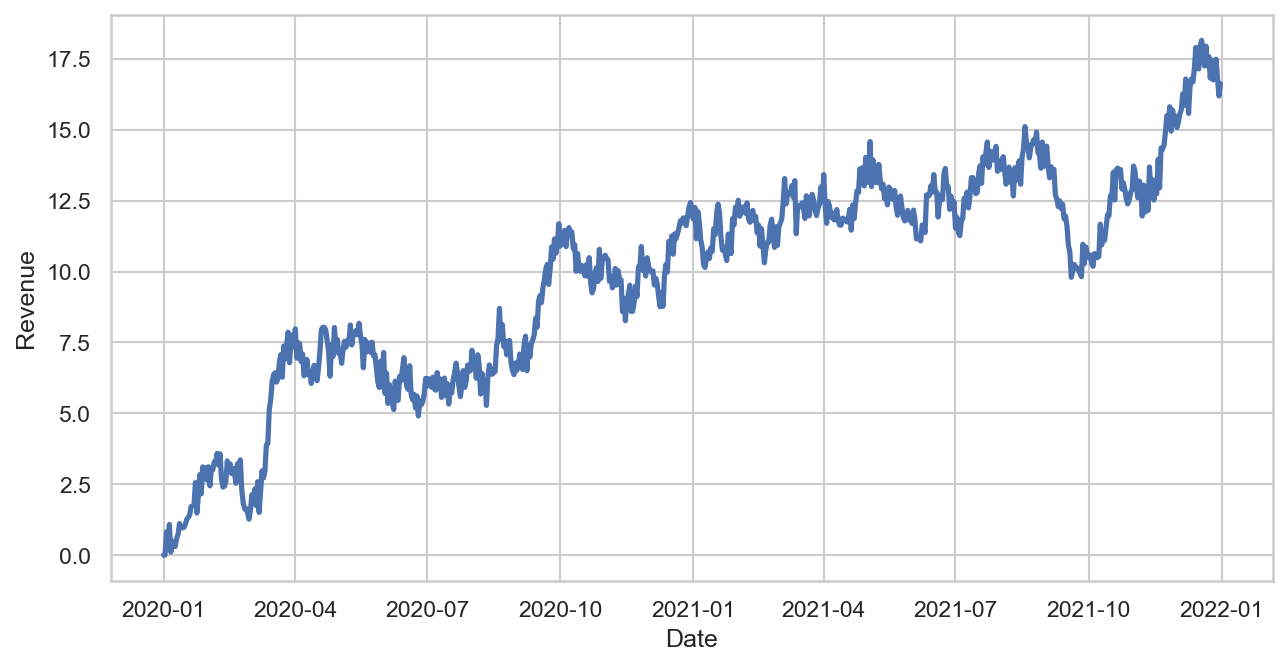

In [10]:
ax = sns.lineplot(data=prep_df.reset_index(), x="Date", y="Revenue")


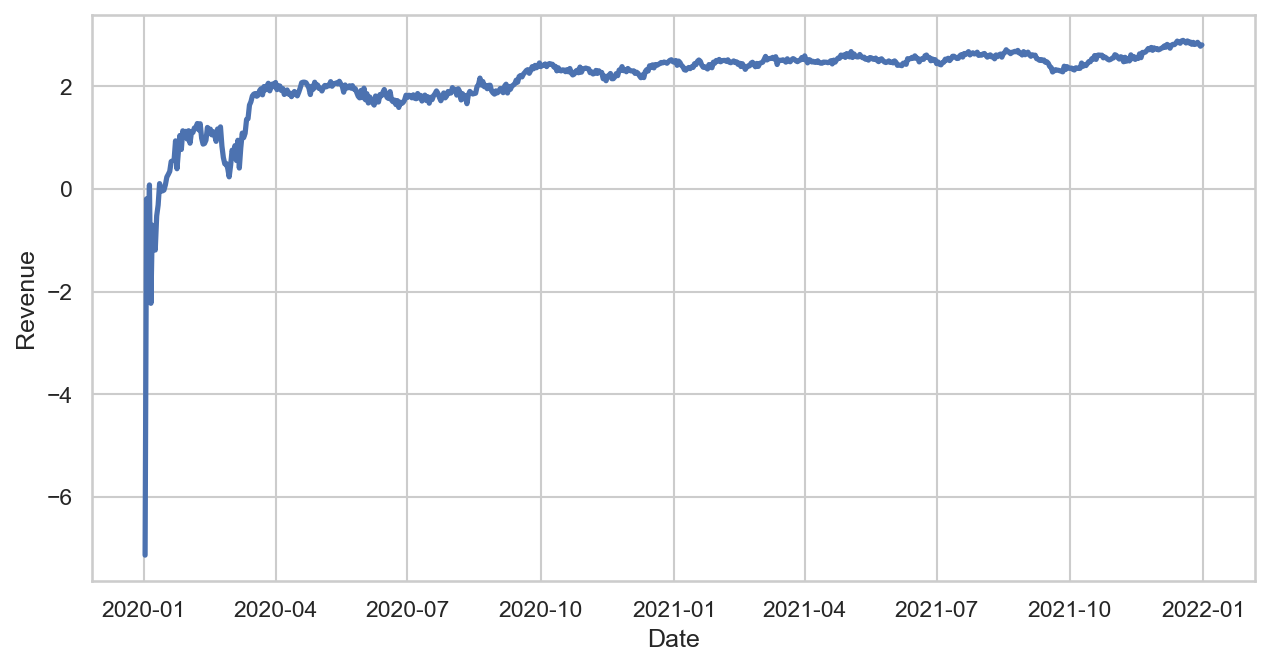

In [11]:
ax = sns.lineplot(data=np.log(prep_df), x="Date", y="Revenue")


Revenue  Rolling Mean  Rolling Std.  Rolling Variance  Diff  \
Date                                                                      
2020-01-01     0.00           NaN           NaN               NaN   NaN   
2020-01-02     0.00           NaN           NaN               NaN  0.00   
2020-01-03     0.83           NaN           NaN               NaN  0.82   
2020-01-04     0.32           NaN           NaN               NaN -0.51   
2020-01-05     1.08           NaN           NaN               NaN  0.76   

            Pct Change  
Date                    
2020-01-01         NaN  
2020-01-02         inf  
2020-01-03     1039.79  
2020-01-04       -0.61  
2020-01-05        2.38

<Figure size 1500x750 with 0 Axes>

Text(0.5, 1.0, 'Revenue Chart')

Text(0.5, 0, 'Day')

Text(0, 0.5, 'Revenue (in Millions USD)')

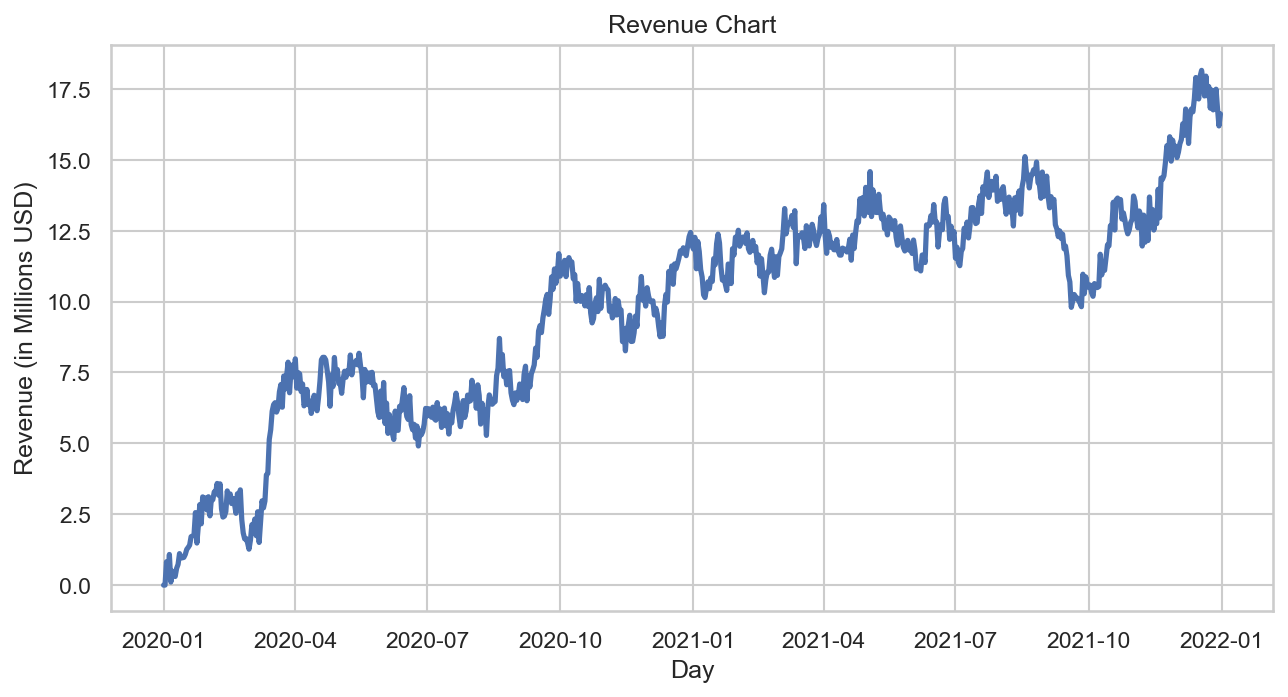

In [12]:
prep_df["Date"] = pd.date_range(
    start=datetime(2020, 1, 1), periods=len(original_df), freq="24H"
)

# Set the Date as an index
prep_df.set_index("Date", inplace=True)

prep_df.head(5)

plt.figure(figsize=(10, 5))
plt.plot(prep_df.Revenue)
plt.title("Revenue Chart")
plt.xlabel("Day")
plt.ylabel("Revenue (in Millions USD)")
plt.grid(True)
plt.show()


#### SARIMAX

In [13]:
### SARIMAX
# Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model


# The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).


#### Differencing

<AxesSubplot:xlabel='Date'>

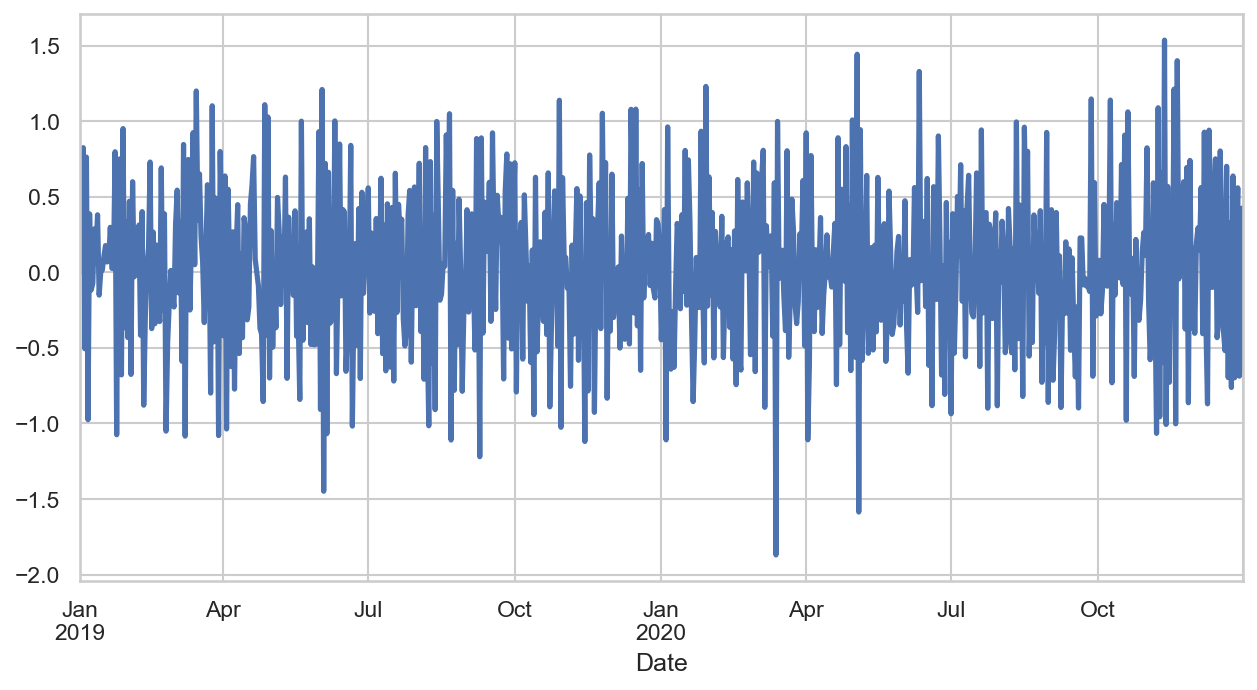

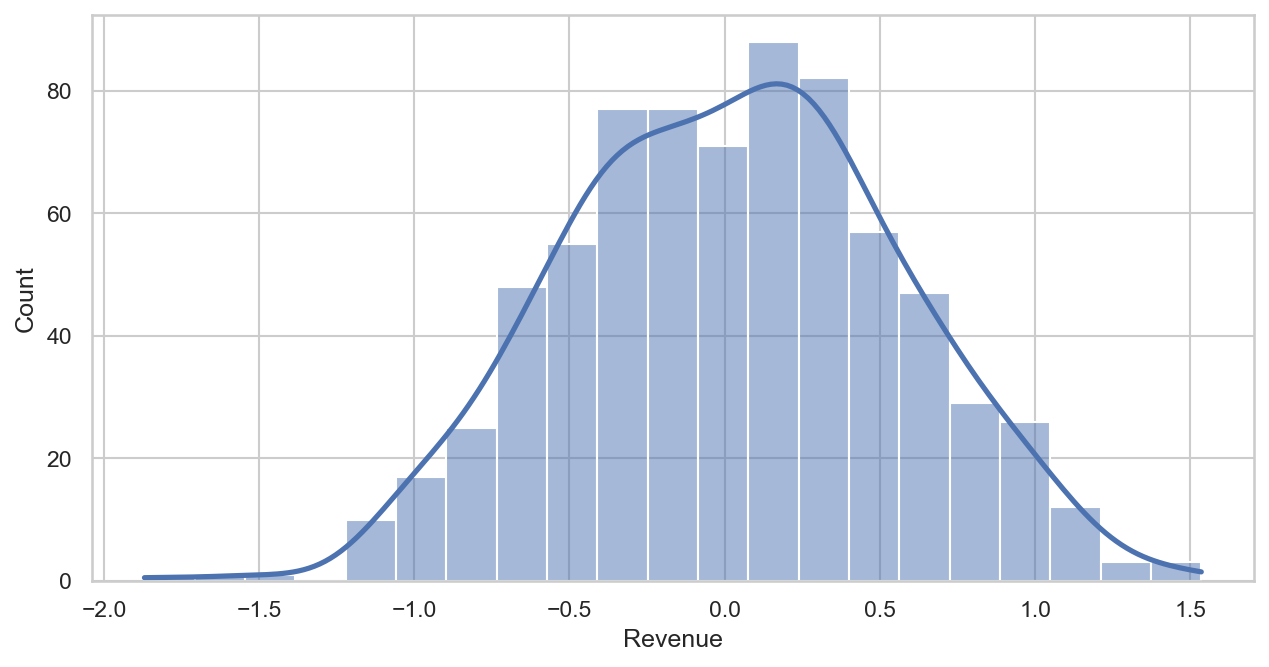

<AxesSubplot:xlabel='Date'>

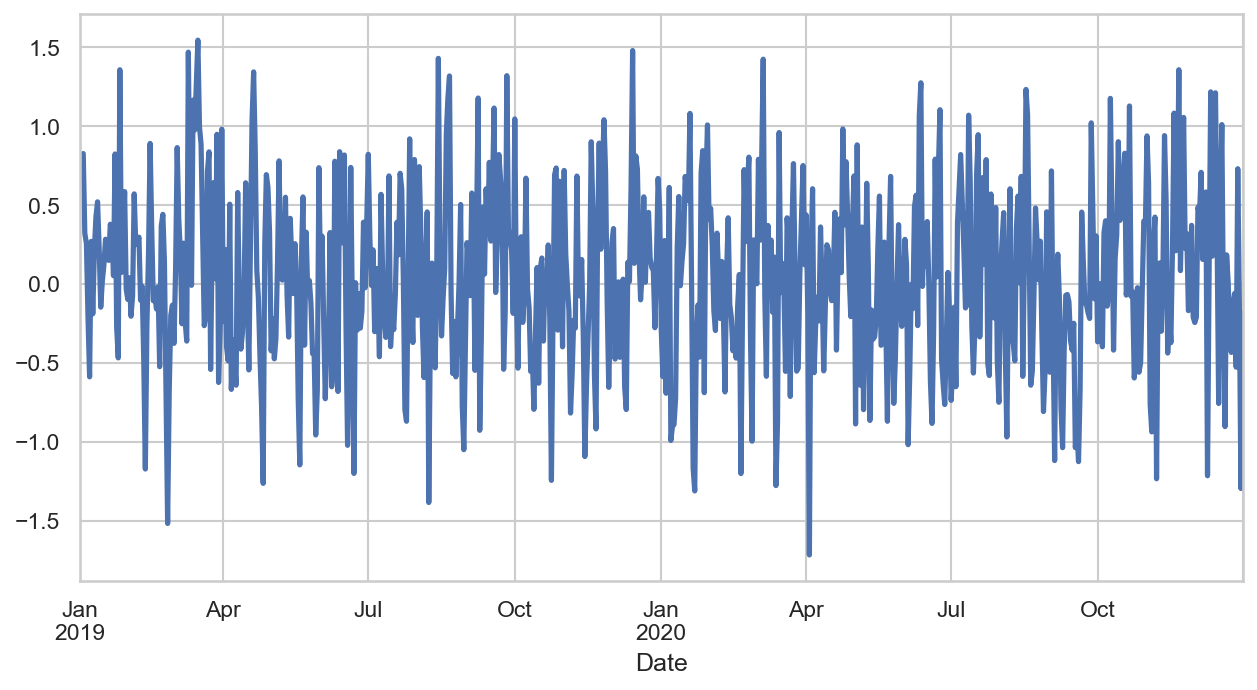

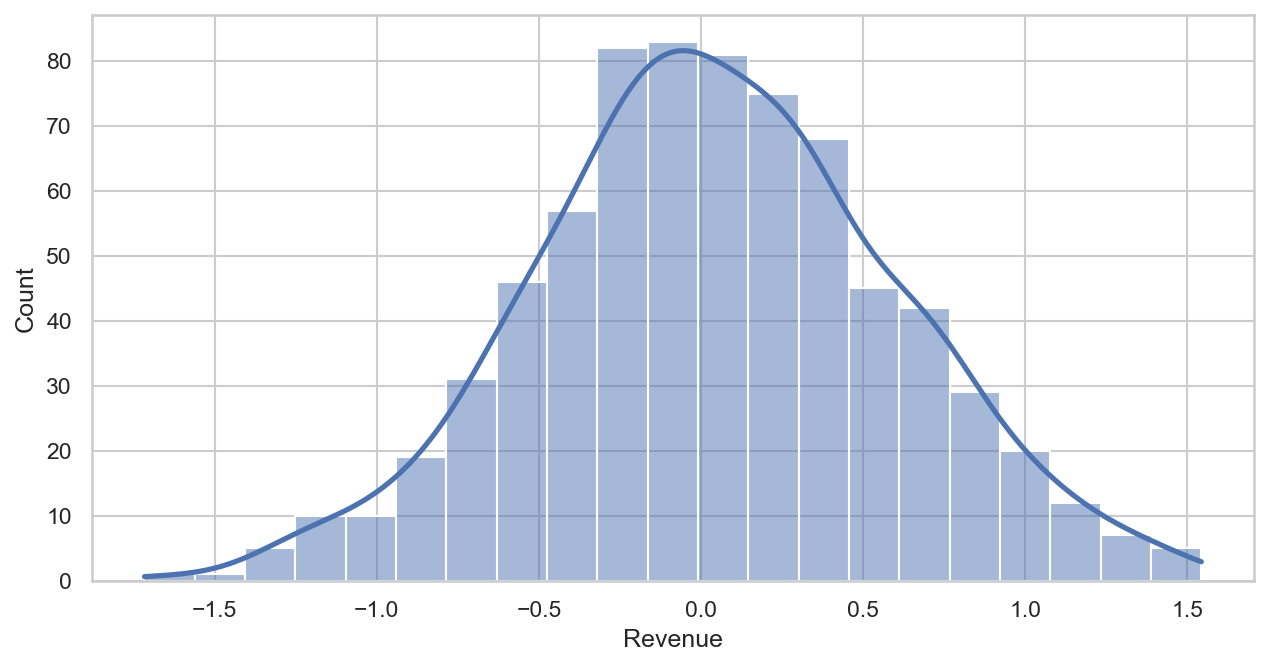

<AxesSubplot:xlabel='Date'>

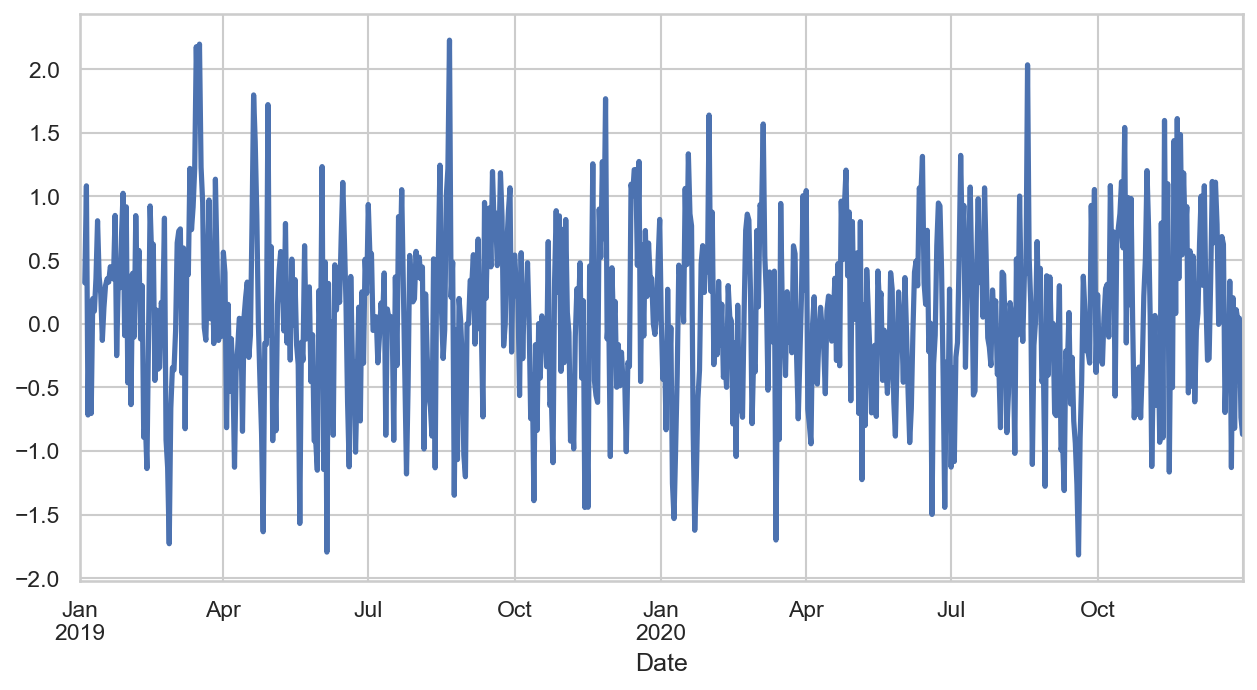

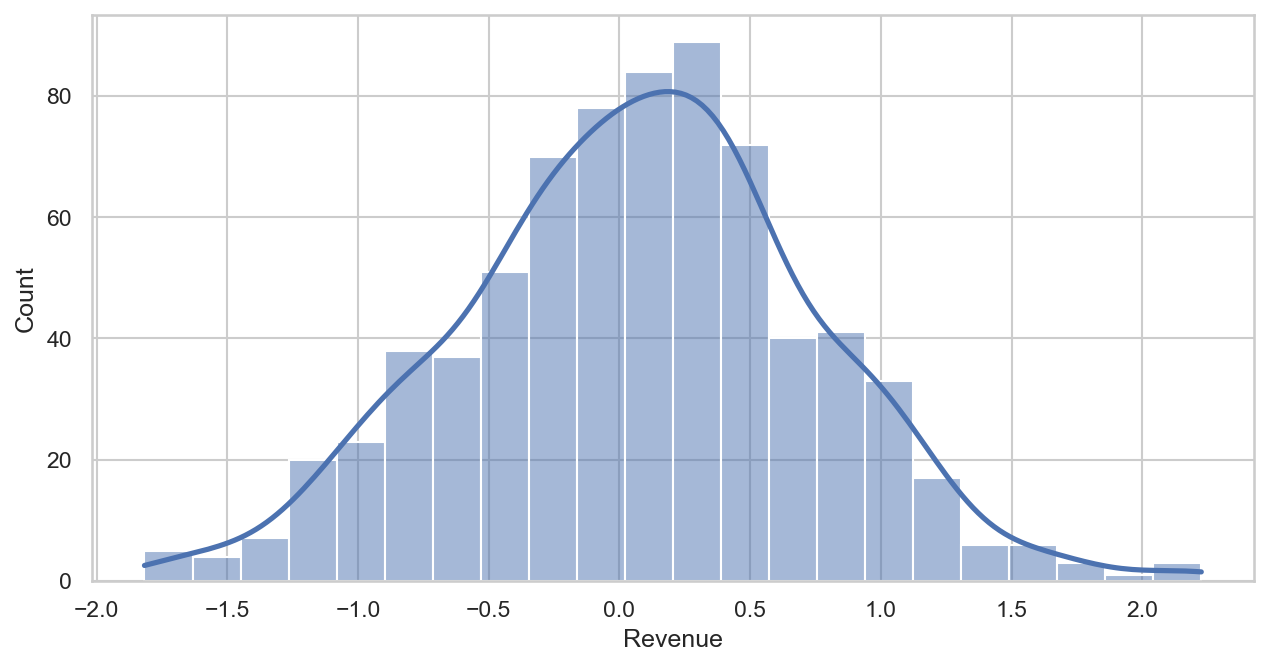

In [61]:

# In Figure 8.1, note that the Google stock price was non-stationary in panel (a), but the daily changes were stationary in panel (b). This shows one way to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

for x in [1,2,3]:
    prep_df.Revenue.diff(periods=x).plot()
    plt.show()

    _ = sns.histplot(prep_df.Revenue.diff(periods=x), kde=True)
    plt.show()


#### ACF Plots

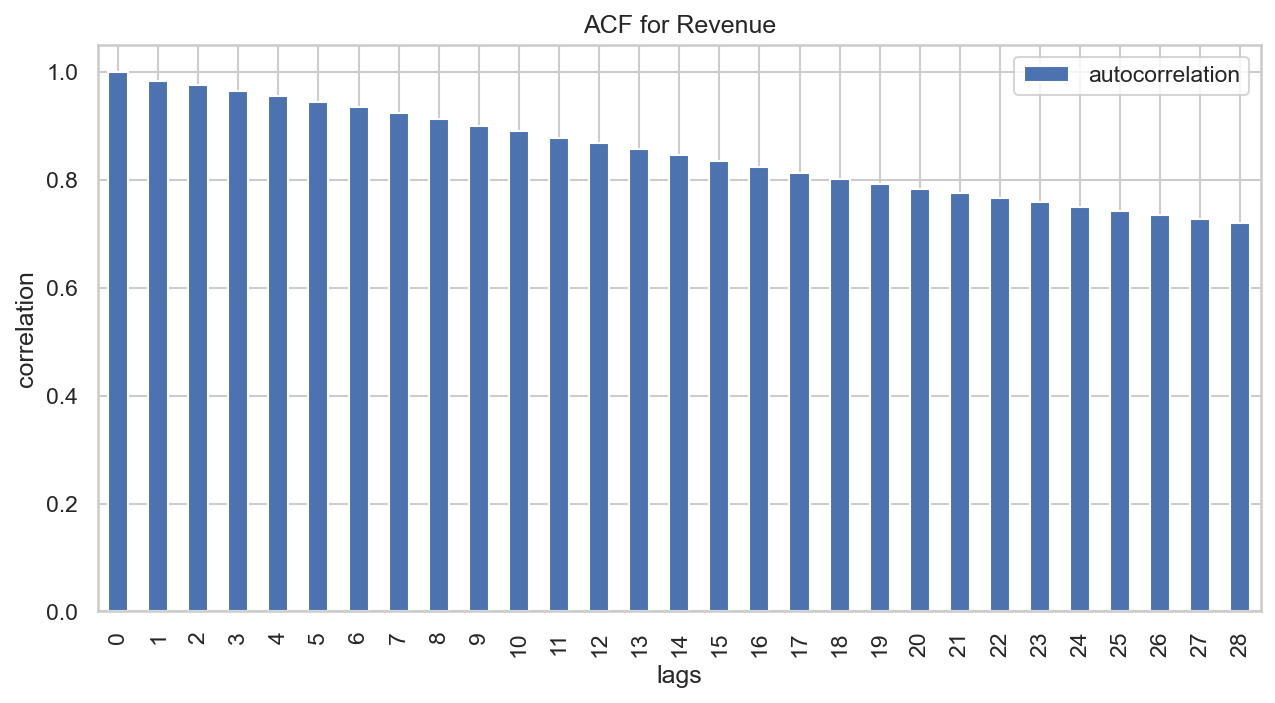

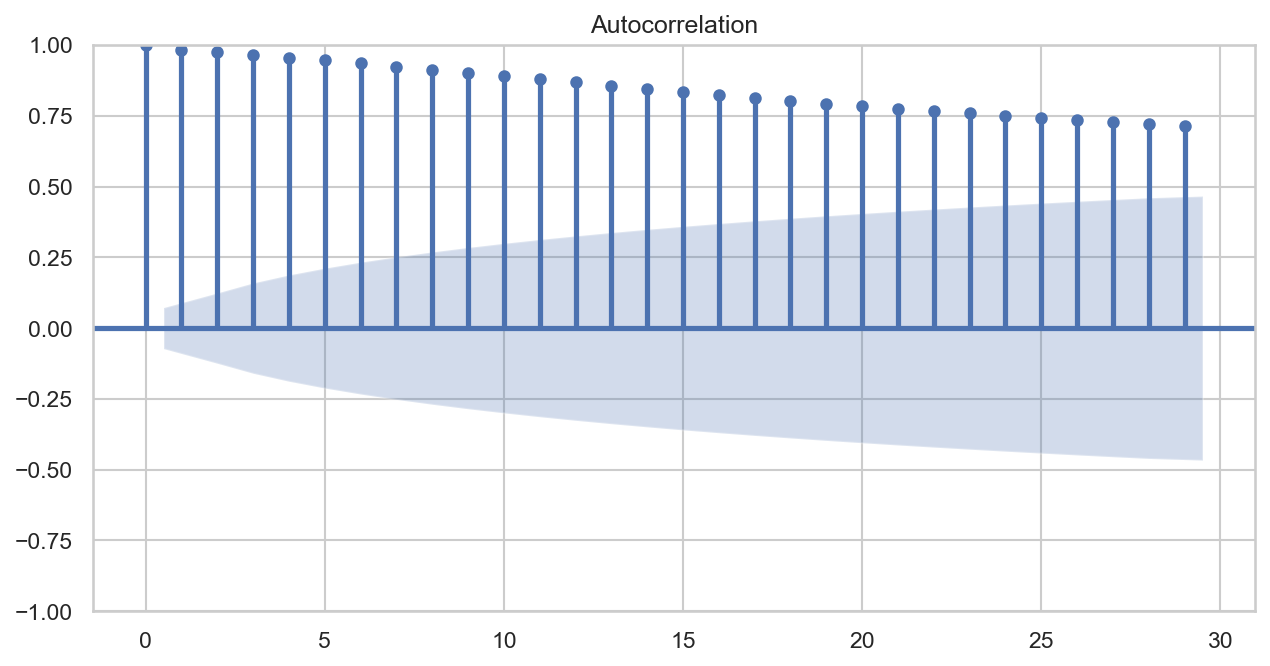

In [17]:
# The autocorrelation function.
# Compute the array of autocorrelations

ax = pd.DataFrame(acf(original_df.Revenue), columns=["autocorrelation"]).plot(
    kind="bar", xlabel="lags", ylabel="correlation"
)
_ = ax.set(title="ACF for Revenue")

plt.show()

# the autocorrelation of MSFT's weekly stock returns was -0.16. That autocorrelation seems large, but is it statistically significant? In other words, can you say that there is less than a 5% chance that we would observe such a large negative autocorrelation if the true autocorrelation were really zero? And are there any autocorrelations at other lags that are significantly different from zero?


# Plot the autocorrelation function of
# if alpha equals 0.05, that means that if the true autocorrelation at that lag is zero, there is only a 5% chance the sample autocorrelation will fall outside that window.

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
ax = plot_acf(x=original_df.Revenue)


#### PACF Plot

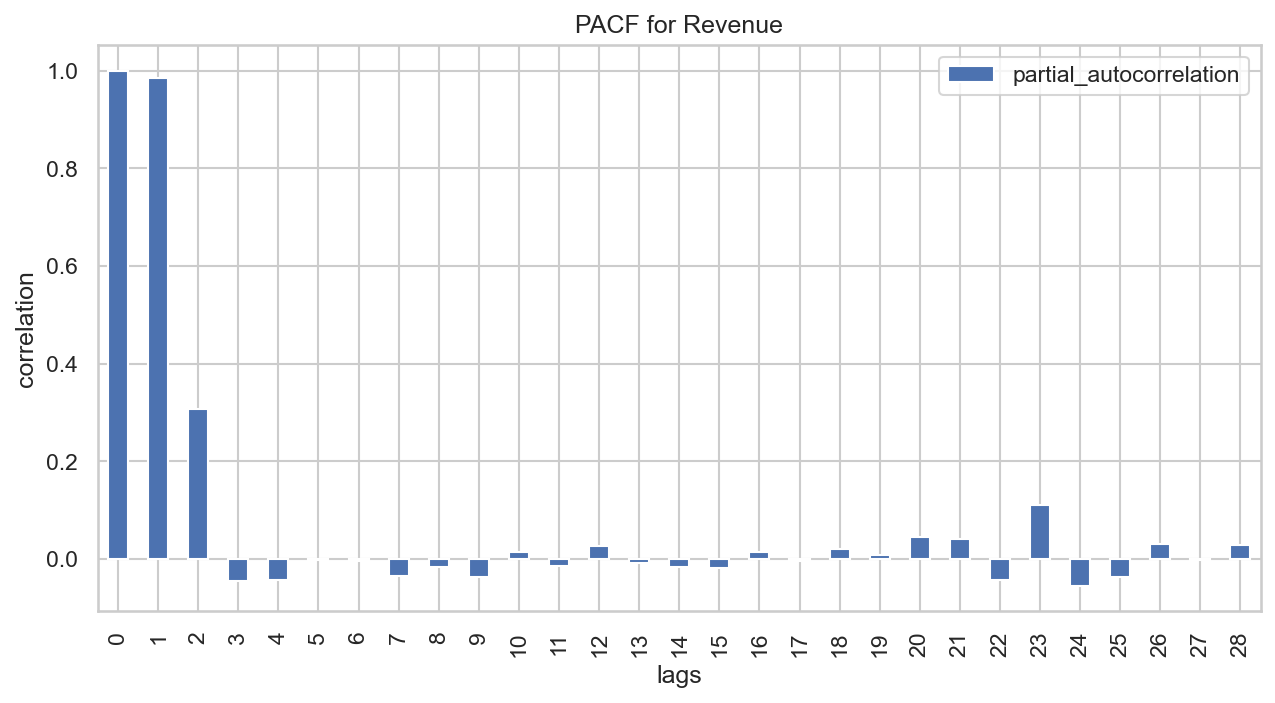

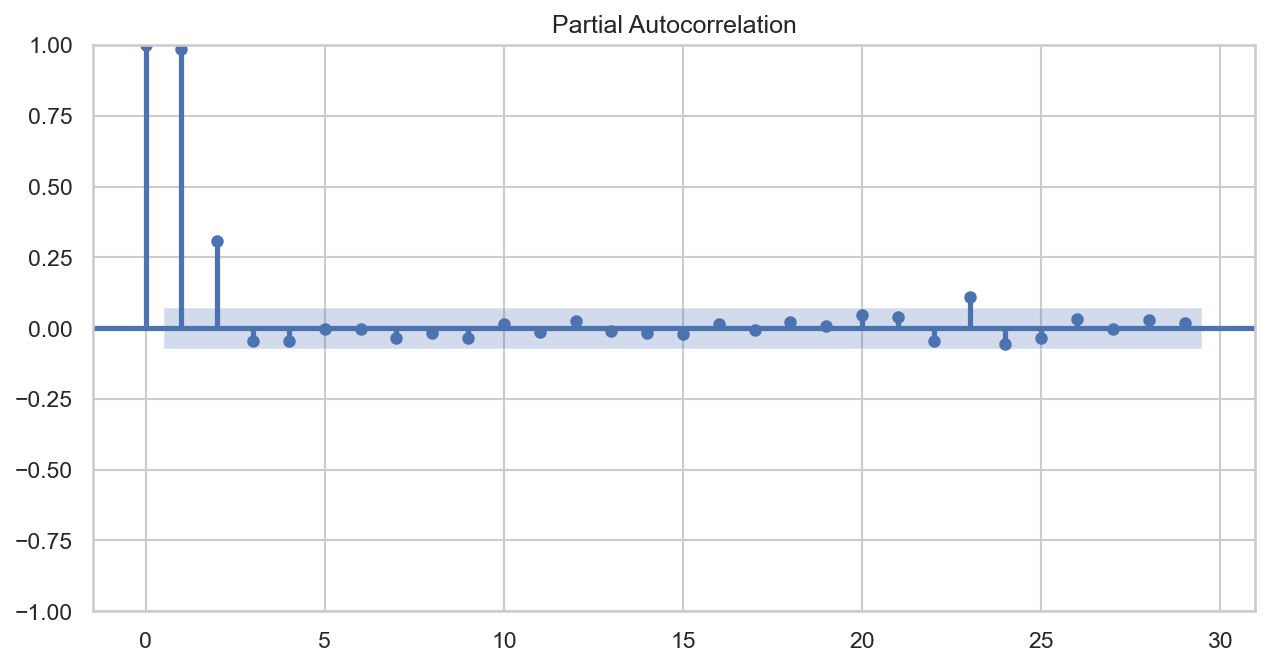

In [18]:
ax = pd.DataFrame(pacf(original_df.Revenue), columns=["partial_autocorrelation"]).plot(
    kind="bar", xlabel="lags", ylabel="correlation"
)

_ = ax.set(title="PACF for Revenue")

ax = plot_pacf(x=original_df.Revenue)


#### ADF

In [19]:
# Augmented Dickey-Fuller test
# use a statistical test designed to explicitly comment on whether a univariate time series is stationary.
# The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

# """
# Augmented Dickey-Fuller test
# Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

# Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

# The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

# The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

# There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

# The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

# Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
# Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
# We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
# """

# Notes

# The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

# The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

# 1. Random Walk
# In a random walk, today's price is equal to yesterday's price plus some noise. The change in price of a random walk is just White Noise. Incidentally, if prices are in logs, then the difference in log prices is one way to measure returns. The bottom line is that if stock *prices* follow a random walk, then stock *returns* are White Noise. You can't forecast a random walk. The best guess for tomorrow's price is simply today's price. In a random walk with drift, prices on average drift by mu every period. And the change in price for a random walk with drift is still white noise but with a mean of mu. So if we now think of stock prices as a random walk with drift, then the returns are still white noise, but with an average return of mu instead of zero.

# 5. Statistical Test for Random Walk
# To test whether a series like stock prices follows a random walk, you can regress current prices on lagged prices. If the slope coefficient, beta, is not significantly different from one, then we cannot reject the null hypothesis that the series is a random walk. However, if the slope coefficient is significantly less than one, then we can reject the null hypothesis that the series is a random walk. An identical way to do that test is to regress the difference in prices on the lagged price, and instead of testing whether the slope coefficient is 1, now we test whether it is zero.

# 7. Statistical Test for Random Walk
# This is called the "Dickey-Fuller" test. If you add more lagged prices on the right hand side, then it's called the Augmented Dickey-Fuller test.

# 8. ADF Test in Python
# statsmodels has a function, adfuller, for performing the Augmented Dickey-Fuller test.

# 9. Example: Is the S&P500 a Random Walk?
# As an example, let's run the Augmented Dickey-Fuller test on a time series of S&P500 prices using the adfuller function. The results are stored in results. The main output we're interested in is the p-value of the test. If the p-value is less than 5%, we can reject the null hypothesis that the series is a random walk with 95% confidence. In this case, the p-value is much higher than 0.05 - it's 0.32. Therefore, we cannot reject the null hypothesis that the S&P500 is a random walk. You can also print out the full output of the test, which gives other information, like the number of observations (1257), the test statistic (-point-917) and the critical values of the test statistic for various alphas - 1%, 10%, and 5%.


Running the example prints the ADF test statistic value of -1.9. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -1.9 is greater than the value of -3.4 at 1%.

This suggests that we fail to reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Failing to reject the null hypothesis means that the process has a unit root, and in turn that the time series is non-stationary or has a time-dependent structure.

shows a negative value for the test statistic.

We can see that the value is larger than the critical values, again, meaning that we can fail to reject the null hypothesis and in turn that the time series is non-stationary.

# ✅ Part I:  Research Question
## A.  Describe the purpose of this data analysis by doing the following:disp=

### ✅ 1.  Summarize one research question that is relevant to a real-world organizational situation captured in the selected data set and that you will answer using time series modeling techniques.

> The latest U.S. economic forecasts, heightened interests rate, and negative public sentiment surrounding the global economy and a potential recession have caught the attention of many executive teams. At Goldfield & Banks, an telecommunications company, the leadership team typically has a 12-month forward-looking revenue forecast provided by the CFO. However, with the economic uncertainty, the leadership team would like projections further in the future. Ultimately, the leadership team wants to know if the CFO and analysts can provide revenue projections for the next 18 months.

### ✅ 2.  Define the objectives or goals of the data analysis. Ensure that your objectives or goals are reasonable within the scope of the scenario and are represented in the available data.

> The data analysis objective is to utilize time series modeling to build a predictive model that can forecast quarterly revenue for the next 18 months.

# ✅ Part II:  Method Justification

## ✅ B.  Summarize the assumptions of a time series model including stationarity and autocorrelated data.

> There are several assumptions about time series modeling, especially concerning stationarity and autocorrelated data. First, we assume that the data is stationary. Ultimately this term describes the fact that the distribution of the observations do not depend on time. More specifically, this indicates that the data follows a normal distribution and has a consistent mean, variance and autocorrelation (Sematech, Sangarshanan, 2018). Autocorrelation describes each values relation to its neighbors in the series. For a time series to be stationary, data observation relationships should be consistent throughout the series. Furthermore, the series cannot contain increasing or decreasing data trends. Lastly, the data should be free of outliers which would skew the model's results (Statistics Solutions, 2021).


Time Series Assumptions
1. The time series data should be stationary. It means the series is normally distributed and the mean and variance are constant over that period of time. The series has zero trends, it is not growing or shrinking. The variance is constant. The autocorrelation is constant (Datacamp, n.d).
2. The error term is randomly distributed, and the mean and the variance are constant over a time period. The error in time series analysis is assumed to be uncorrelated.
3. There should be no outliers in the series. Outliers could lead to inaccurate results (Statistics Solutions, 2021).
4. The residuals aren’t autocorrelated. 


Stationarity: is an assumption in Time Series that that the mean, variance and autocorrelation structure do not change over time (Sematech, Sangarshanan, 2018). It means that the distribution of the data does not change with time. For Time Series to be stationary it must fulfill these three criteria: 
1)	The series has zero trends, it is not growing or shrinking.
2)	The variance is constant.
The autocorrelation is constant. How each value in the time series is related to its neighbors stay the same (Datacamp, n.d).

---
1. Stationarity
There are different ways to define stationarity,

2. What is Stationarity?
but in its strictest sense, it means that the joint distribution of the observations do not depend on time. A less restrictive version of stationarity, and one that is easier to test, is weak stationarity, which just means that the mean, variance, and autocorrelations of the observations do not depend on time. In other words, for the autocorrelation, the correlation between X-t and X-(t-tau) is only a function of the lag tau, and not a function of time.

3. Why Do We Care?
If a process is not stationary, then it becomes difficult to model. Modeling involves estimating a set of parameters, and if a process is not stationary, and the parameters are different at each point in time, then there are too many parameters to estimate. You may end up having more parameters than actual data! So stationarity is necessary for a parsimonious model, one with a smaller set of parameters to estimate.

4. Examples of Nonstationary Series
A random walk is a common type of non-stationary series. The variance grows with time. For example, if stock prices are a random walk, then the uncertainty about prices tomorrow is much less than the uncertainty 10 years from now.

5. Examples of Nonstationary Series
Seasonal series are also non-stationary. Here is the dataset you saw earlier on the frequency of Google searches for the word 'diet'. The mean varies with the time of the year.

6. Examples of Nonstationary Series
Here is White Noise, which would ordinarily be a stationary process, but here the mean increases over time, which makes it non-stationary.

7. Transforming Nonstationary Series Into Stationary Series
Many non-stationary series can be made stationary through a simple transformation. A Random Walk is a non-stationary series, but if you take the first differences, the new series is White Noise, which is stationary. On the left are S&P500 prices, which is a non-stationary random walk, but if you compute first differences on the right, it becomes a stationary white noise process.

8. Transforming Nonstationary Series Into Stationary Series
On the left, we have the quarterly earnings for H&R Block, which has a large seasonal component and is therefore not stationary. If we take the seasonal difference, by taking the difference with lag of 4, the transformed series looks stationary.

9. Transforming Nonstationary Series Into Stationary Series
Sometimes, you may need to make two transformations. Here is a time series of Amazon's quarterly revenue. It is growing exponentially as well as exhibiting a strong seasonal pattern. First, if you take only the log of the series, in the upper right, you eliminate the exponential growth. But if you take both the log of the series and then the seasonal difference, in the lower right, the transformed series looks stationary.

Seasonal Adjustment During Tax Season
Many time series exhibit strong seasonal behavior. The procedure for removing the seasonal component of a time series is called seasonal adjustment. For example, most economic data published by the government is seasonally adjusted.


# Part III:  Data Preparation
## C.  Summarize the data cleaning process by doing the following:

In [20]:
prep_df = original_df.copy()


### ✅ 1.  Provide a line graph visualizing the realization of the time series.

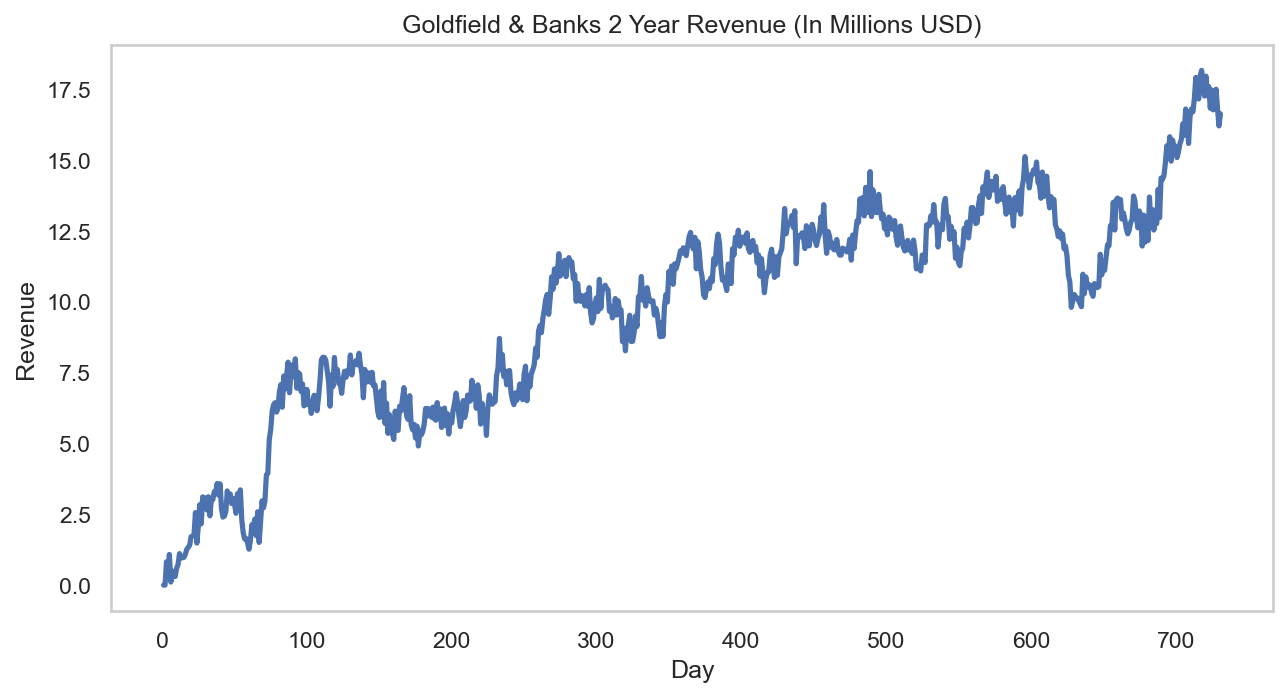

In [21]:
ax = sns.lineplot(data=prep_df, x="Day", y="Revenue")
plt.grid(b=False)
_ = ax.set(title="Goldfield & Banks 2 Year Revenue (In Millions USD)")



### ✅ 2.  Describe the time step formatting of the realization, including any gaps in measurement and the length of the sequence.

> The time series representation measures the company data for the last 2 years. The time step is one day and the data series consists of 731 data points — each data point represents a day. No data gaps or missing days were detected.

> After data preparation, the results show there are no null, NaN, or duplicate values in the dataframe.

In [22]:
# step: Show dimensions, structure, missing data, and sample data
original_df.info()
original_df.shape
# Check for NA values in data set
original_df.isna().sum()
# Check for duplicates
original_df.duplicated().sum()
original_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


(731, 2)

Day        0
Revenue    0
dtype: int64

0

Day  Revenue
0    1     0.00
1    2     0.00
2    3     0.83
3    4     0.32
4    5     1.08

In [23]:
def missing_val_summary(df):
    return pd.DataFrame(
        {
            "# missing values": df.isna().sum(),
            "% missing values": (df.isna().sum() / len(prep_df)) * 100,
        }
    )


In [24]:
missing_val_summary(df=original_df)


# missing values  % missing values
Day                     0              0.00
Revenue                 0              0.00

In [25]:
prep_df = pd.DataFrame(
    Pipeline(
        steps=[
            ("imp", SimpleImputer(missing_values=np.nan, strategy="median")),
        ]
    ).fit_transform(prep_df),
    columns=prep_df.columns,
)

prep_df


Day  Revenue
0     1.00     0.00
1     2.00     0.00
2     3.00     0.83
3     4.00     0.32
4     5.00     1.08
..     ...      ...
726 727.00    16.93
727 728.00    17.49
728 729.00    16.80
729 730.00    16.19
730 731.00    16.62

[731 rows x 2 columns]

In [26]:
missing_val_summary(df=prep_df)


# missing values  % missing values
Day                     0              0.00
Revenue                 0              0.00

In [27]:
# step: Compute Rolling Stats
# 12 months, giving rolling mean at yearly level
prep_df["Rolling Mean"] = prep_df.Revenue.rolling(window=12).mean().fillna(0)
# 12 months, giving rolling standard deviation at yearly level
prep_df["Rolling Std."] = prep_df.Revenue.rolling(window=12).std().fillna(0)
# 12 months, giving rolling variance at yearly level
prep_df["Rolling Variance"] = prep_df.Revenue.rolling(window=12).var().fillna(0)

prep_df


Day  Revenue  Rolling Mean  Rolling Std.  Rolling Variance
0     1.00     0.00          0.00          0.00              0.00
1     2.00     0.00          0.00          0.00              0.00
2     3.00     0.83          0.00          0.00              0.00
3     4.00     0.32          0.00          0.00              0.00
4     5.00     1.08          0.00          0.00              0.00
..     ...      ...           ...           ...               ...
726 727.00    16.93         17.42          0.47              0.22
727 728.00    17.49         17.45          0.46              0.21
728 729.00    16.80         17.35          0.47              0.22
729 730.00    16.19         17.19          0.50              0.25
730 731.00    16.62         17.09          0.49              0.24

[731 rows x 5 columns]

In [28]:
# Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.
# Differencing is performed by subtracting the previous observation from the current observation.
# Taking the difference between consecutive observations is called a lag-1 difference.
# Temporal structure may still exist after performing a differencing operation, such as in the case of a nonlinear trend.
# As such, the process of differencing can be repeated more than once until all temporal dependence has been removed.
# The number of times that differencing is performed is called the difference order.
# step:
prep_df["RevenueDiff"] = prep_df.Revenue.diff(periods=2).fillna(0)

prep_df


Day  Revenue  Rolling Mean  Rolling Std.  Rolling Variance  RevenueDiff
0     1.00     0.00          0.00          0.00              0.00         0.00
1     2.00     0.00          0.00          0.00              0.00         0.00
2     3.00     0.83          0.00          0.00              0.00         0.83
3     4.00     0.32          0.00          0.00              0.00         0.32
4     5.00     1.08          0.00          0.00              0.00         0.26
..     ...      ...           ...           ...               ...          ...
726 727.00    16.93         17.42          0.47              0.22        -0.53
727 728.00    17.49         17.45          0.46              0.21         0.73
728 729.00    16.80         17.35          0.47              0.22        -0.13
729 730.00    16.19         17.19          0.50              0.25        -1.30
730 731.00    16.62         17.09          0.49              0.24        -0.18

[731 rows x 6 columns]

In [29]:
# step: Create a features the percentage change in revenue
prep_df["Pct Change"] = prep_df.Revenue.pct_change(periods=1).fillna(0)

prep_df


Day  Revenue  Rolling Mean  Rolling Std.  Rolling Variance  \
0     1.00     0.00          0.00          0.00              0.00   
1     2.00     0.00          0.00          0.00              0.00   
2     3.00     0.83          0.00          0.00              0.00   
3     4.00     0.32          0.00          0.00              0.00   
4     5.00     1.08          0.00          0.00              0.00   
..     ...      ...           ...           ...               ...   
726 727.00    16.93         17.42          0.47              0.22   
727 728.00    17.49         17.45          0.46              0.21   
728 729.00    16.80         17.35          0.47              0.22   
729 730.00    16.19         17.19          0.50              0.25   
730 731.00    16.62         17.09          0.49              0.24   

     RevenueDiff  Pct Change  
0           0.00        0.00  
1           0.00         inf  
2           0.83     1039.79  
3           0.32       -0.61  
4           0.26        2.38  
..           ...         ...  
726        -0.53        0.01  
727         0.73        0.03  
728        -0.13       -0.04  
729        -1.30       -0.04  
730        -0.18        0.03  

[731 rows x 7 columns]

In [30]:
# step: convert the data to Time Series Object
prep_df["Date"] = pd.date_range(
    start=datetime(2019, 1, 1), periods=len(original_df), freq="24H"
)
# step: Set the Date as an index
prep_df.set_index("Date", inplace=True)

prep_df


Day  Revenue  Rolling Mean  Rolling Std.  Rolling Variance  \
Date                                                                       
2019-01-01   1.00     0.00          0.00          0.00              0.00   
2019-01-02   2.00     0.00          0.00          0.00              0.00   
2019-01-03   3.00     0.83          0.00          0.00              0.00   
2019-01-04   4.00     0.32          0.00          0.00              0.00   
2019-01-05   5.00     1.08          0.00          0.00              0.00   
...           ...      ...           ...           ...               ...   
2020-12-27 727.00    16.93         17.42          0.47              0.22   
2020-12-28 728.00    17.49         17.45          0.46              0.21   
2020-12-29 729.00    16.80         17.35          0.47              0.22   
2020-12-30 730.00    16.19         17.19          0.50              0.25   
2020-12-31 731.00    16.62         17.09          0.49              0.24   

            RevenueDiff  Pct Change  
Date                                 
2019-01-01         0.00        0.00  
2019-01-02         0.00         inf  
2019-01-03         0.83     1039.79  
2019-01-04         0.32       -0.61  
2019-01-05         0.26        2.38  
...                 ...         ...  
2020-12-27        -0.53        0.01  
2020-12-28         0.73        0.03  
2020-12-29        -0.13       -0.04  
2020-12-30        -1.30       -0.04  
2020-12-31        -0.18        0.03  

[731 rows x 7 columns]

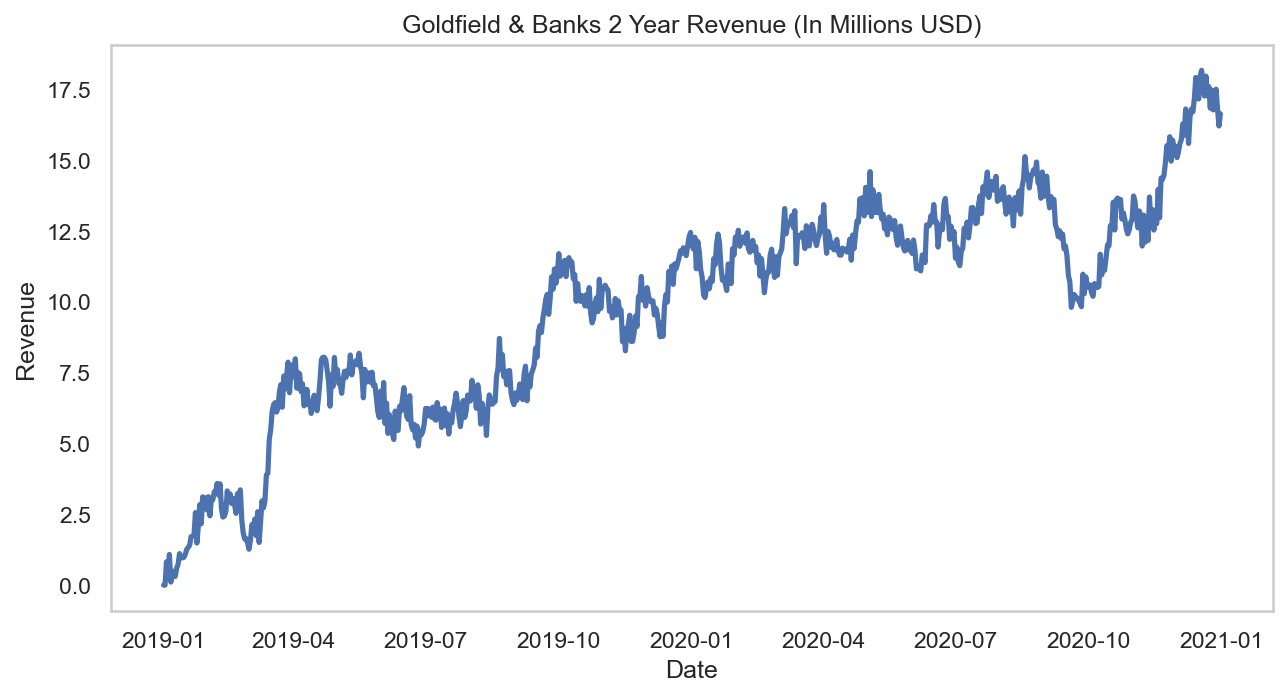

In [31]:
# step: Plot time series as shown below
ax = sns.lineplot(data=prep_df, x="Date", y="Revenue")
plt.grid(b=False)
_ = ax.set(title="Goldfield & Banks 2 Year Revenue (In Millions USD)")



### ✅ 3.  Evaluate the stationarity of the time series.
- https://otexts.com/fpp2/stationarity.html
- https://machinelearningmastery.com/time-series-data-stationary-python/

A stationary time series is one whose properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be.

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

For a time series to be stationary, it should satisfy the following 3 conditions:
- Mean (μ) is constant
- Standard Deviation (σ) is constant
- Seasonality doesn’t exist

- For example, when modeling, there are assumptions that the summary statistics of observations are consistent. In time series terminology, we refer to this expectation as the time series being stationary. These assumptions can be easily violated in time series by the addition of a trend, seasonality, and other time-dependent structures. The observations in a stationary time series are not dependent on time. Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations. When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.

- Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index. Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture. Classical time series analysis and forecasting methods are concerned with making non-stationary time series data stationary by identifying and removing trends and removing seasonal effects.

- If we fit a stationary model to data, we assume our data are a realization of a stationary process. So our first step in an analysis should be to check whether there is any evidence of a trend or seasonal effects and, if there is, remove them.

- The suggestion here is to treat properties of a time series being stationary or not as another source of information that can be used in feature engineering and feature selection on your time series problem when using machine learning methods.

- Checks for Stationarity
    - There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.
        - Look at Plots: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
        - Summary Statistics: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
        - Statistical Tests: You can use statistical tests to check if the expectations of stationarity are met or have been violated.
    - A quick and dirty check to see if your time series is non-stationary is to review summary statistics. You can split your time series into two (or more) partitions and compare the mean and variance of each group. If they differ and the difference is statistically significant, the time series is likely non-stationary.


#### Rolling Statistics Plots

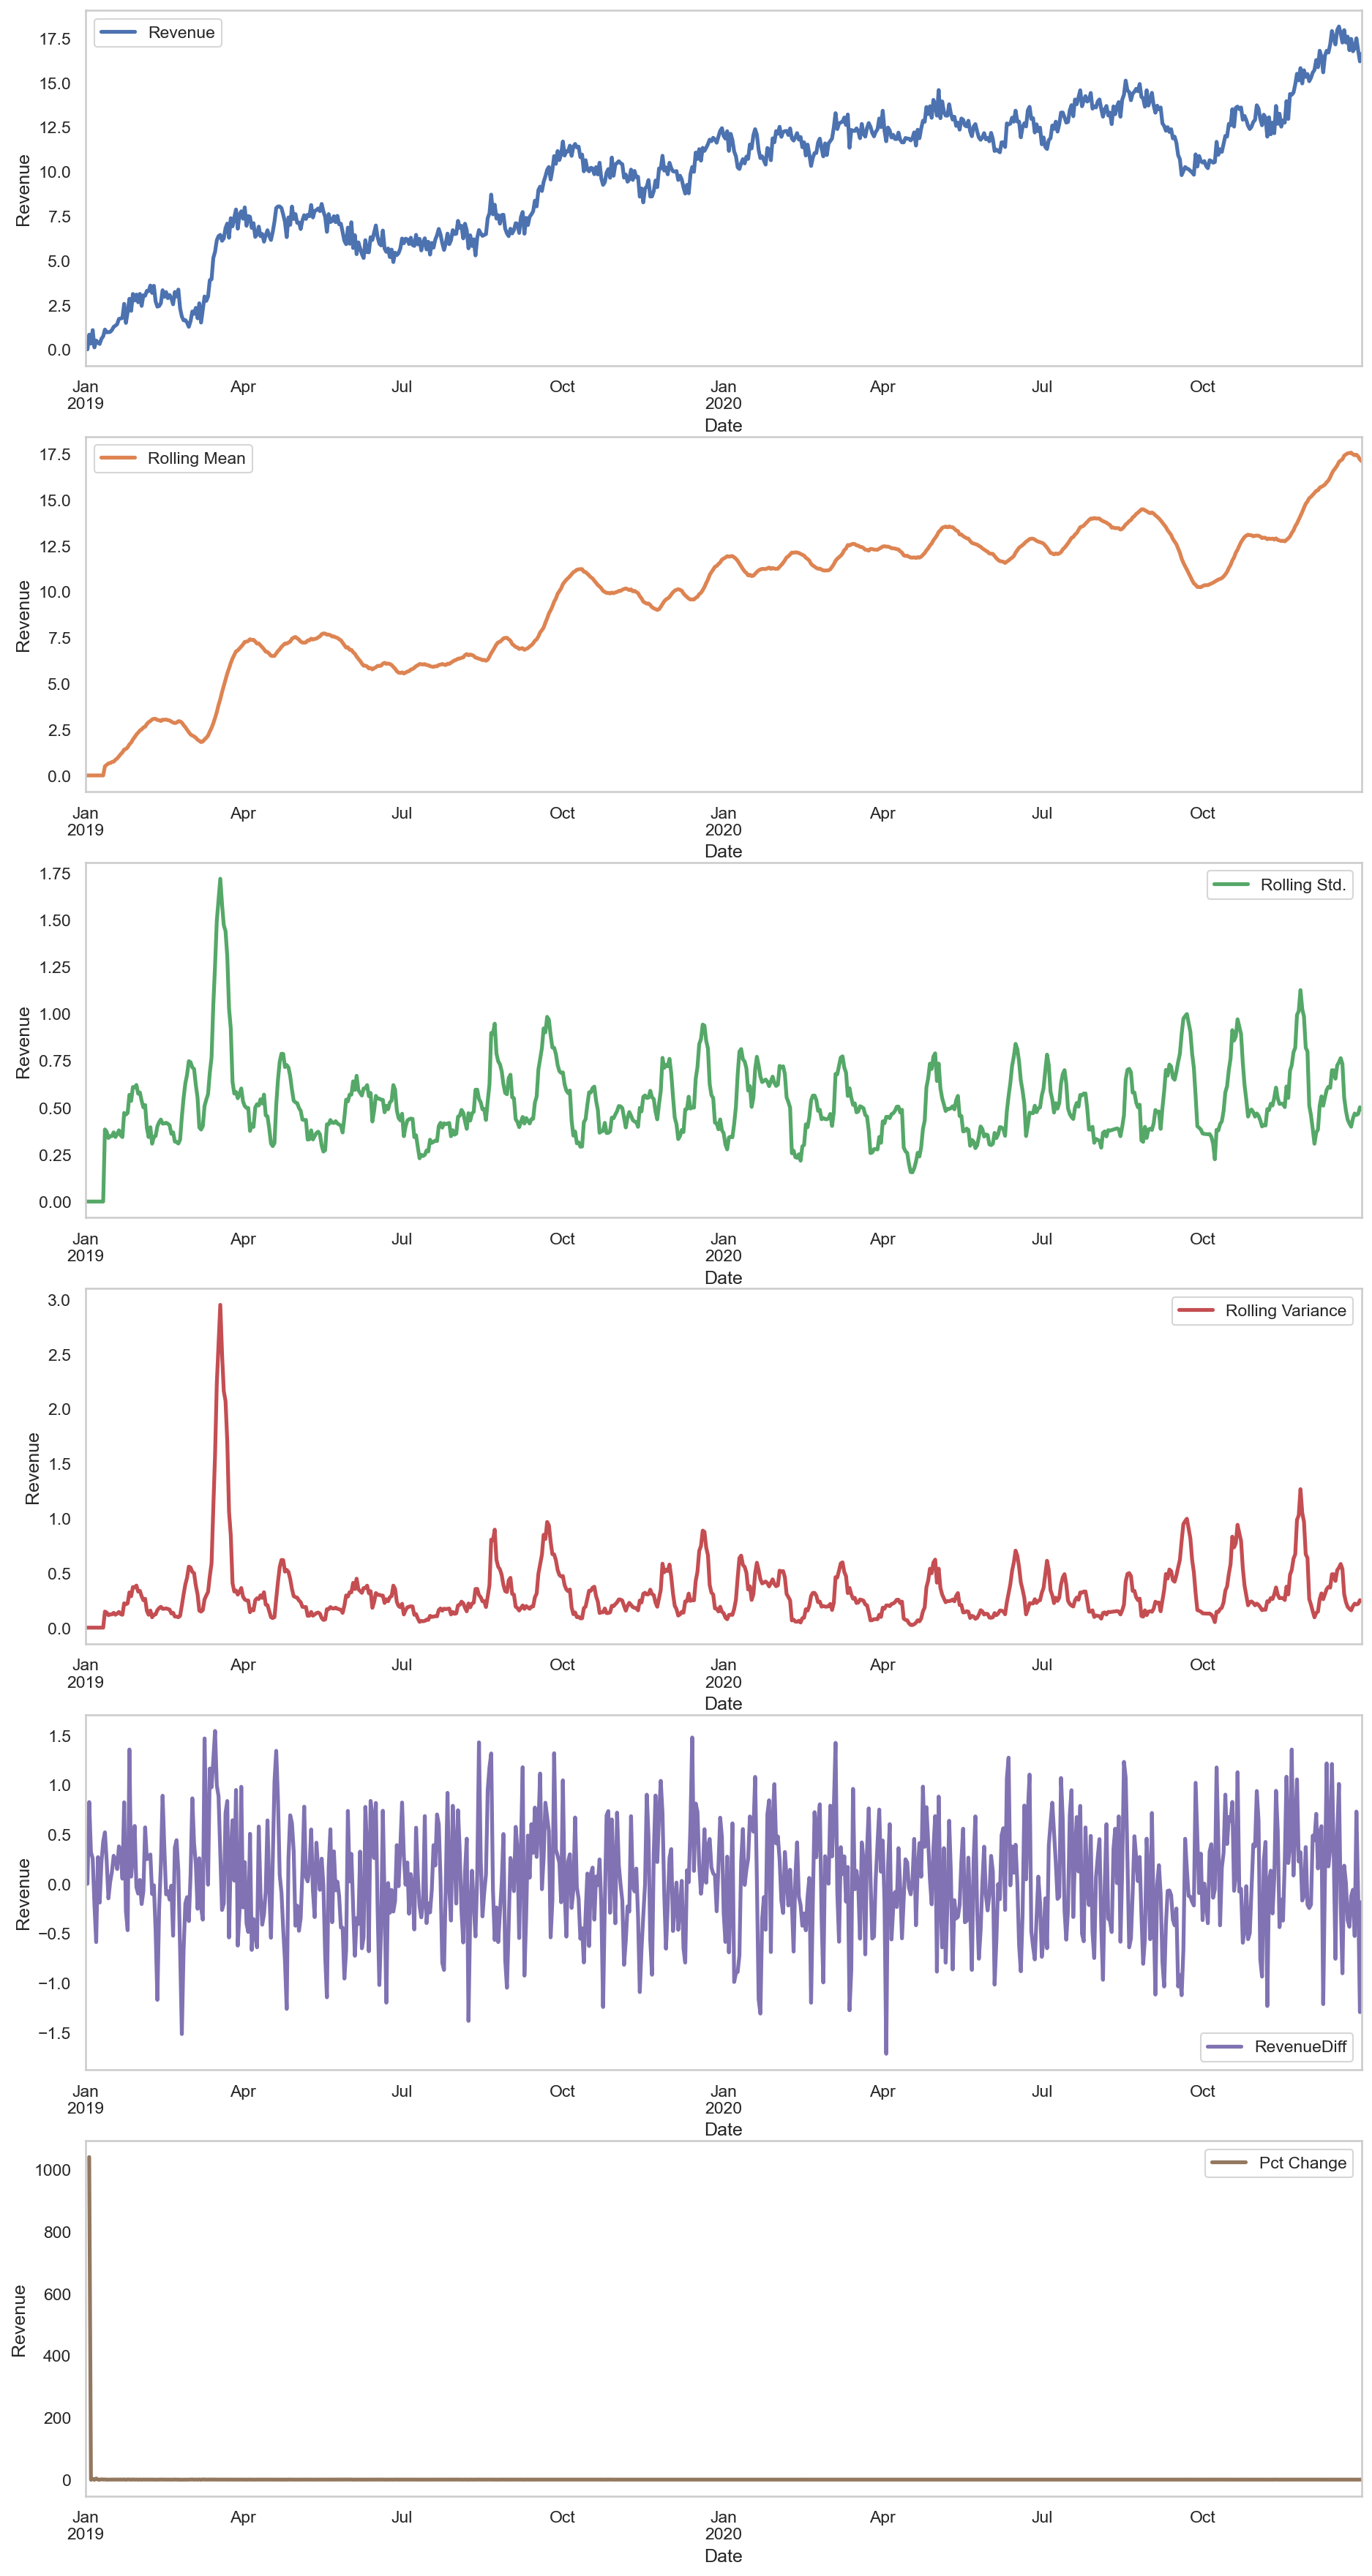

In [32]:
ax = prep_df.drop(columns=["Day"]).plot(
    kind="line",
    grid=False,
    subplots=True,
    figsize=(15, 30),
    use_index=True,
    sharex=False,
    ylabel="Revenue",
)

plt.show()


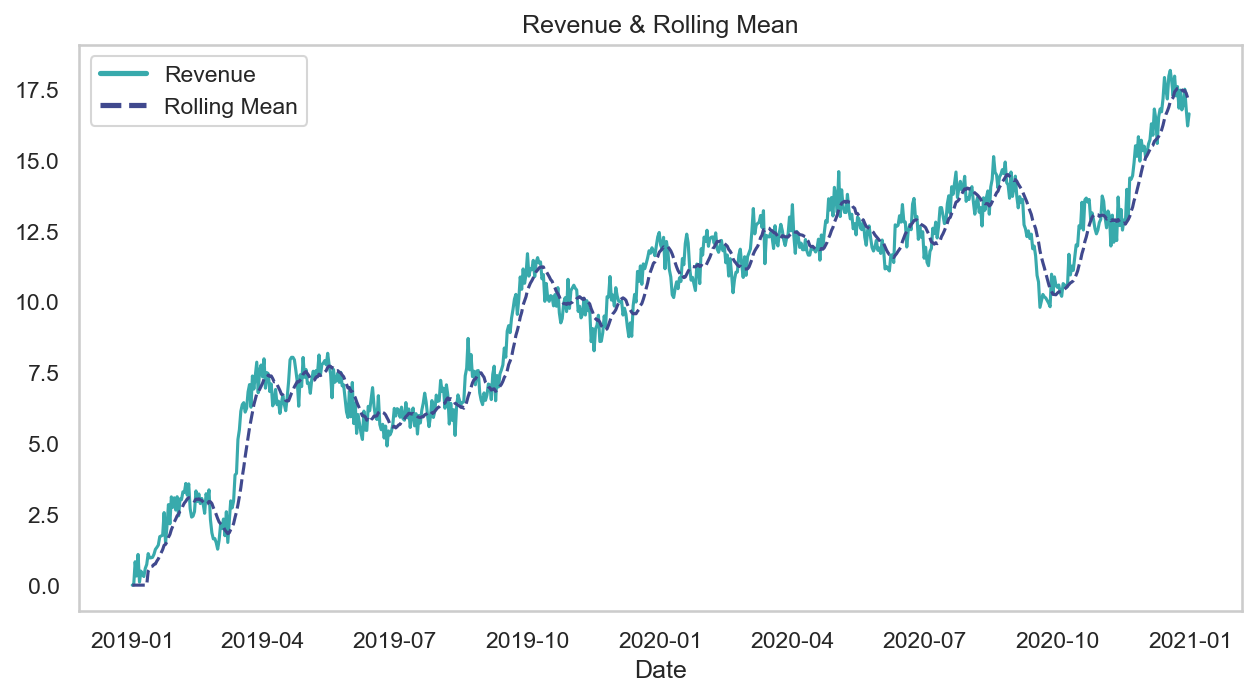

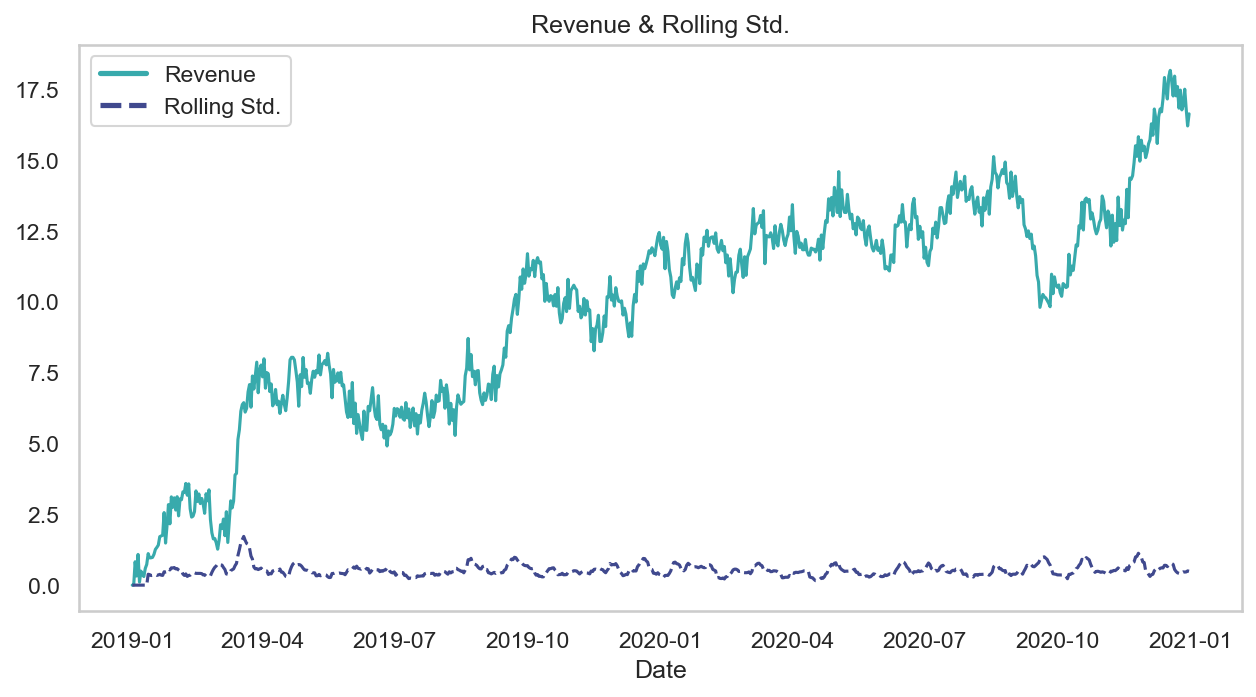

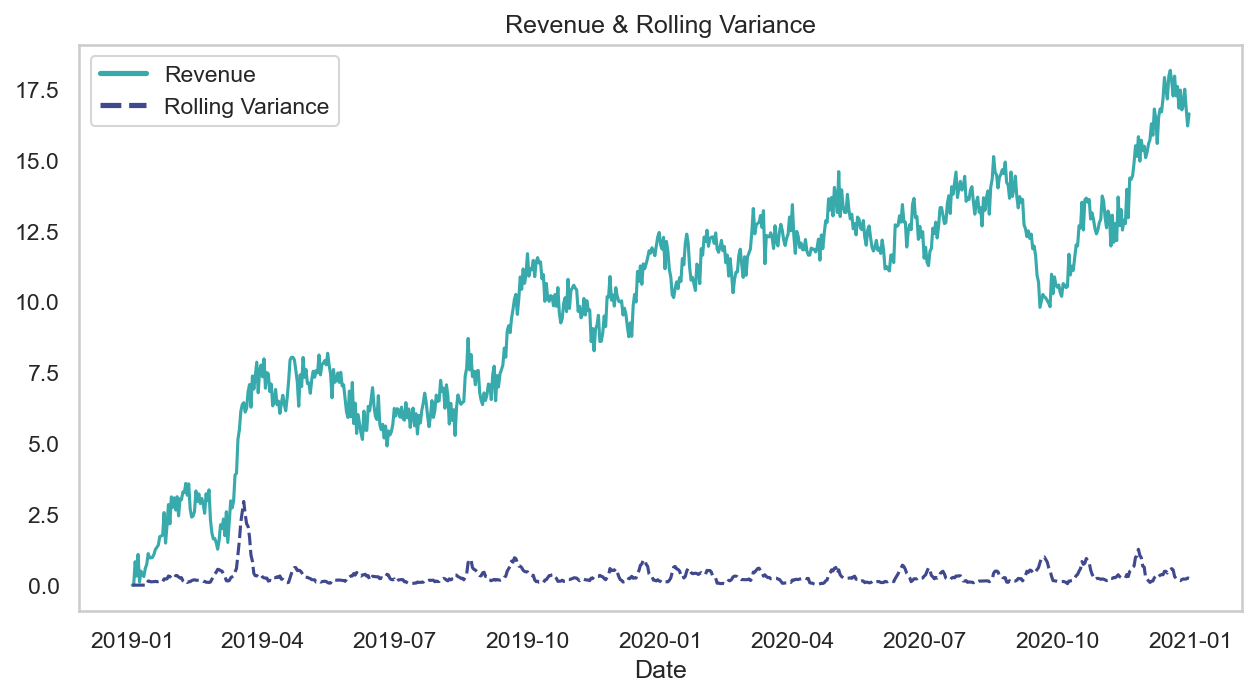

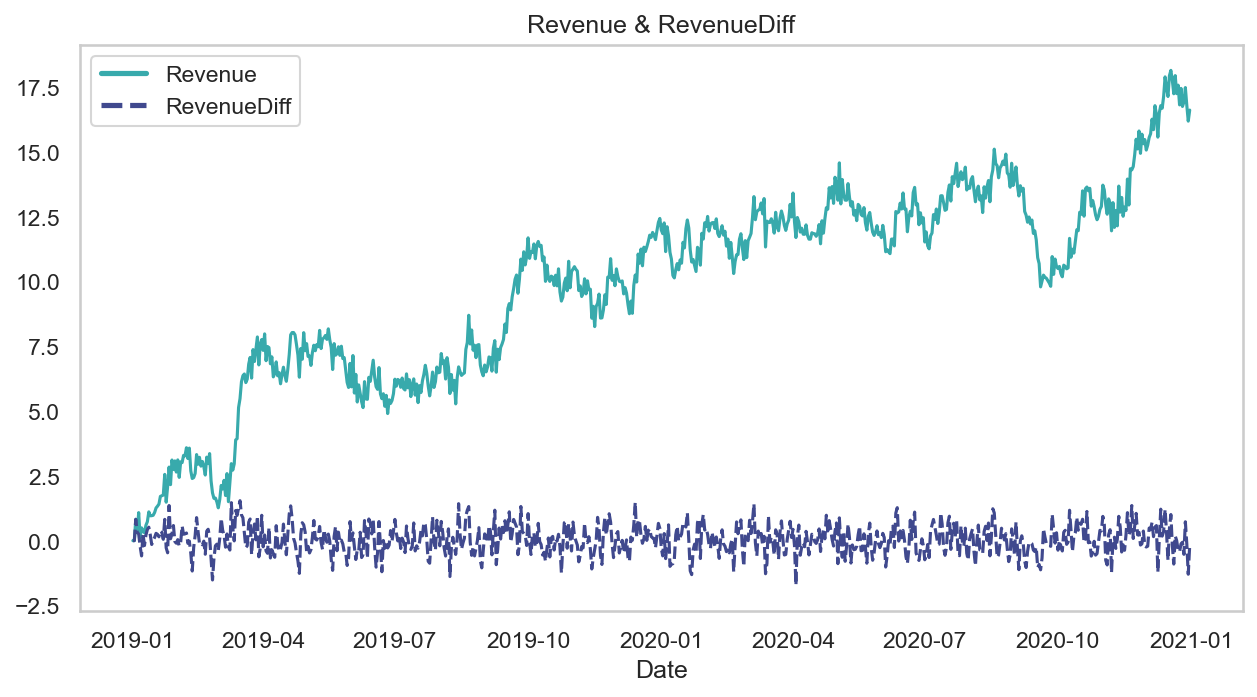

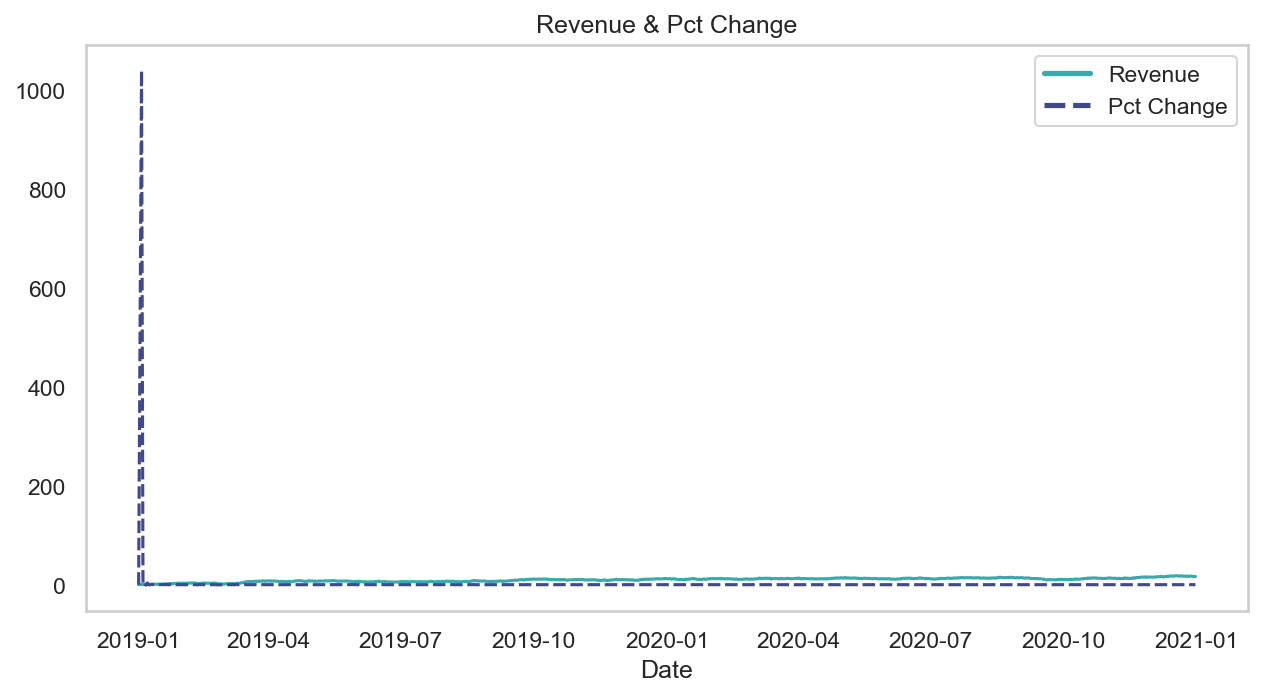

In [33]:
for col in prep_df.columns:
    if col in ["Revenue", "Day"]:
        continue

    ax = sns.lineplot(
        data=prep_df[["Revenue", col]],
        palette=sns.color_palette("mako_r", 2),
        linewidth=1.5,
    )
    plt.grid(False)
    _ = ax.set(title=f"Revenue & {col}")
    plt.show()


#### Time Series Decomposition

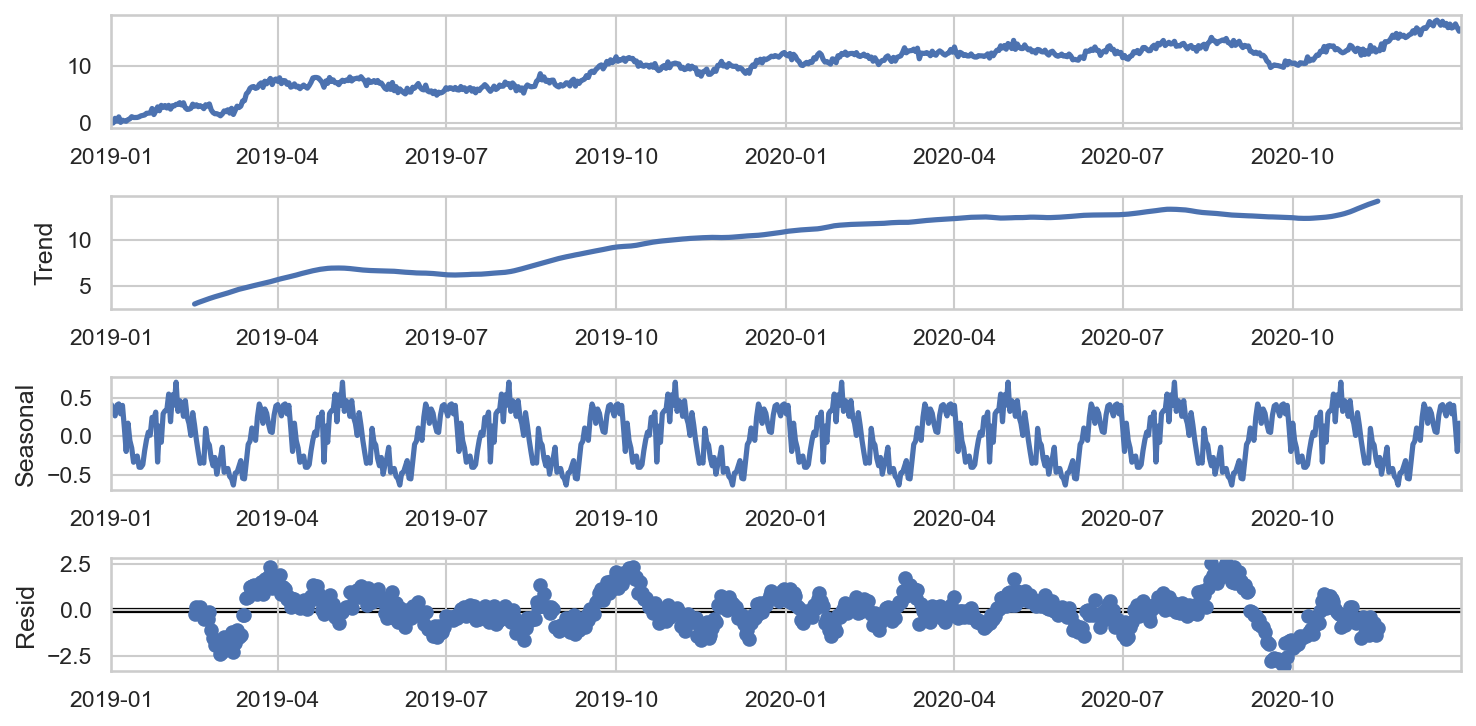

In [34]:
# Decomposing Time Series means splitting Time Series  data into its 3 components: Trend, Seasonality, and Residual. It provides a visual summary of the components and helps detect the presence or the lack of these components .
decomp = seasonal_decompose(x=prep_df[["Revenue"]], period=90)

_ = decomp.plot()
plt.show()


##### Seasonality

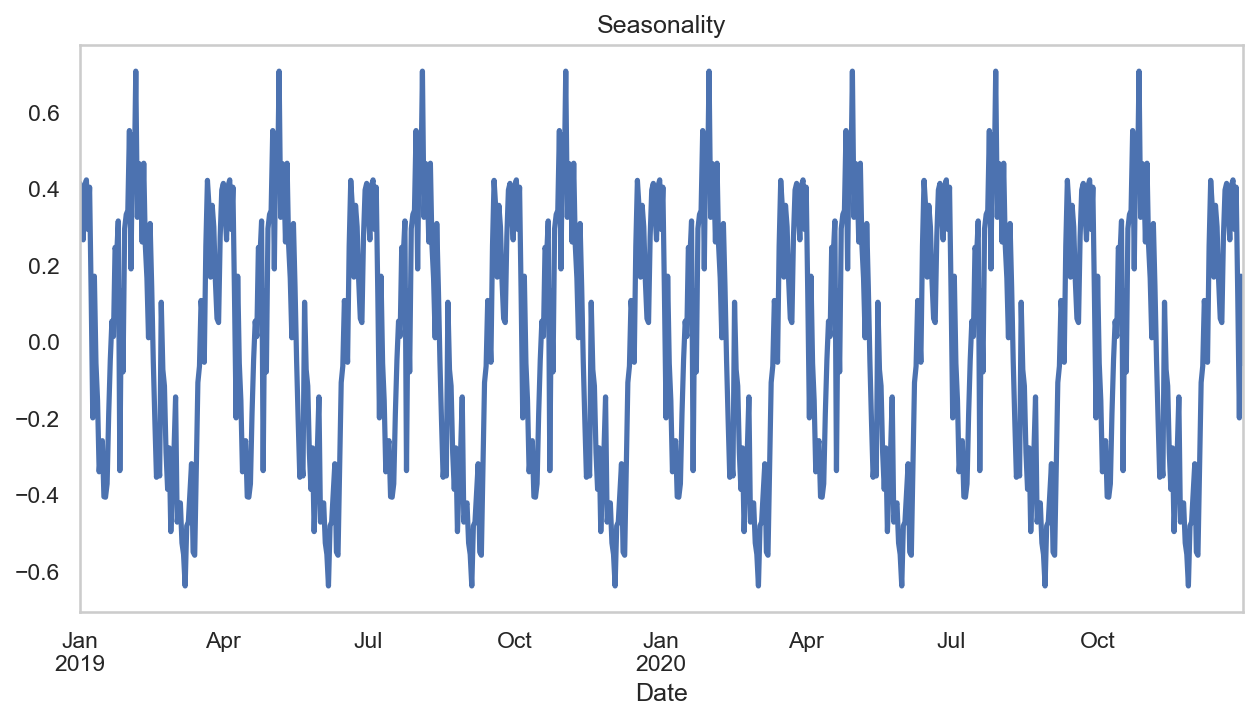

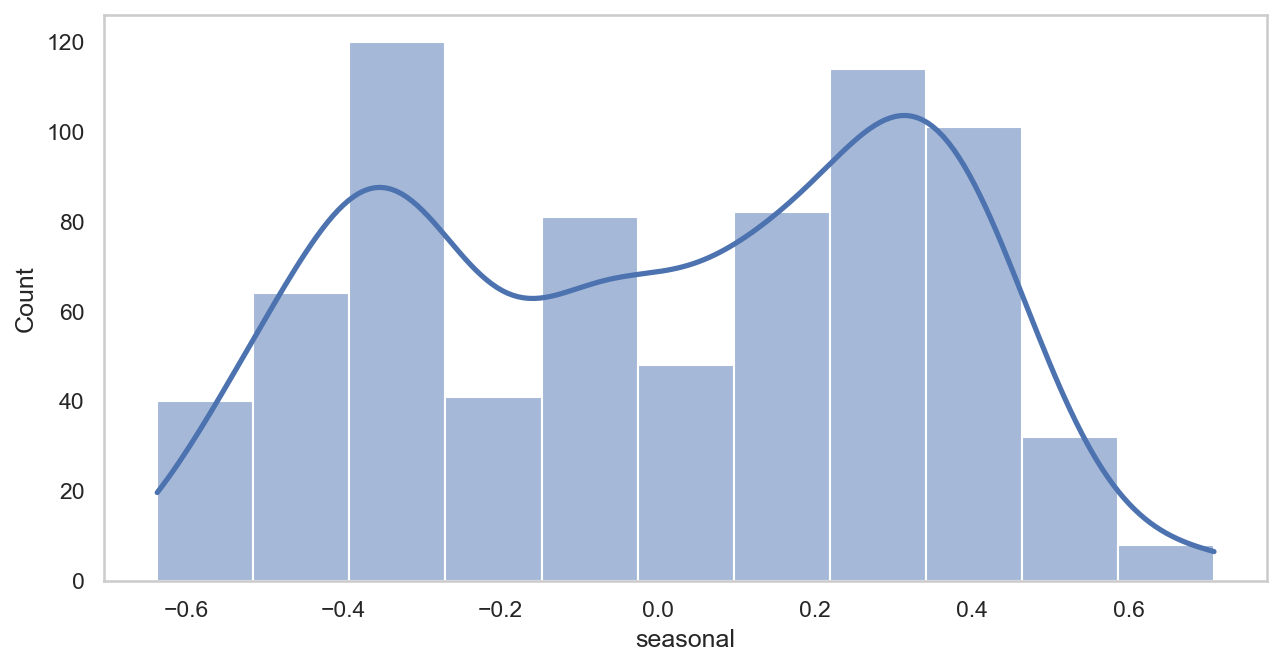

In [35]:
_ = plt.title("Seasonality")
_ = decomp.seasonal.plot()
plt.grid(False)
plt.show()

_ = sns.histplot(decomp.seasonal, kde=True)
plt.grid(False)
plt.show()


##### Trend

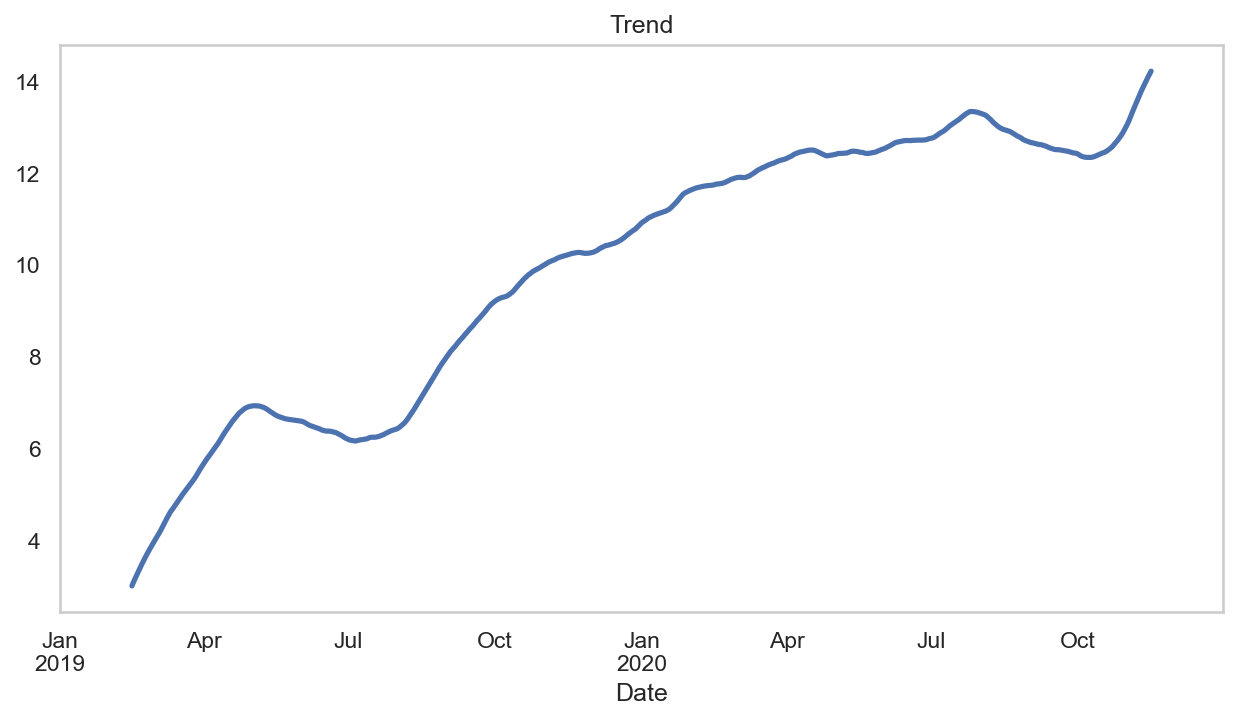

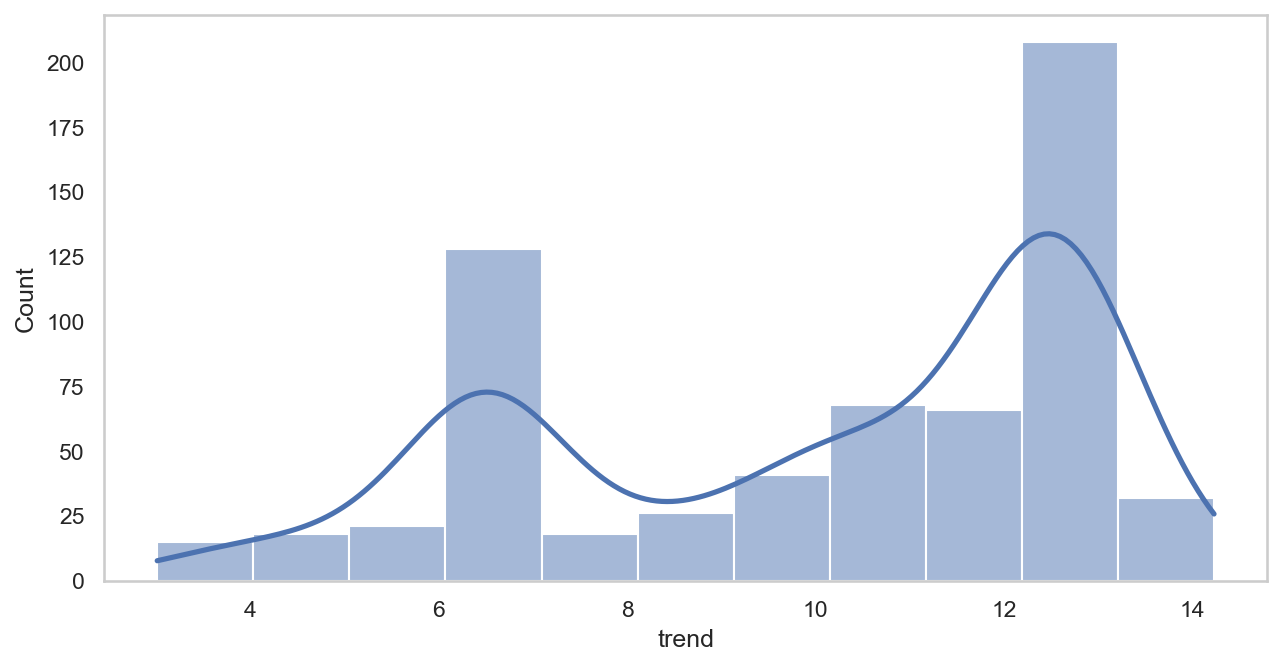

In [36]:
_ = plt.title("Trend")
_ = decomp.trend.plot()
plt.grid(False)
plt.show()

_ = sns.histplot(decomp.trend, kde=True)
plt.grid(False)
plt.show()


##### Residuals

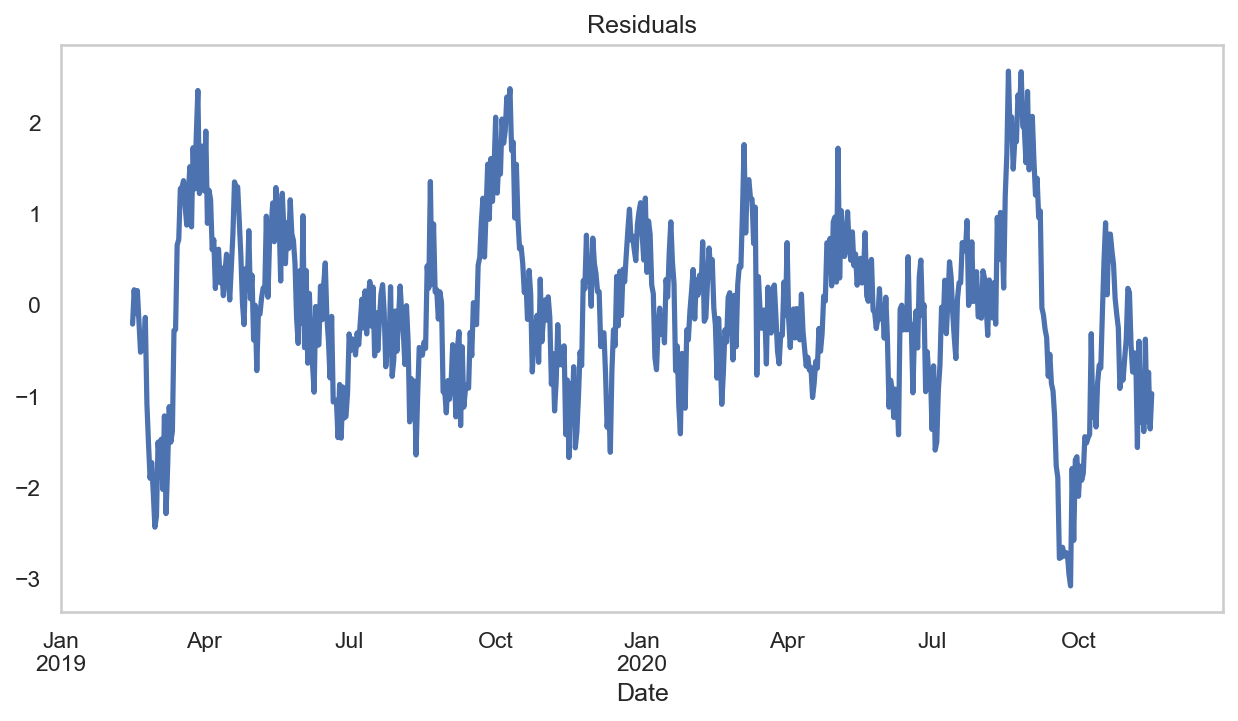

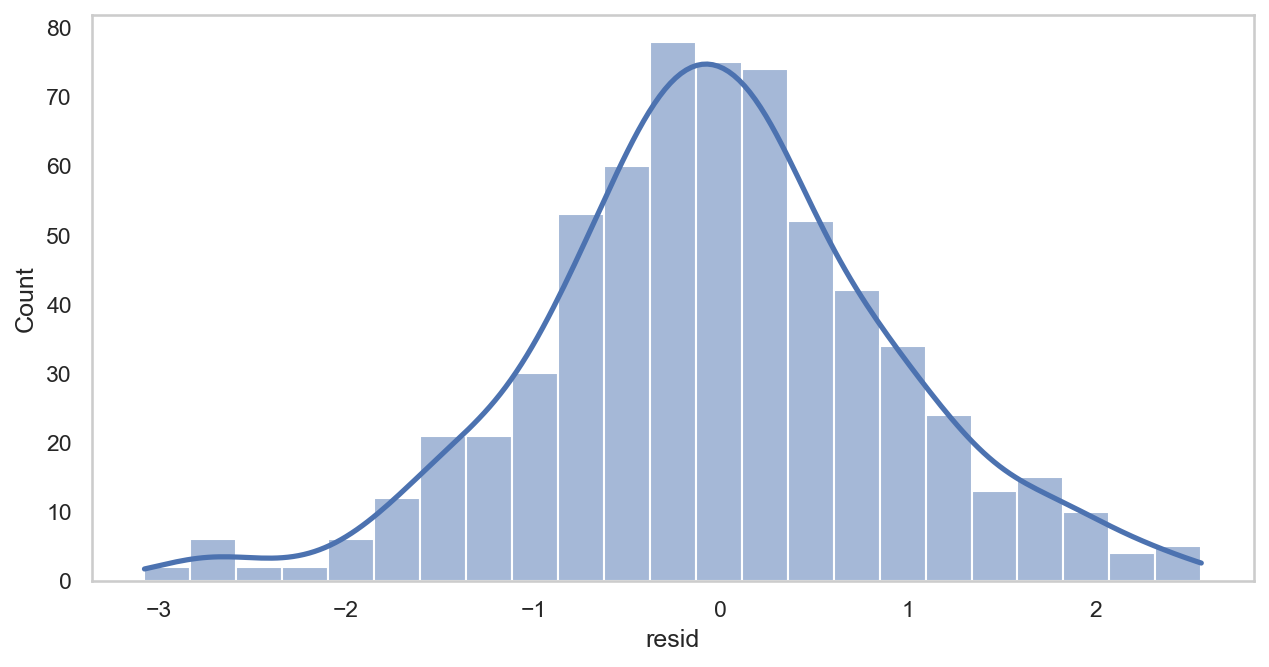

In [37]:
_ = plt.title("Residuals")
_ = decomp.resid.plot()
plt.grid(False)
plt.show()

# A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.
_ = sns.histplot(decomp.resid, kde=True)
plt.grid(False)
plt.show()


#### ✅ Augmented Dickey-Fuller unit root test
- **Null Hypothesis (H0)**
    - If we fail to reject, it suggests the time series has a unit root, meaning it is non-stationary and has some time dependent structure.

- **Alternate Hypothesis (H1)**:
    - If we reject the null hypothesis; it suggests the time series does not have a unit root, meaning it is stationary and it does not have time-dependent structure.
    
The Augmented Dickey-Fuller evaluates the stationarity of time series data. If the data is not stationary, then we'll need to transform the data so that it is. The reason is that, to model (ARIMA) a time series, it must be stationary. For ADFuller test, a p-value of <= 0.05, allow me to reject or accept the null hypothesis.


The ADF test statistic value is -1.92. The more negative this statistic, the more likely we are to reject the null hypothesis — that we have a stationary dataset.

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -1.92 is greater than the value of -3.4 at 1% and -2.87 at 5%.

**This suggests that we fail to reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).**

Failing to reject the null hypothesis means that the process has a unit root, and in turn that the time series is non-stationary or has a time-dependent structure.

shows a negative value for the test statistic.

We can see that the value is larger than the critical values, again, meaning that we can fail to reject the null hypothesis and in turn that the time series is non-stationary.

In [38]:
# Augmented Dickey-Fuller test
# use a statistical test designed to explicitly comment on whether a univariate time series is stationary.
# The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

# """
# Augmented Dickey-Fuller test
# Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

# Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

# The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

# The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

# There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

# The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

# Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
# Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
# We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
# """

# Notes

# The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

# The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

# 1. Random Walk
# In a random walk, today's price is equal to yesterday's price plus some noise. The change in price of a random walk is just White Noise. Incidentally, if prices are in logs, then the difference in log prices is one way to measure returns. The bottom line is that if stock *prices* follow a random walk, then stock *returns* are White Noise. You can't forecast a random walk. The best guess for tomorrow's price is simply today's price. In a random walk with drift, prices on average drift by mu every period. And the change in price for a random walk with drift is still white noise but with a mean of mu. So if we now think of stock prices as a random walk with drift, then the returns are still white noise, but with an average return of mu instead of zero.

# 5. Statistical Test for Random Walk
# To test whether a series like stock prices follows a random walk, you can regress current prices on lagged prices. If the slope coefficient, beta, is not significantly different from one, then we cannot reject the null hypothesis that the series is a random walk. However, if the slope coefficient is significantly less than one, then we can reject the null hypothesis that the series is a random walk. An identical way to do that test is to regress the difference in prices on the lagged price, and instead of testing whether the slope coefficient is 1, now we test whether it is zero.

# 7. Statistical Test for Random Walk
# This is called the "Dickey-Fuller" test. If you add more lagged prices on the right hand side, then it's called the Augmented Dickey-Fuller test.

# 8. ADF Test in Python
# statsmodels has a function, adfuller, for performing the Augmented Dickey-Fuller test.

# 9. Example: Is the S&P500 a Random Walk?
# As an example, let's run the Augmented Dickey-Fuller test on a time series of S&P500 prices using the adfuller function. The results are stored in results. The main output we're interested in is the p-value of the test. If the p-value is less than 5%, we can reject the null hypothesis that the series is a random walk with 95% confidence. In this case, the p-value is much higher than 0.05 - it's 0.32. Therefore, we cannot reject the null hypothesis that the S&P500 is a random walk. You can also print out the full output of the test, which gives other information, like the number of observations (1257), the test statistic (-point-917) and the critical values of the test statistic for various alphas - 1%, 10%, and 5%.


##### Original Revenue Data

In [39]:
adf, pvalue, _, _, crit_vals, _ = adfuller(prep_df.Revenue)
pd.DataFrame(
    dict(
        ADF_Statistic=[adf],
        P_Value=[pvalue],
        Critical_Values=[{k: round(v, 2) for k, v in crit_vals.items()}],
    )
)

if pvalue <= 0.05:
    print(
        "rejecting the null hypothesis, time series has no unit root and is stationary"
    )
else:
    print(
        "failed to reject the null hypothesis, time series has a unit root and is non-stationary"
    )


ADF_Statistic  P_Value                           Critical_Values
0          -1.92     0.32  {'1%': -3.44, '5%': -2.87, '10%': -2.57}

failed to reject the null hypothesis, time series has a unit root and is non-stationary


##### Differenced Revenue Data

P-Value 0.000000000000000


ADF_Statistic  P_Value                           Critical_Values
0         -44.92     0.00  {'1%': -3.44, '5%': -2.87, '10%': -2.57}

rejecting the null hypothesis, time series has no unit root and is stationary


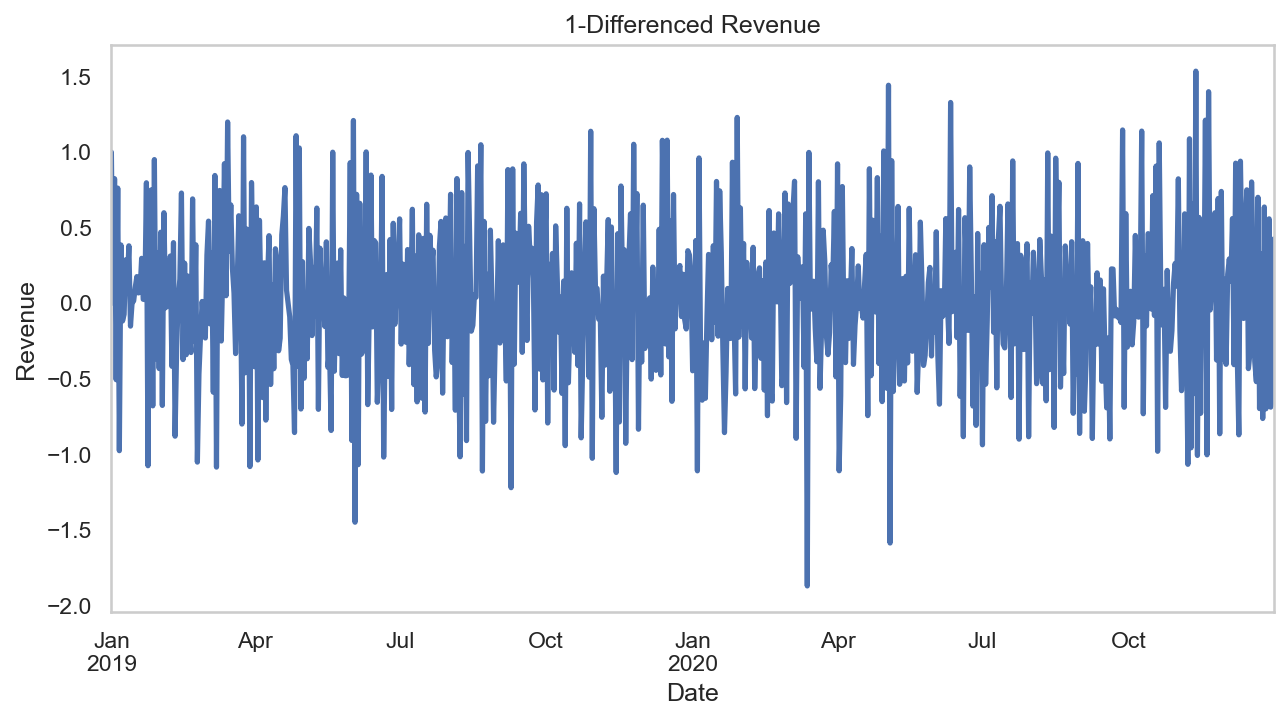

P-Value 0.000000000000000


ADF_Statistic  P_Value                           Critical_Values
0         -44.95     0.00  {'1%': -3.44, '5%': -2.87, '10%': -2.57}

rejecting the null hypothesis, time series has no unit root and is stationary


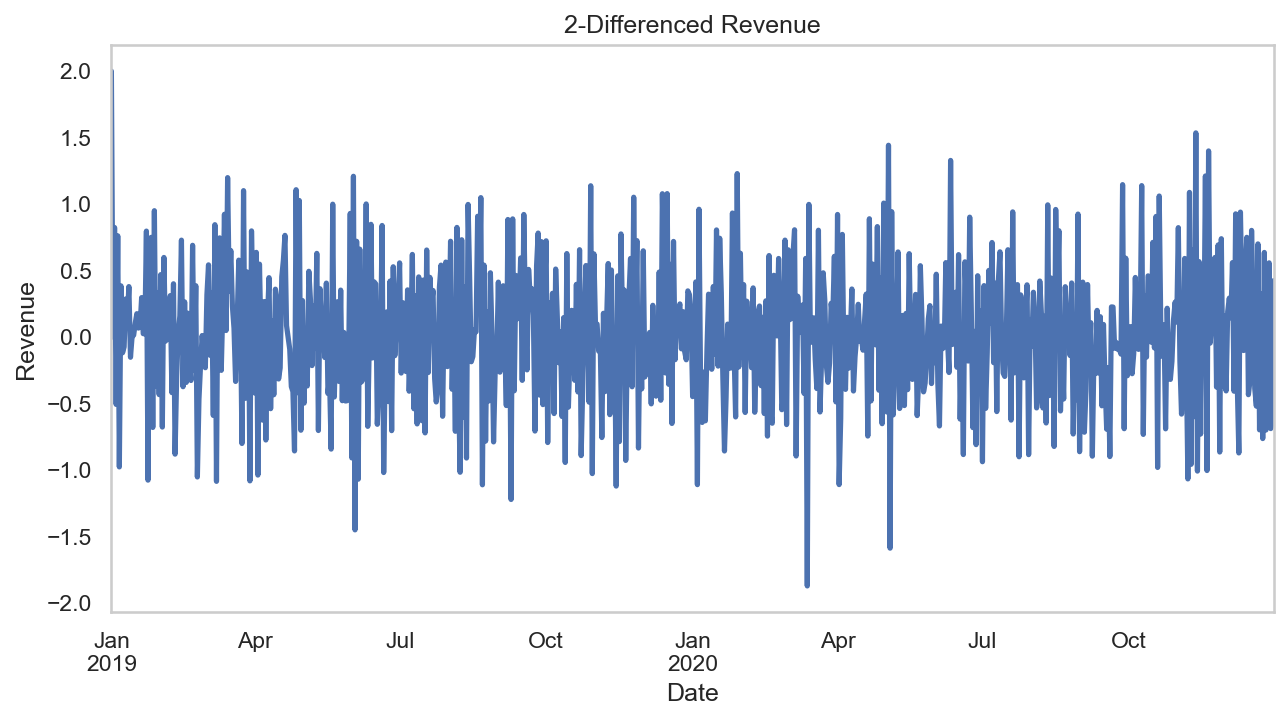

In [40]:
for n in [1, 2]:
    diff = prep_df["Revenue"].diff().fillna(n)
    adf, pvalue, _, _, crit_vals, _ = adfuller(diff)
    print(f"P-Value {pvalue:.15f}")

    pd.DataFrame(
        dict(
            ADF_Statistic=[adf],
            P_Value=[pvalue],
            Critical_Values=[{k: round(v, 2) for k, v in crit_vals.items()}],
        )
    )

    if pvalue <= 0.05:
        print(
            "rejecting the null hypothesis, time series has no unit root and is stationary"
        )
    else:
        print(
            "failed to reject the null hypothesis, time series has a unit root and is non-stationary"
        )

    ax = diff.plot(title=f"{n}-Differenced Revenue", ylabel="Revenue")
    plt.grid(False)
    plt.show()


#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
- KPSS is another test for checking the stationarity of a time series.
- The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.
- Null Hypothesis: The process is trend stationary.
- Alternate Hypothesis: The series has a unit root (series is not stationary).

In [41]:
def kpss_test(timeseries):
    kpsstest = kpss(timeseries, regression="c", nlags="auto")

    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )

    for key, value in kpsstest[3].items():
        kpss_output[f"Critical Value {key}"] = value

    print("P-Value", kpss_output.get("p-value"))
    if kpss_output.get("p-value", 0) < 0.05:
        print(
            "Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test.",
            end="\n\n",
        )
    else:
        print(
            "Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for failing to reject the null hypothesis in favor of the alternative. Hence, the series is stationary as per the KPSS test.",
            end="\n\n",
        )

    return pd.DataFrame(kpss_output, columns=["Metric"])


display("KPSS Revenue (Original)", kpss_test(timeseries=prep_df.Revenue))


for n in [1, 2]:
    display(
        f"KPSS Revenue ({n}-Differenced)",
        kpss_test(timeseries=prep_df.Revenue.diff(periods=n).fillna(0)),
    )


P-Value 0.01
Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for rejecting the null hypothesis in favor of the alternative. Hence, the series is non-stationary as per the KPSS test.



'KPSS Revenue (Original)'

Metric
Test Statistic         3.56
p-value                0.01
Lags Used             17.00
Critical Value 10%     0.35
Critical Value 5%      0.46
Critical Value 2.5%    0.57
Critical Value 1%      0.74

P-Value 0.1
Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for failing to reject the null hypothesis in favor of the alternative. Hence, the series is stationary as per the KPSS test.



'KPSS Revenue (1-Differenced)'

Metric
Test Statistic         0.07
p-value                0.10
Lags Used              4.00
Critical Value 10%     0.35
Critical Value 5%      0.46
Critical Value 2.5%    0.57
Critical Value 1%      0.74

P-Value 0.1
Based upon the significance level of 0.05 and the p-value of KPSS test, there is evidence for failing to reject the null hypothesis in favor of the alternative. Hence, the series is stationary as per the KPSS test.



'KPSS Revenue (2-Differenced)'

Metric
Test Statistic         0.08
p-value                0.10
Lags Used              6.00
Critical Value 10%     0.35
Critical Value 5%      0.46
Critical Value 2.5%    0.57
Critical Value 1%      0.74

#### Autocorrelation Plots
For a stationary Time Series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly.

What is Autocorrelation?
Autocorrelation is the correlation of a single time series with a lagged copy of itself. It's also called "serial correlation". Often, when we refer to a series's autocorrelation, we mean the "lag-one" autocorrelation. So when using daily data, for example, the autocorrelation would be the correlation of the series with the same series lagged by one day.

**Interpretation of Autocorrelation**
- What does it mean when a series has a positive or negative autocorrelation? With financial time series, when returns have a negative autocorrelation, we say it is "mean reverting".
- Alternatively, if a series has positive autocorrelation, we say it is "trend-following".


1. Autocorrelation Function
The sample autocorrelation function, or ACF,

2. Autocorrelation Function
shows not only the lag-one autocorrelation from the last chapter, but the entire autocorrelation function for different lags. Any significant non-zero autocorrelations implies that the series can be forecast from the past.

3. ACF Example 1: Simple Autocorrelation Function
This autocorrelation function implies that you can forecast the next value of the series from the last two values, since the lag-one and lag-two autocorrelations differ from zero.

4. ACF Example 2: Seasonal Earnings
Consider the time series of quarterly earnings of the company H&R Block. As we mentioned last chapter, a vast majority of their earnings occurs in the quarter that taxes are due. In this case, you can clearly see a seasonal pattern in the quarterly data on the left, and the autocorrelation function on the right shows strong autocorrelation at lags 4, 8, 12, 16, and 20

5. ACF Example 3: Useful for Model Selection
The ACF can also be useful for selecting a parsimonious model for fitting the data. In this example, the pattern of the autocorrelation suggests a model for the series that will be discussed in the next chapter.

6. Plot ACF in Python
plot_acf is the statsmodels function for plotting the autocorrelation function. The input x is a series or array. The argument lags indicates how many lags of the autocorrelation function will be plotted. The alpha argument sets the width of the confidence interval, which is discussed on the next slide.

7. Confidence Interval of ACF
Here is an ACF plot that contains confidence intervals for each lag, which is the blue region in the figure.

8. Confidence Interval of ACF
In plot_acf, the argument alpha determines the width of the confidence intervals. For example, if alpha equals 0-point-05, that means that if the true autocorrelation at that lag is zero, there is only a 5% chance the sample autocorrelation will fall outside that window. You will get a wider confidence interval if you set alpha lower, or if you have fewer observations. An approximation to the width of the 95% confidence intervals, if you make some simplifying assumptions, is plus or minus 2 over the square root of the number of observations in your series. Incidentally, if you don't want to see confidence intervals in your plot, set alpha equal to one.

9. ACF Values Instead of Plot
Besides plotting the ACF, you can also extract its numerical values using a similar Python function, acf, instead of plot_acf.

##### ACF Bar Plot
- Autocorrelation is the correlation of a single time series with a lagged copy of itself — It's also called "serial correlation".
- Often, when we refer to a series's autocorrelation, we mean the "lag-one" autocorrelation.
- So when using daily data, for example, the autocorrelation would be the correlation of the series with the same series lagged by one day.

autocorrelation
lag                 
0               1.00
1               0.98
2               0.98
3               0.97
4               0.96

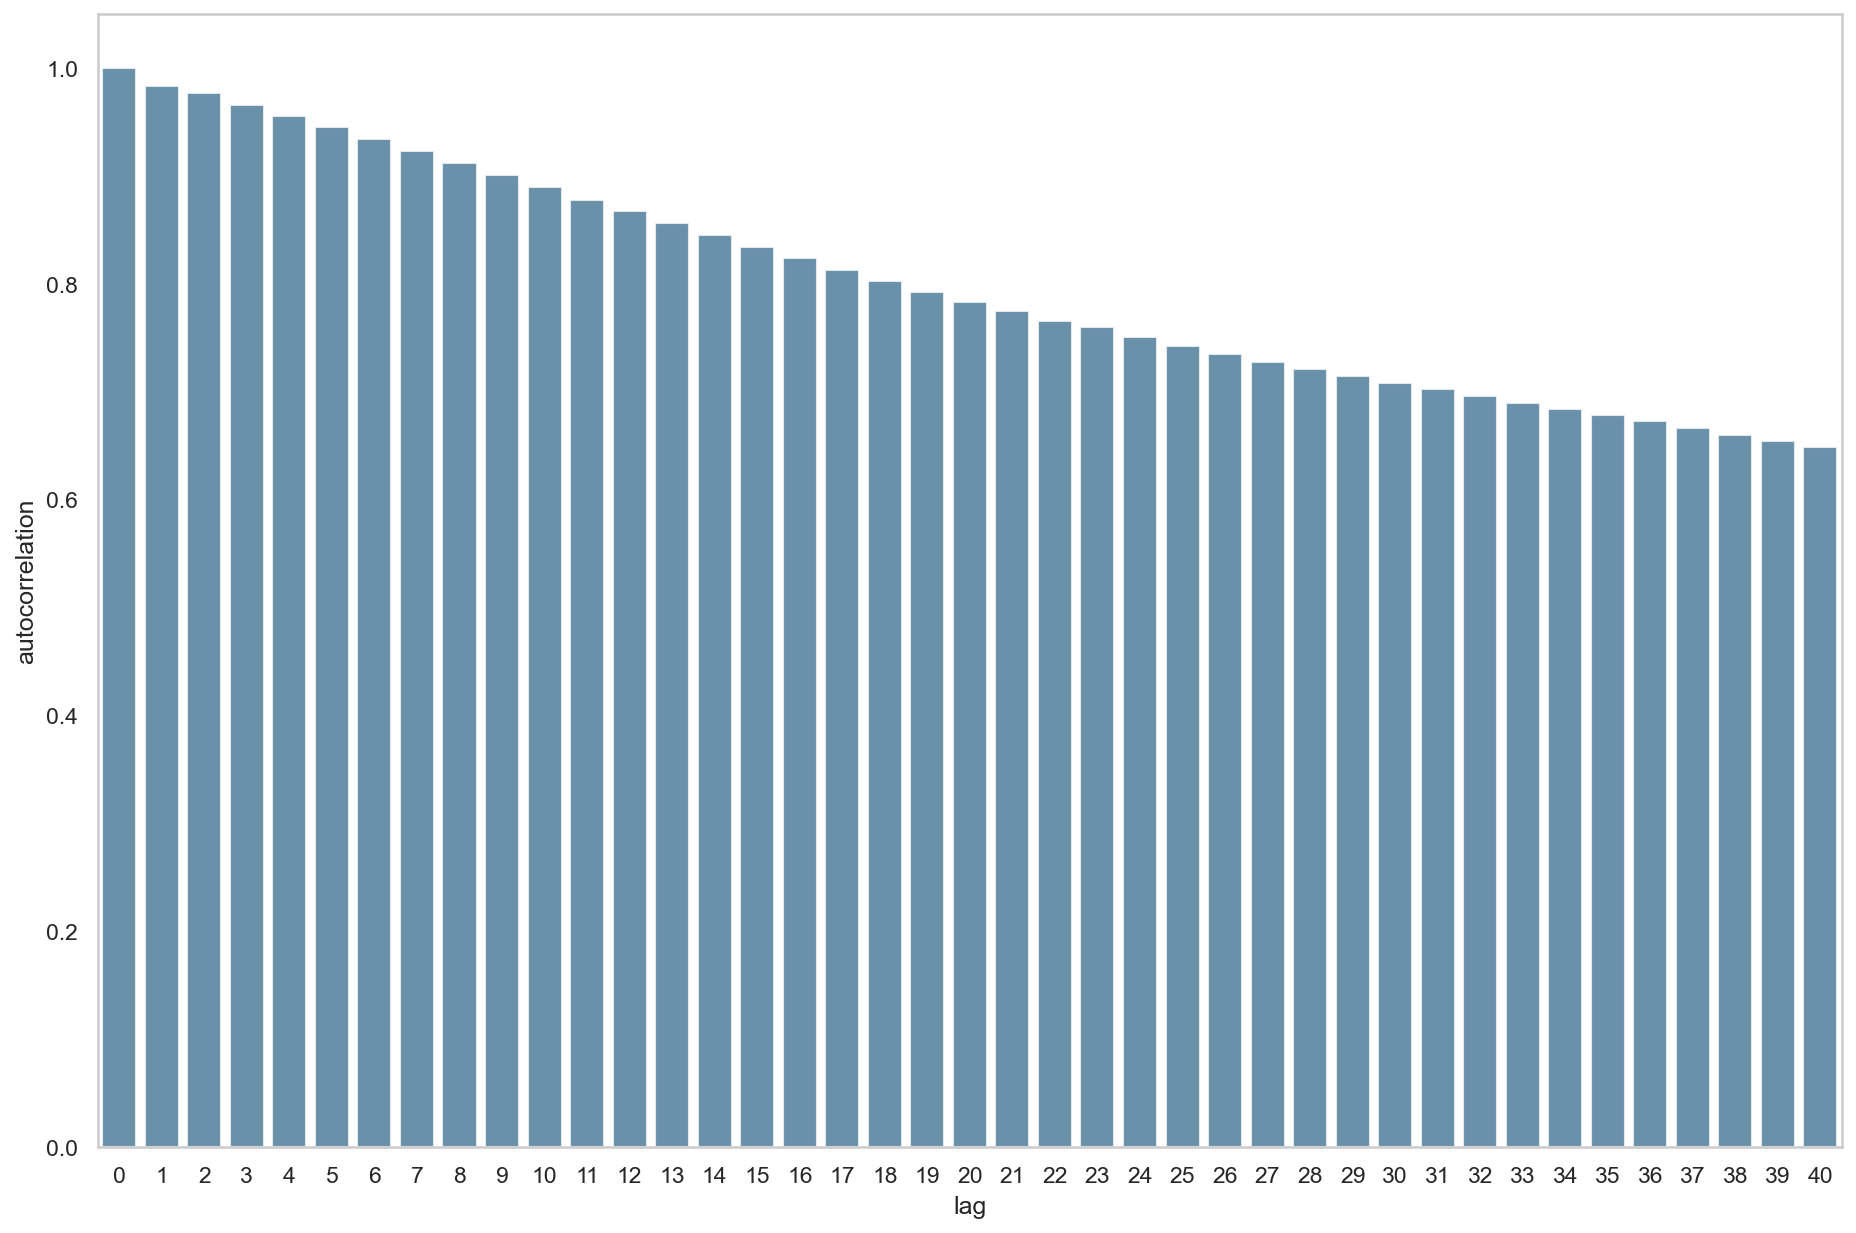

In [42]:
# Compute the array of autocorrelations
acf_1 = pd.DataFrame(acf(prep_df.Revenue, nlags=40), columns=["autocorrelation"])
acf_1.index.name = "lag"

acf_1.head()
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(
    y=acf_1.autocorrelation,
    x=acf_1.reset_index().lag,
    palette=sns.color_palette("mako_r", 1),
    alpha=0.8,
)
plt.grid(False)
plt.show()


##### ACF
Autocorrelation quickly moves close to 0 for differenced data.

- alpha : scalar, optional If a number is given, the confidence intervals for the given level are returned. For instance if alpha=.05, 95% confidence intervals are returned where the standard deviation is computed according to Bartlett's formula.

- if alpha equals 0.05, that means that if the true autocorrelation at that lag is zero, there is only a 5% chance the sample autocorrelation will fall outside that window. 

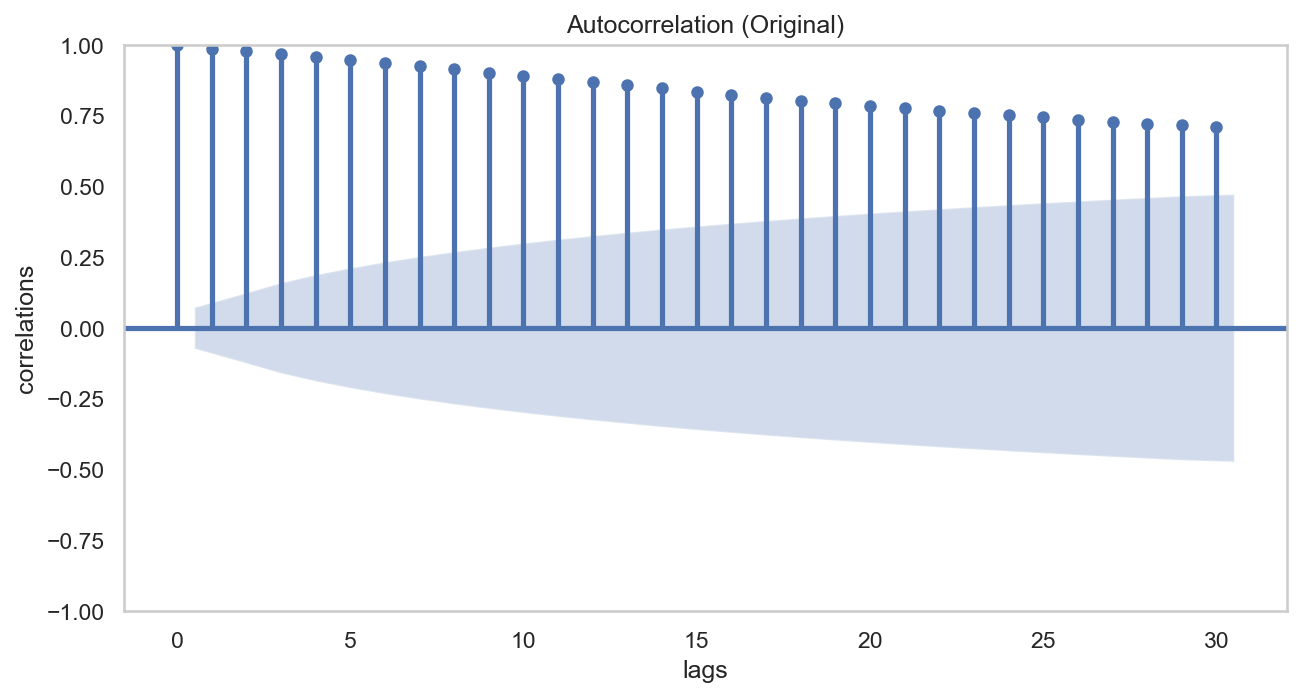

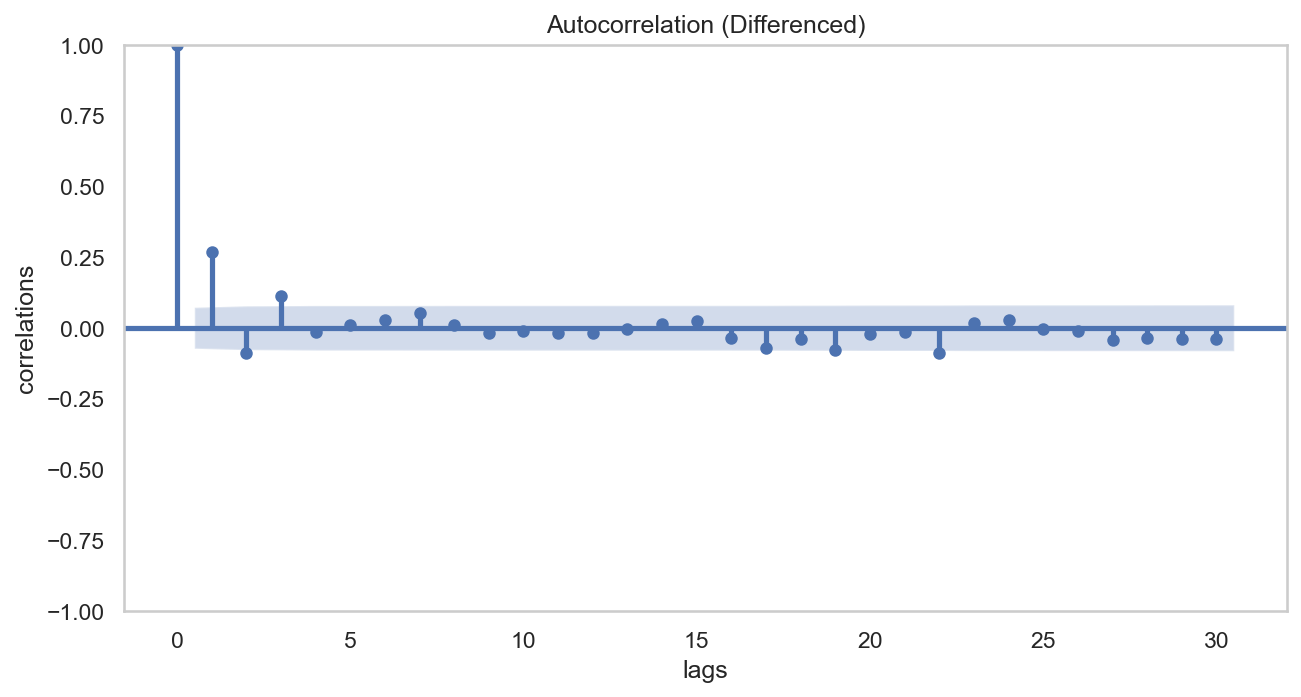

In [43]:
ax = plot_acf(x=prep_df.Revenue, lags=30, title="Autocorrelation (Original)")
plt.grid(False)
_ = plt.xlabel("lags")
_ = plt.ylabel("correlations")

ax = plot_acf(x=prep_df.RevenueDiff, lags=30, title="Autocorrelation (Differenced)")
plt.grid(False)
_ = plt.xlabel("lags")
_ = plt.ylabel("correlations")


##### PACF
Partial Autocorrelation quickly moves close to 0 for differenced data

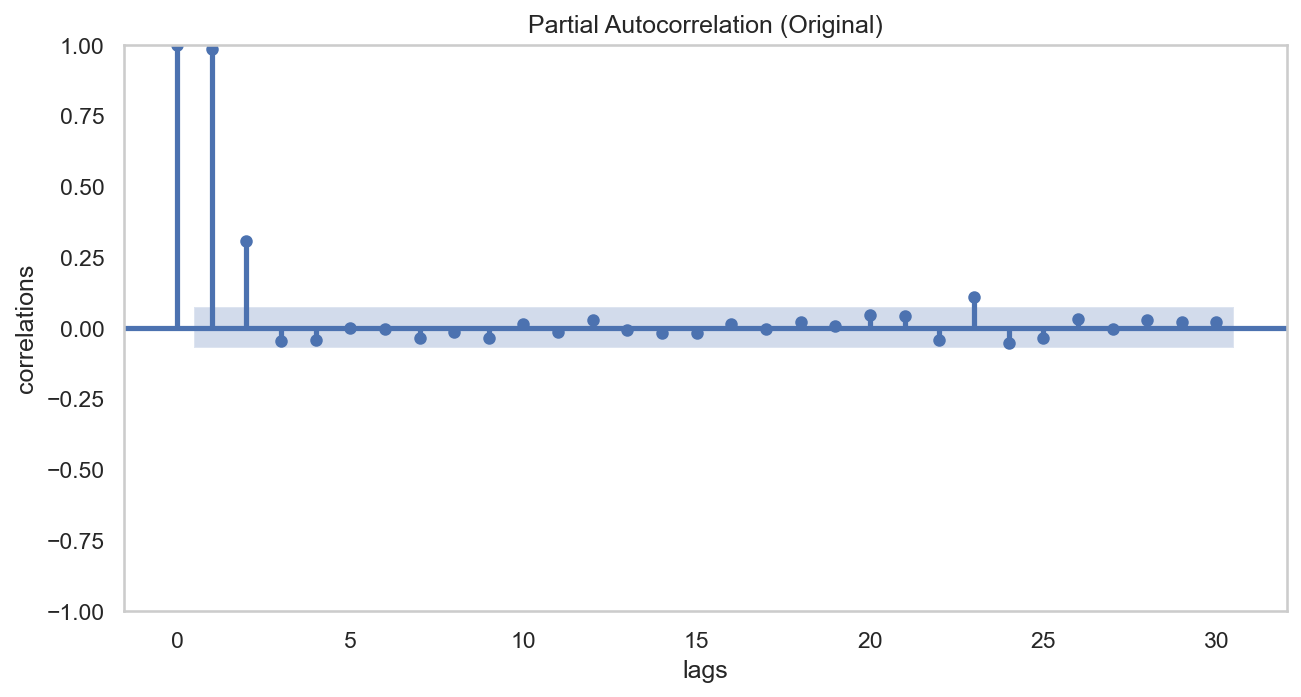

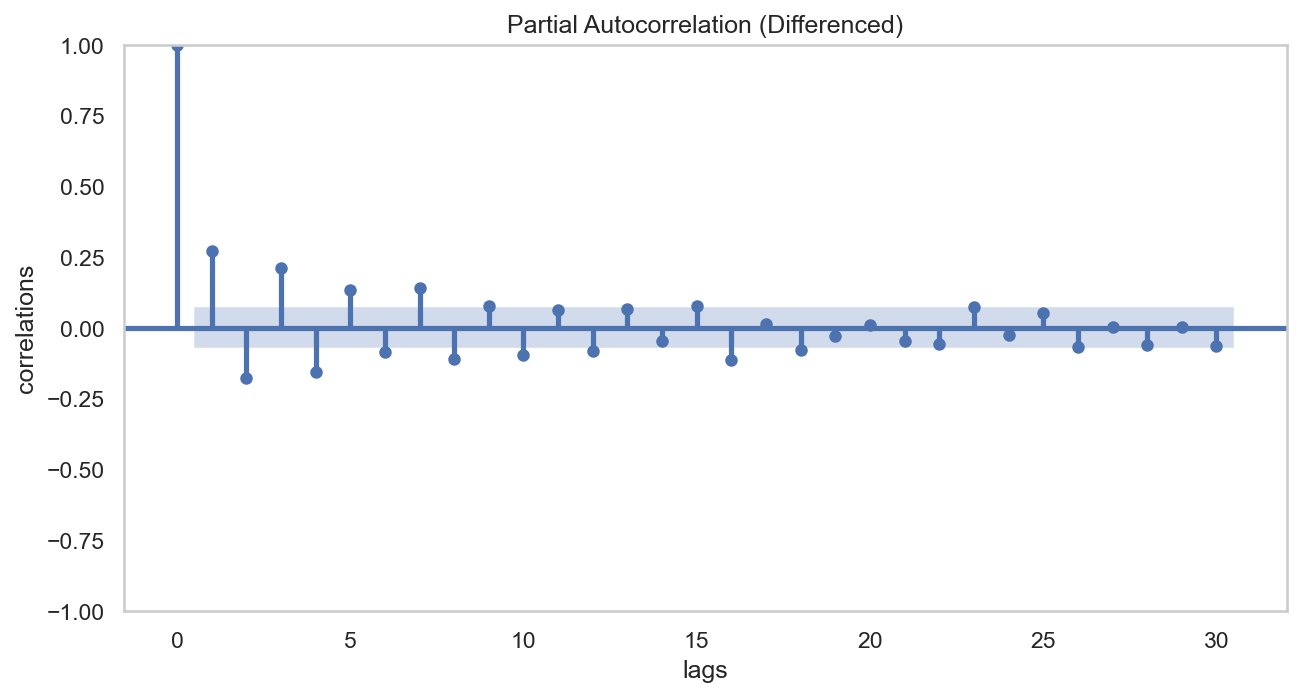

In [44]:
ax = plot_pacf(x=prep_df.Revenue, lags=30, title="Partial Autocorrelation (Original)")
plt.grid(False)
_ = plt.xlabel("lags")
_ = plt.ylabel("correlations")

ax = plot_pacf(
    x=prep_df.RevenueDiff, lags=30, title="Partial Autocorrelation (Differenced)"
)
plt.grid(False)
_ = plt.xlabel("lags")
_ = plt.ylabel("correlations")


### ✅ 4.  Explain the steps used to prepare the data for analysis, including the training and test set split.

#### Step 1. The first data preparation step was to import the timeseries data from CSV into pandas dataframe.

#### Step 2. Next we performed Exploratory Data Analysis to better understand the dataset as well as detect null and duplicate values. Furthermore, we visualized 12 month rolling statistics such as mean, standard deviation and variance. Lastly we visualized the difference and percentage of change between a data points and its lag 1.

#### Step 3. Additionally we transformed the Day dimension into a DatetimeIndex to so that the data better aligns with a datetime structure.

#### Step 4. From there we used the Augmented Dickey-Fuller Test and the Autocorrelation Function to detect non-stationarity.

#### Step 5. After discovering the dataset was not stationary, we utilized differencing to make the data stationary.
Differencing:  Is a method of transforming time series to remove temporal dependence like trends and 
seasonality and helps stabilize the mean of the time series.  It computes the differences between consecutive observations by subtracting the previous observation from the current observation (Brownlee, 2020). In this time series data, only one order of difference is required to coerce stationarity. Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality. 

RevenueDiff
Date                   
2019-01-01         0.00
2019-01-02         0.00
2019-01-03         0.83
2019-01-04         0.32
2019-01-05         0.26

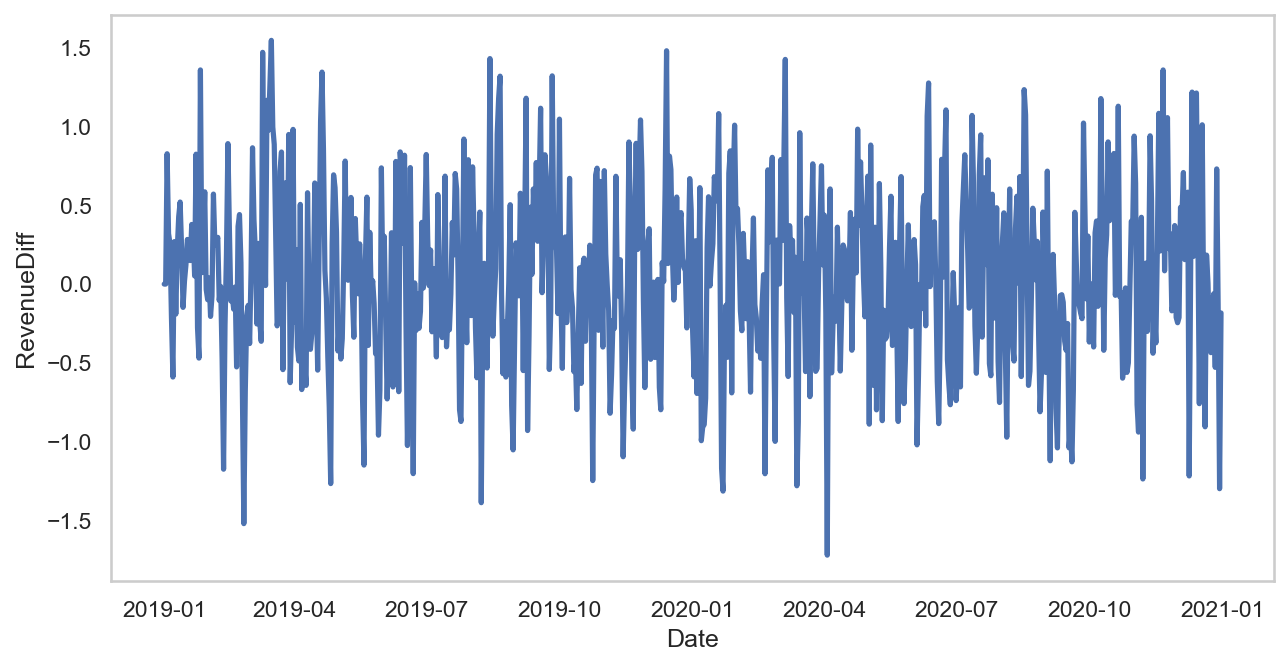

In [45]:
prep_df[["RevenueDiff"]].head()

ax = sns.lineplot(data=prep_df.reset_index(), x="Date", y="RevenueDiff")
plt.grid(False)
plt.show()


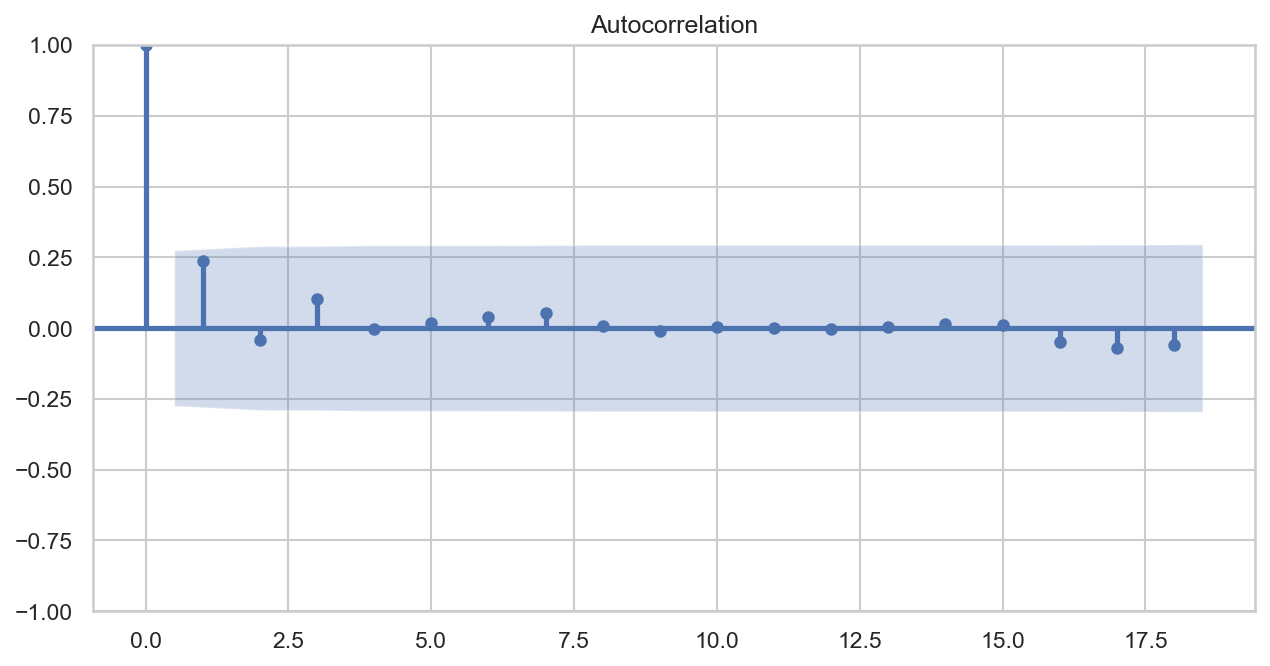

In [46]:
# For a stationary Time Series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly.

acf_2 = pd.DataFrame(acf(prep_df.RevenueDiff, nlags=50), columns=["autocorrelation"])
acf_2.index.name = "lag"

ax = plot_acf(x=acf_2)


#### Step 6. Lastly, we split the data into training and test sets. 80% of the records were dedicated for training and the other 20% were saved for testing.

In [47]:
X = prep_df.index
y = prep_df.Revenue


In [48]:
# split the data but disable shuffling to retain time series
# y_train is the first 80% of the time series, y_testis the last 20% of the time series
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=False
)

prep_train_df = pd.DataFrame(zip(X_train, y_train), columns=["Date", "Revenue"])
prep_train_df["RevenueDiff"] = prep_train_df.Revenue.diff(periods=1).fillna(0)
prep_train_df.index = prep_train_df.Date

prep_test_df = pd.DataFrame(zip(X_test, y_test), columns=["Date", "Revenue"])
prep_test_df["RevenueDiff"] = prep_test_df.Revenue.diff(periods=1).fillna(0)
prep_test_df.index = prep_test_df.Date


In [65]:
prep_df
prep_train_df
prep_test_df


Day  Revenue  Rolling Mean  Rolling Std.  Rolling Variance  \
Date                                                                       
2019-01-01   1.00     0.00          0.00          0.00              0.00   
2019-01-02   2.00     0.00          0.00          0.00              0.00   
2019-01-03   3.00     0.83          0.00          0.00              0.00   
2019-01-04   4.00     0.32          0.00          0.00              0.00   
2019-01-05   5.00     1.08          0.00          0.00              0.00   
...           ...      ...           ...           ...               ...   
2020-12-27 727.00    16.93         17.42          0.47              0.22   
2020-12-28 728.00    17.49         17.45          0.46              0.21   
2020-12-29 729.00    16.80         17.35          0.47              0.22   
2020-12-30 730.00    16.19         17.19          0.50              0.25   
2020-12-31 731.00    16.62         17.09          0.49              0.24   

            RevenueDiff  Pct Change  
Date                                 
2019-01-01         0.00        0.00  
2019-01-02         0.00         inf  
2019-01-03         0.83     1039.79  
2019-01-04         0.32       -0.61  
2019-01-05         0.26        2.38  
...                 ...         ...  
2020-12-27        -0.53        0.01  
2020-12-28         0.73        0.03  
2020-12-29        -0.13       -0.04  
2020-12-30        -1.30       -0.04  
2020-12-31        -0.18        0.03  

[731 rows x 7 columns]

Date  Revenue  RevenueDiff
Date                                       
2019-01-01 2019-01-01     0.00         0.00
2019-01-02 2019-01-02     0.00         0.00
2019-01-03 2019-01-03     0.83         0.83
2019-01-04 2019-01-04     0.32         0.32
2019-01-05 2019-01-05     1.08         0.26
...               ...      ...          ...
2020-08-02 2020-08-02    13.94         0.27
2020-08-03 2020-08-03    14.05         0.45
2020-08-04 2020-08-04    13.52        -0.42
2020-08-05 2020-08-05    13.08        -0.97
2020-08-06 2020-08-06    13.50        -0.02

[584 rows x 3 columns]

Date  Revenue  RevenueDiff
Date                                       
2020-08-07 2020-08-07    13.68         0.00
2020-08-08 2020-08-08    13.15         0.00
2020-08-09 2020-08-09    13.31        -0.37
2020-08-10 2020-08-10    12.67        -0.49
2020-08-11 2020-08-11    13.66         0.35
...               ...      ...          ...
2020-12-27 2020-12-27    16.93        -0.53
2020-12-28 2020-12-28    17.49         0.73
2020-12-29 2020-12-29    16.80        -0.13
2020-12-30 2020-12-30    16.19        -1.30
2020-12-31 2020-12-31    16.62        -0.18

[147 rows x 3 columns]

### ✅ 5.  Provide a copy of the cleaned dataset.

In [68]:
prep_df[["Revenue", "RevenueDiff"]].to_csv("./teleco_time_series_prepared.csv", index=True)
prep_train_df.to_csv("./teleco_time_series_prepared_train.csv", index=False)
prep_test_df.to_csv("./teleco_time_series_prepared_test.csv", index=False)


# Part IV:  Model Identification and Analysis
## D.  Analyze the time series dataset by doing the following:

### ✅ 1.  Report the annotated findings with visualizations of your data analysis, including the following elements:

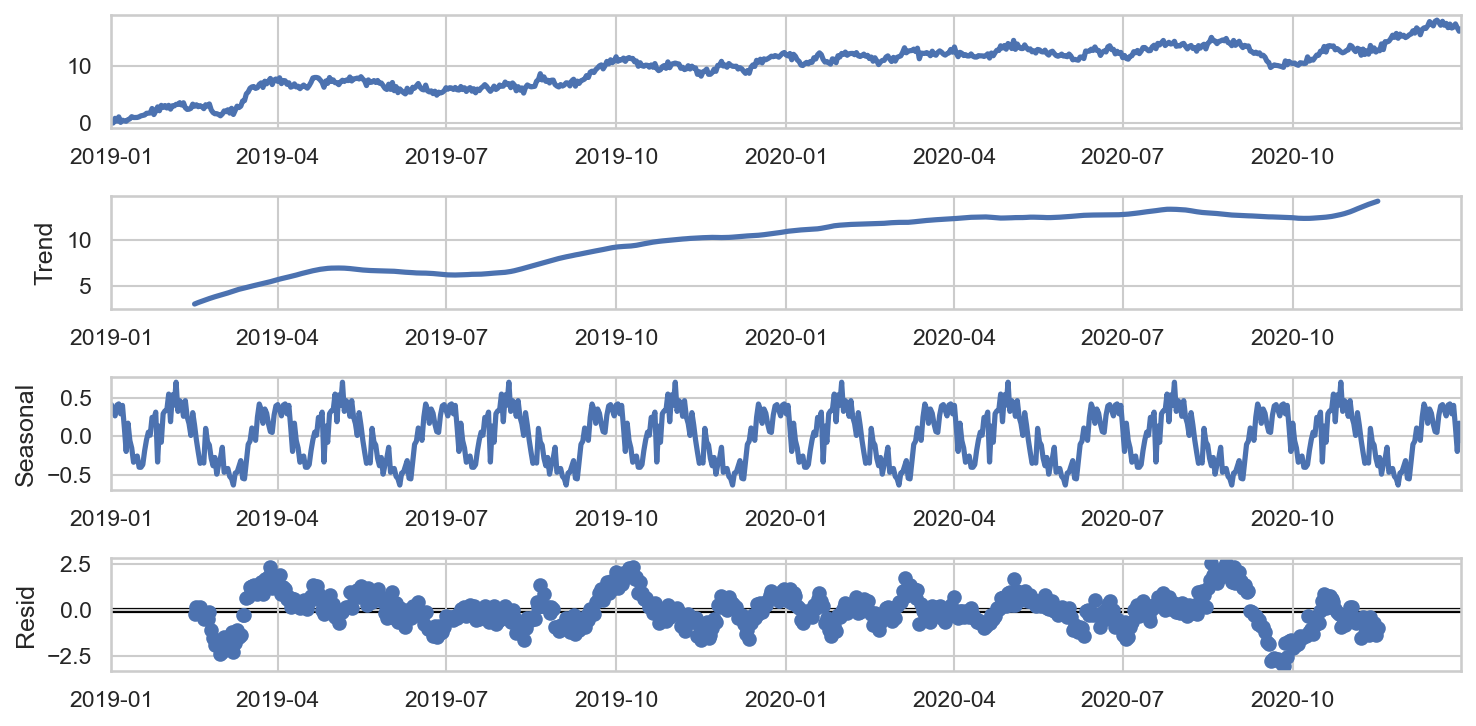

In [69]:
# Decomposing Time Series means splitting Time Series  data into its 3 components: Trend, Seasonality, and Residual. It provides a visual summary of the components and helps detect the presence or the lack of these components .
decomp = seasonal_decompose(x=prep_df[["Revenue"]], period=90)

ax = decomp.plot()
plt.show()


#### ✅ A. Seasonality

The Presence or lack of a seasonal component
- Seasonality: the presence or lack of a seasonal component: Seasonality refers to cycles that repeat regularly over time as shown below.
- That cycle can be daily, weekly, monthly, quarterly, yearly, etc.
- The cycle structure is considered seasonal if it repeats at the same frequency.

Plot and display time series showing seasonal component.


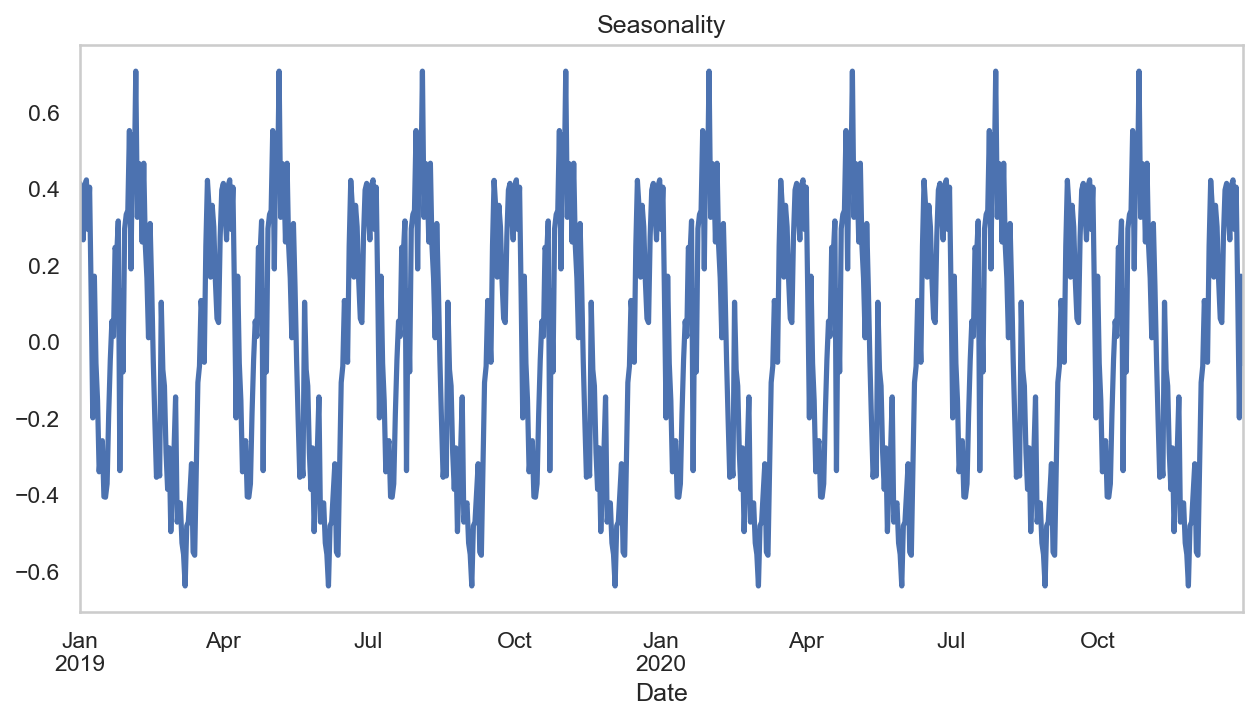

In [70]:
_ = plt.title("Seasonality")
_ = decomp.seasonal.plot()
plt.grid(False)
plt.show()


#### ✅ B. Trends
The trend of a time series can be determined by analyzing the overall direction of the series over a period. It can be upward or downward. 


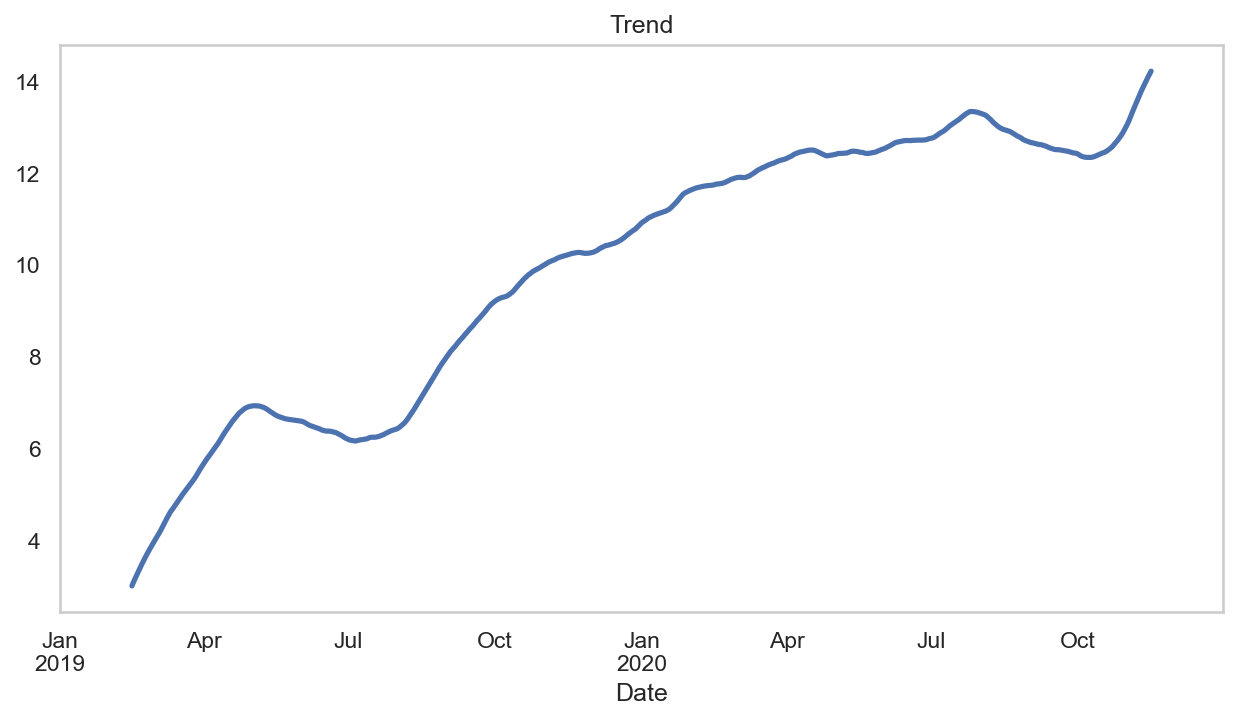

In [71]:
_ = plt.title("Trend")
_ = decomp.trend.plot()
plt.grid(False)
plt.show()


#### ✅ C. Auto Correlation Function
What is Autocorrelation?
Autocorrelation is the correlation of a single time series with a lagged copy of itself. It's also called "serial correlation". Often, when we refer to a series's autocorrelation, we mean the "lag-one" autocorrelation. So when using daily data, for example, the autocorrelation would be the correlation of the series with the same series lagged by one day.

**Interpretation of Autocorrelation**
- What does it mean when a series has a positive or negative autocorrelation? With financial time series, when returns have a negative autocorrelation, we say it is "mean reverting".
- Alternatively, if a series has positive autocorrelation, we say it is "trend-following".


1. Autocorrelation Function
The sample autocorrelation function, or ACF,

2. Autocorrelation Function
shows not only the lag-one autocorrelation from the last chapter, but the entire autocorrelation function for different lags. Any significant non-zero autocorrelations implies that the series can be forecast from the past.

3. ACF Example 1: Simple Autocorrelation Function
This autocorrelation function implies that you can forecast the next value of the series from the last two values, since the lag-one and lag-two autocorrelations differ from zero.

4. ACF Example 2: Seasonal Earnings
Consider the time series of quarterly earnings of the company H&R Block. As we mentioned last chapter, a vast majority of their earnings occurs in the quarter that taxes are due. In this case, you can clearly see a seasonal pattern in the quarterly data on the left, and the autocorrelation function on the right shows strong autocorrelation at lags 4, 8, 12, 16, and 20

5. ACF Example 3: Useful for Model Selection
The ACF can also be useful for selecting a parsimonious model for fitting the data. In this example, the pattern of the autocorrelation suggests a model for the series that will be discussed in the next chapter.

6. Plot ACF in Python
plot_acf is the statsmodels function for plotting the autocorrelation function. The input x is a series or array. The argument lags indicates how many lags of the autocorrelation function will be plotted. The alpha argument sets the width of the confidence interval, which is discussed on the next slide.

7. Confidence Interval of ACF
Here is an ACF plot that contains confidence intervals for each lag, which is the blue region in the figure.

8. Confidence Interval of ACF
In plot_acf, the argument alpha determines the width of the confidence intervals. For example, if alpha equals 0-point-05, that means that if the true autocorrelation at that lag is zero, there is only a 5% chance the sample autocorrelation will fall outside that window. You will get a wider confidence interval if you set alpha lower, or if you have fewer observations. An approximation to the width of the 95% confidence intervals, if you make some simplifying assumptions, is plus or minus 2 over the square root of the number of observations in your series. Incidentally, if you don't want to see confidence intervals in your plot, set alpha equal to one.

9. ACF Values Instead of Plot
Besides plotting the ACF, you can also extract its numerical values using a similar Python function, acf, instead of plot_acf.

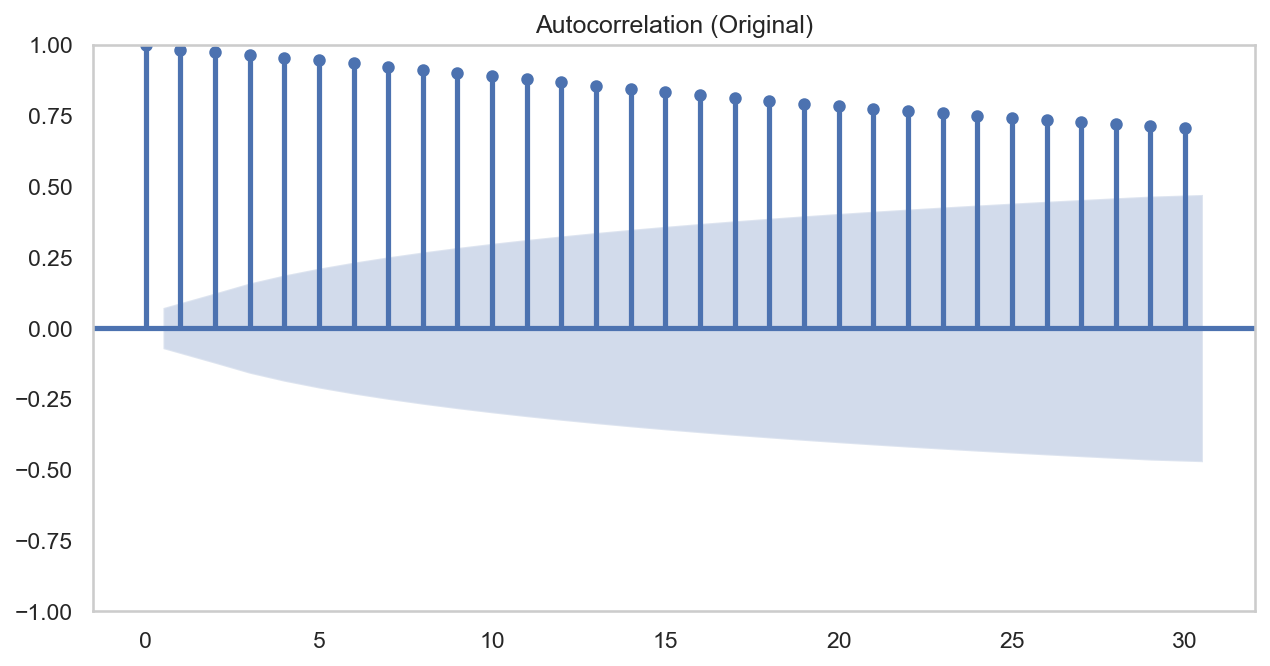

In [72]:
ax = plot_acf(x=prep_df.Revenue, lags=30, title="Autocorrelation (Original)")
plt.grid(False)


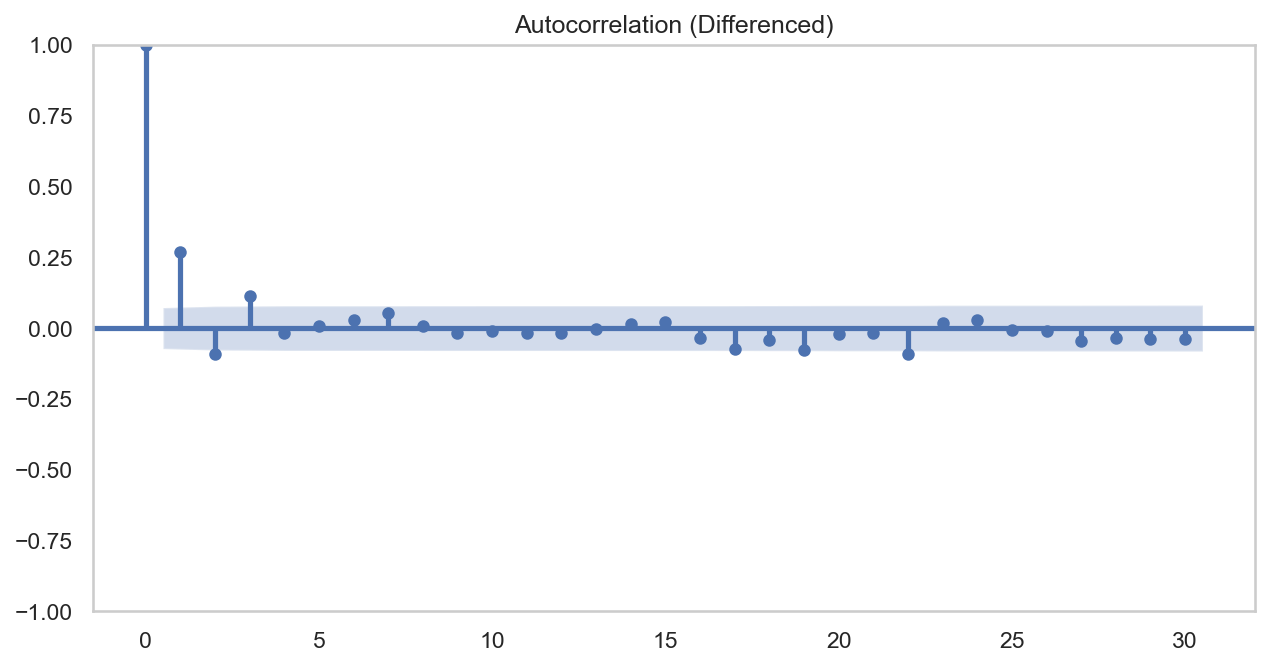

In [73]:
ax = plot_acf(x=prep_df["RevenueDiff"], lags=30, title="Autocorrelation (Differenced)")
plt.grid(False)
plt.show()


#### ✅ C. Partial Auto Correlation Function

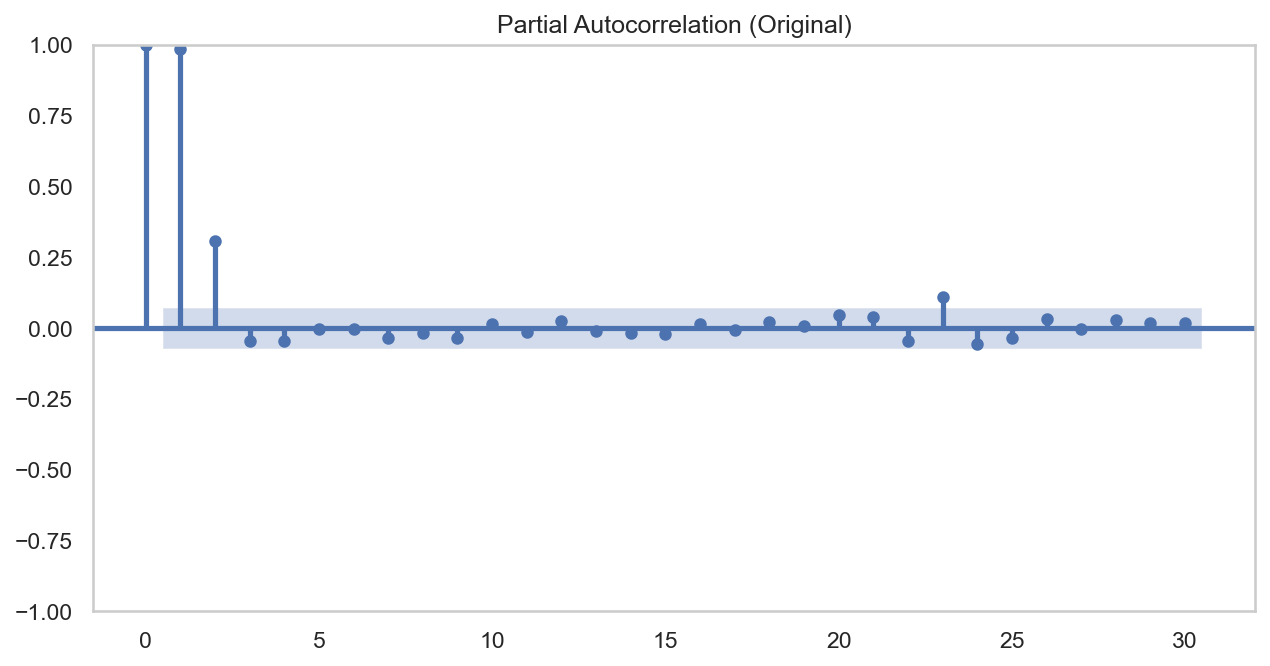

In [74]:
ax = plot_pacf(x=prep_df.Revenue, lags=30, title="Partial Autocorrelation (Original)")
plt.grid(False)


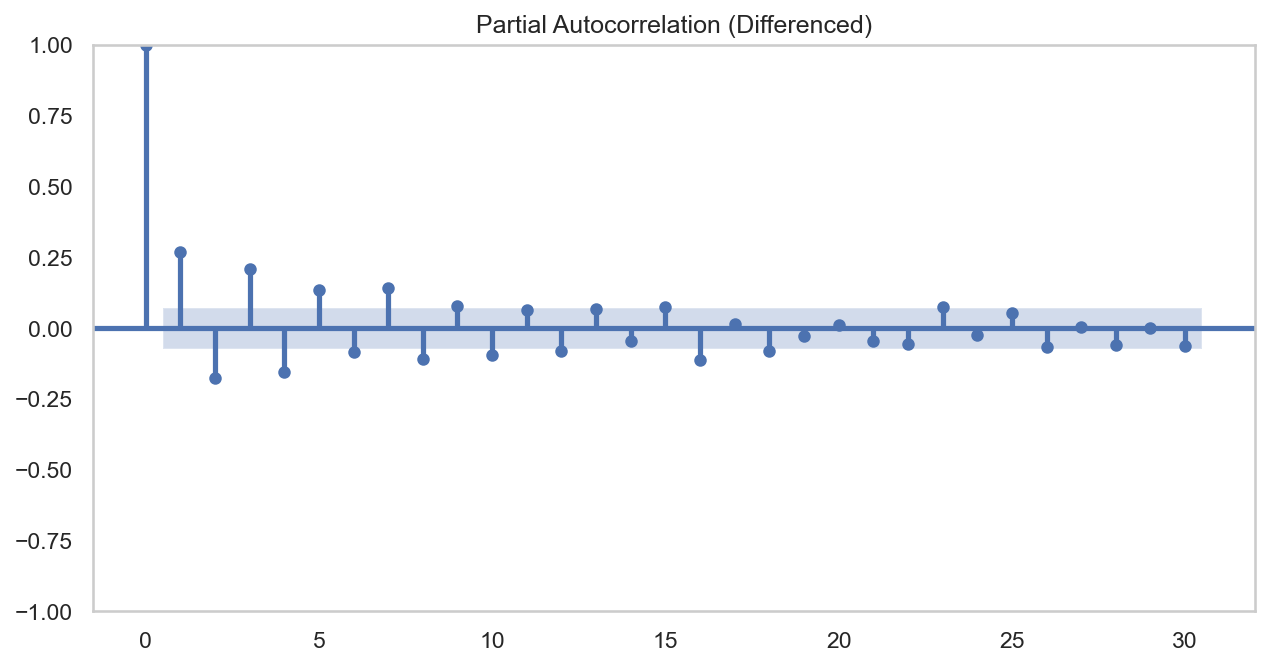

In [75]:
ax = plot_pacf(
    x=prep_df.RevenueDiff, lags=30, title="Partial Autocorrelation (Differenced)"
)
plt.grid(False)


#### ✅ D. Spectral Density

Spectra Density is a graph that shows frequencies related to the autocovariance time domain. It represents the frequency domain of a time series and is directly related to the autocovariance time-domain representation. The “frequency” is the number of observations before the seasonal pattern repeats. Autocovariance is simply the covariance between two elements in the series.

**Why Spectral Density?** <br />
Time Series sometimes shows periodic behavior which can be difficult to understand. So, you do Spectral analysis to discover underlying periodicities. 
You do so by transforming the data from the time domain to the frequency domain. 
The covariance of the time series can be represented by a function called spectral density, which is estimated using the squared correlation between the time series and sine/cosine waves at different frequencies spanned by the series (Jones, 2018).

Periodicity is the fact of something happening at regularly-spaced periods of time. An example of periodicity is the full moon happening every 29.5 days.

**Interpretation of Spectral Density** <br />
In data science, periodicity is a pattern (trend) in a time series that occurs at regular time intervals.  If the time intervals at which the pattern repeats itself can't be precisely defined and are not constant the time series is said to be cyclical.

Power Spectral Density and Power Spectrum refer to the same thing – time and the variance between the previous and current time periods (covariance). This time signal is indicated on the Y-axis of the graph.

The X-axis represents the frequencies which are the number of observations before the seasonal pattern repeats.
 
When you transform the Power Spectral Density to the frequency, it shows a curve that is described as the spectral density.  

The Y-axis assigns value to the covariance between two elements (signals) in the series known as autocovariance. Please read more about the Y and X axes interpretation here.

Jones, J. (2018, February 19). Time Series and Spectral Analysis. Standford. Retrieved January 10, 2022, 
from https://web.stanford.edu/class/earthsys214/notes/series.html

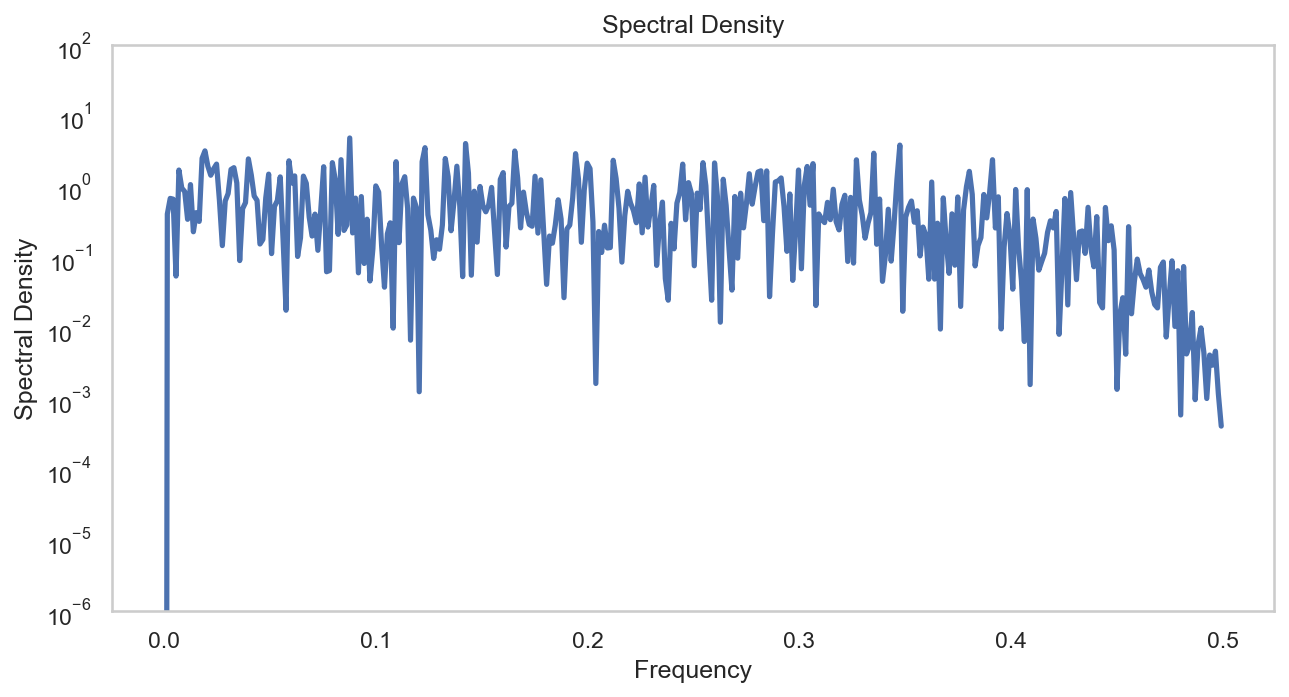

In [76]:
# Estimate power spectral density using a periodogram.
# f = Array of sample frequencies.
# Pxx_den = Power spectral density or power spectrum of `x`.
f, Pxx_den = signal.periodogram(x=prep_df.RevenueDiff)

# Make a plot with log scaling on the y axis.
_ = plt.semilogy(f, Pxx_den)

# min y: 10^-6
# max y: 10^2
_ = plt.ylim([1e-6, 1e2])
_ = plt.title("Spectral Density")
_ = plt.xlabel("Frequency")
_ = plt.ylabel("Spectral Density")
plt.grid(False)
plt.show()


#### ✅ E. Decomposed Time Series

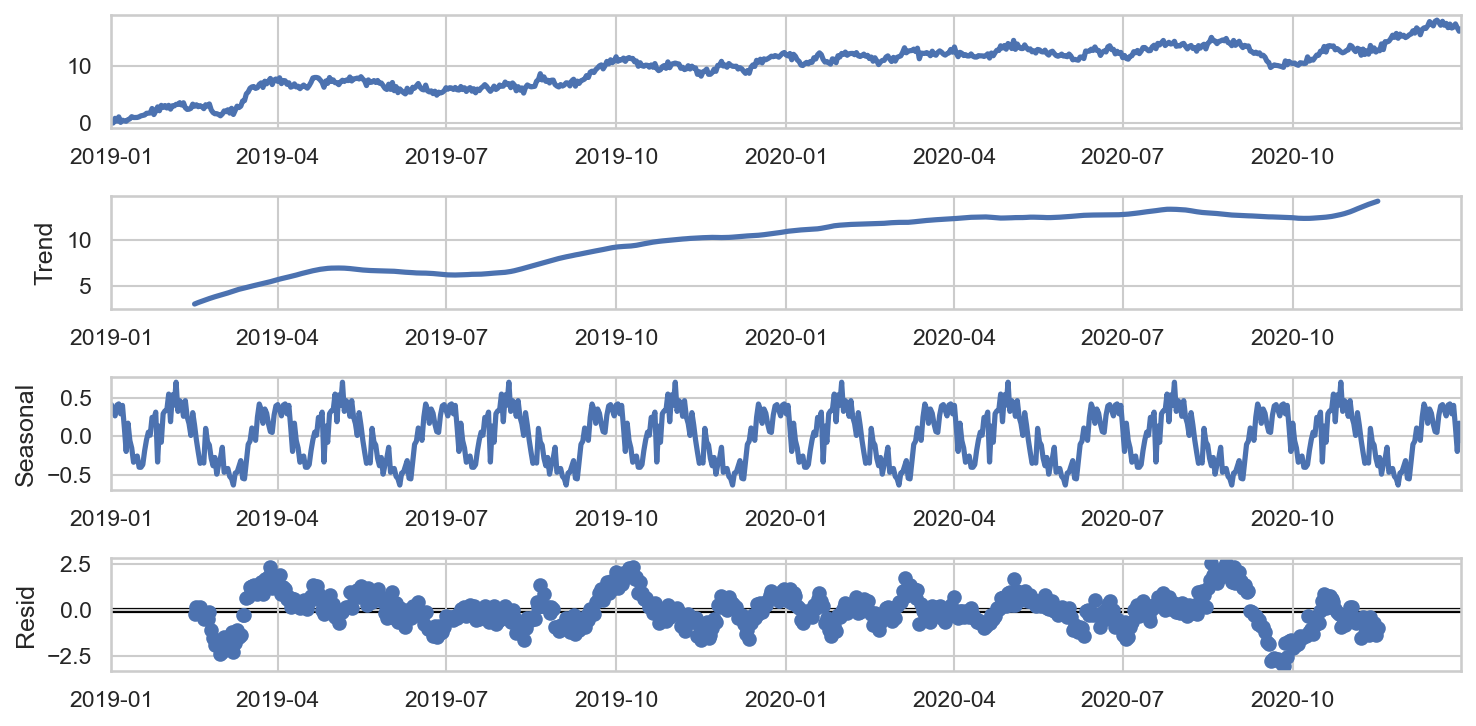

In [77]:
# Decomposing Time Series means splitting Time Series data into its 3 components: Trend, Seasonality, and Residual. It provides a visual summary of the components and helps detect the presence or the lack of these components .

ax = seasonal_decompose(x=prep_df[["Revenue"]], period=90).plot()


##### Durbin Watson Statistic
The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical model or regression analysis. The Durbin-Watson statistic will always have a value ranging between 0 and 4. A value of 2.0 indicates there is no autocorrelation detected in the sample. Values from 0 to less than 2 point to positive autocorrelation and values from 2 to 4 means negative autocorrelation.

A stock price displaying positive autocorrelation would indicate that the price yesterday has a positive correlation on the price today—so if the stock fell yesterday, it is also likely that it falls today. A security that has a negative autocorrelation, on the other hand, has a negative influence on itself over time—so that if it fell yesterday, there is a greater likelihood it will rise today.

- This statistic will always be between 0 and 4.
- The closer to 0 the statistic, the more evidence for positive serial correlation.
- The closer to 4, the more evidence for negative serial correlation.

https://www.investopedia.com/terms/d/durbin-watson-statistic.asp

In [78]:
# The null hypothesis of the test is that there is no serial correlation in the residuals.
durbin_watson(resids=decomp.resid.fillna(0))

# positive autocorrelation detected


0.2807278291338831

#### ✅ F. Confirmation of the lack of trends in the residuals of the decomposed series

Residuals
- The residual of the decomposed time series is the time series after the trend and seasonality components are removed.

No trend detected in the residuals

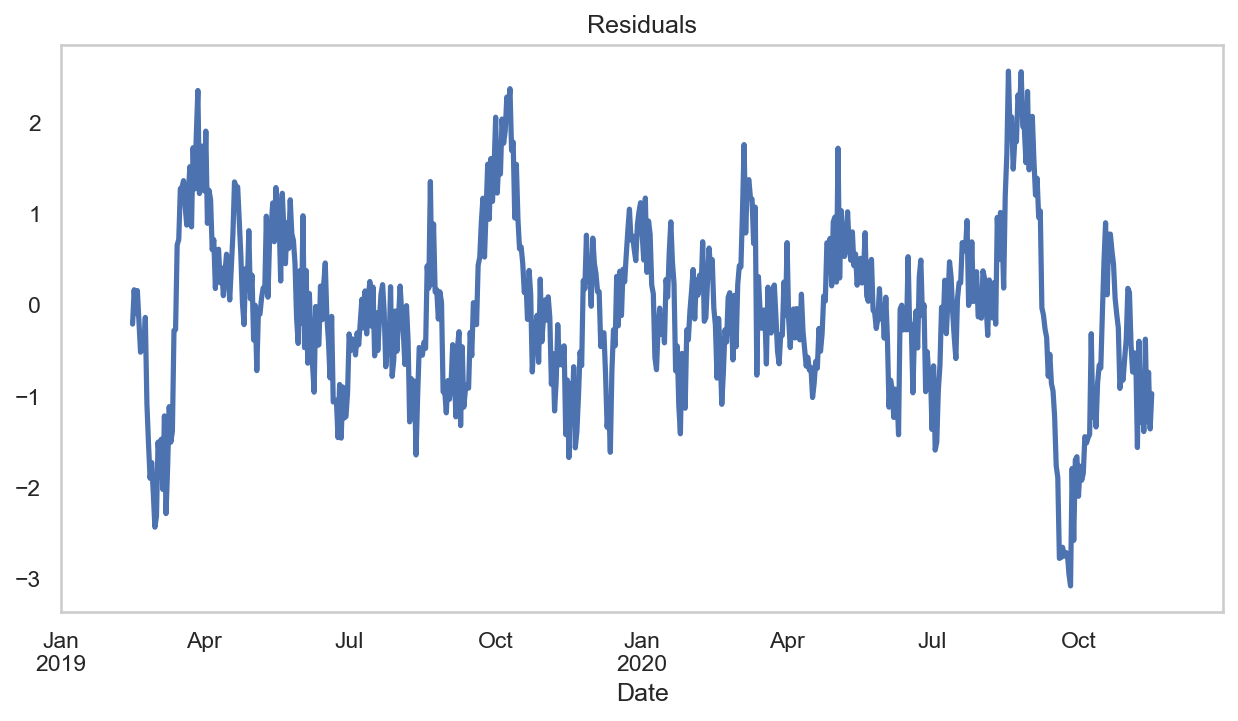

In [79]:
_ = plt.title("Residuals")
_ = decomp.resid.plot()
plt.grid(False)
plt.show()


'mean'

-0.034999101966425715

'variance'

0.8824304593556336

<AxesSubplot:xlabel='resid', ylabel='Count'>

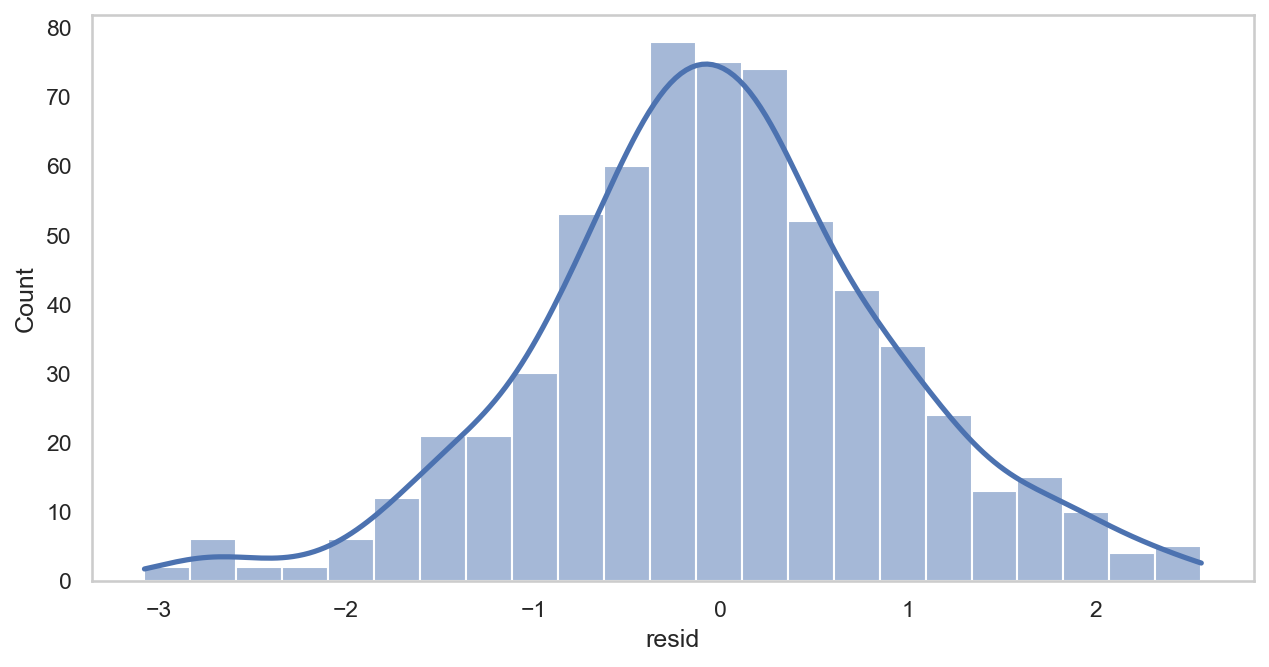

In [80]:
display("mean", decomp.resid.mean())
display("variance", decomp.resid.var())

sns.histplot(decomp.resid, kde=True)
plt.grid(False)



### ✅ 2.  Identify an autoregressive integrated moving average (ARIMA) model that takes into account the observed trend and seasonality of the time series data.


#### Auto ARIMA (All Original Data) - 983
Lowest AIC is 983 with order (1, 1, 0).


In [81]:
def test_forecast(model, y, test_data, all_data, n_periods=90, start=1):
    print(f"Lowest AIC is {round(model.aic())} with order {model.order}.", end="\n\n")

    model.fit(y)
    display(model.summary())

    model = ARIMA(endog=y, order=model.order).fit()

    prediction = model.get_prediction(start=n_periods)

    mean_prediction = prediction.predicted_mean

    confidence_intervals = prediction.conf_int()

    lower_limits = confidence_intervals.loc[:, "lower Revenue"]

    upper_limits = confidence_intervals.loc[:, "upper Revenue"]

    # test data
    plt.plot(test_data, label="observed test set", color="blue")
    plt.plot(mean_prediction.index, mean_prediction, label="forecast", color="red")

    plt.fill_between(lower_limits.index, lower_limits, upper_limits, color="pink")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Revenue (in Millions $USD")
    plt.title("Forecast comparing with test data")
    plt.grid(False)
    plt.show()

    # test and train data
    plt.plot(y, label="observed train set", color="blue")
    plt.plot(test_data, label="observed test set", color="blue")
    plt.plot(mean_prediction.index, mean_prediction, label="forecast", color="red")

    plt.fill_between(lower_limits.index, lower_limits, upper_limits, color="pink")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Revenue (in Millions $USD")
    plt.title("Forecast comparing with test data")
    plt.grid(False)
    plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=987.305, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1162.819, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=983.122, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1019.369, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1162.139, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=985.104, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=985.106, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=986.045, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=984.710, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.308 seconds
Lowest AIC is 983 with order (1, 1, 0).



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -488.561
Date:                Wed, 21 Sep 2022   AIC                            983.122
Time:                        00:03:55   BIC                            996.901
Sample:                    01-01-2019   HQIC                           988.438
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0332      0.018      1.895      0.058      -0.001       0.068
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.000       0.199       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.96   Prob(JB):                         0.36
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.85   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

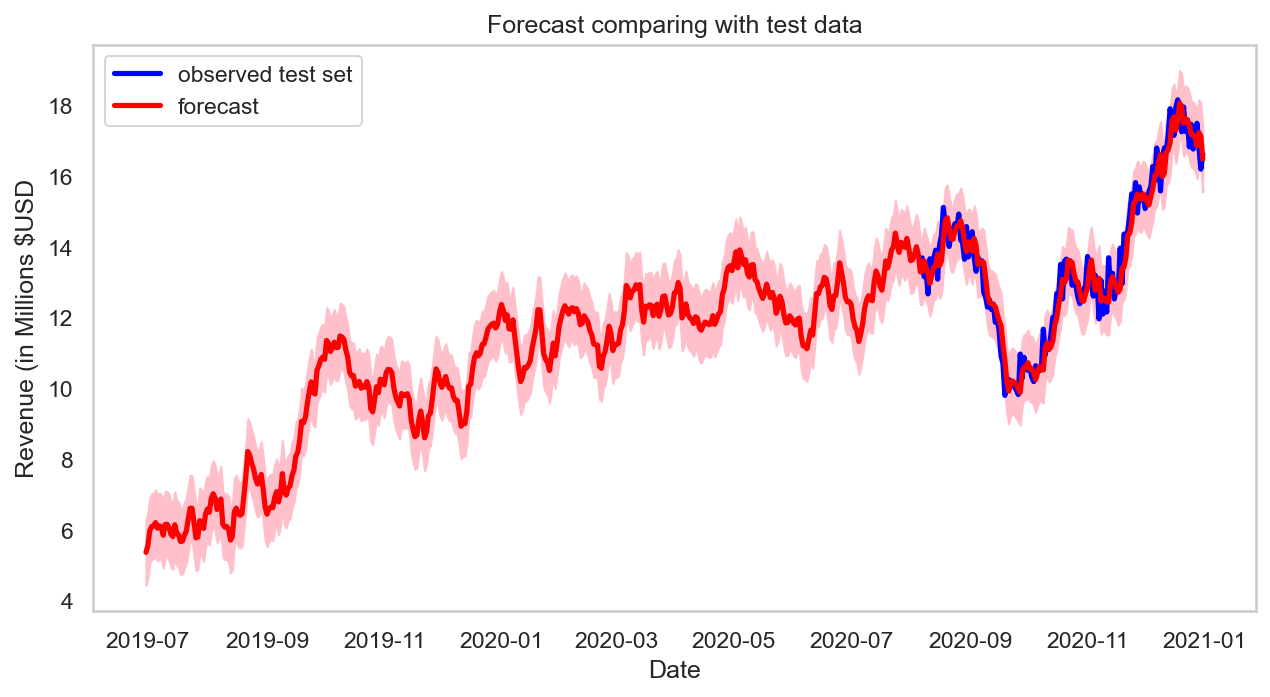

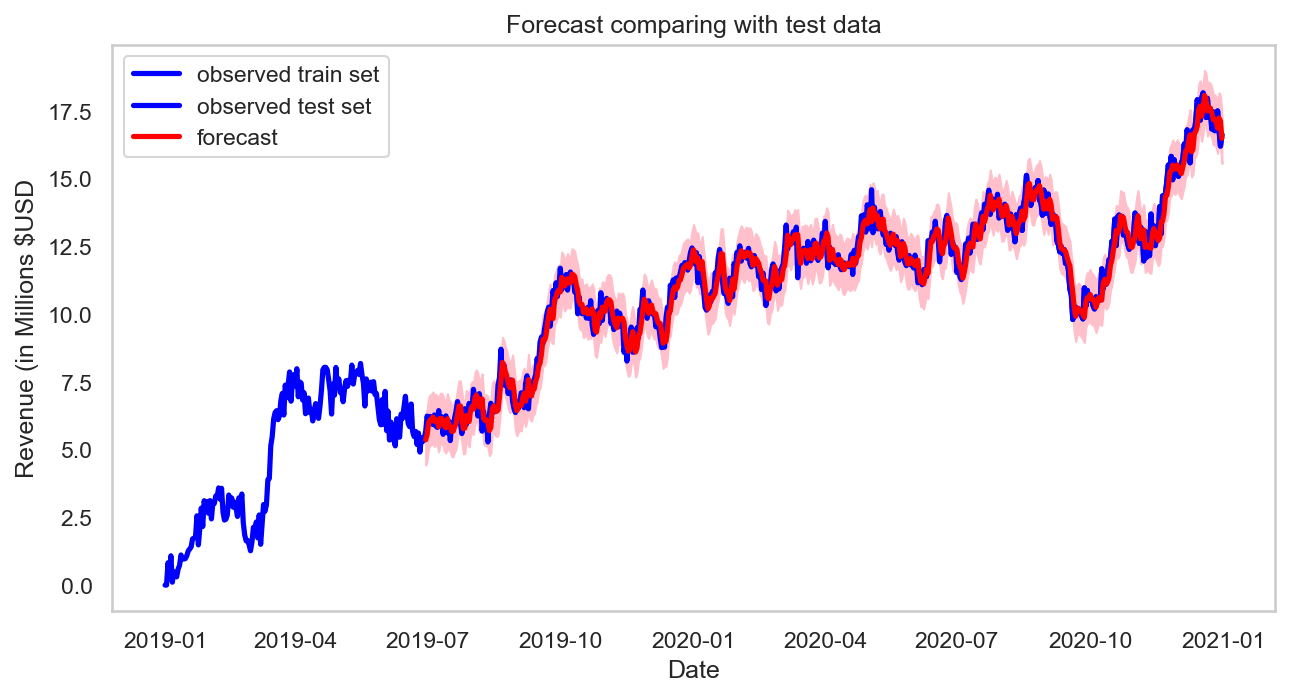

In [82]:
# Run various order combinations for AR and MA models to find the model with the lowest AIC score.
y = prep_df["Revenue"]
m = pm.auto_arima(
    y=y,
    m=1,
    information_criterion="aic",
    stationary=False,
    trace=True,
    n_jobs=-1,
    stepwise=True,
)

test_forecast(
    model=m,
    y=y,
    test_data=prep_test_df["Revenue"],
    all_data=prep_df["Revenue"],
    n_periods=180,
)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=997.180, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4049.374, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3251.735, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5521.206, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=997.699, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=997.103, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1032.152, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=999.171, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=998.336, Time=0.67 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=996.232, Time=0.24 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1031.213, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -494.116
Date:                Wed, 21 Sep 2022   AIC                            996.232
Time:                        00:04:01   BIC                           1014.610
Sample:                    01-01-2019   HQIC                          1003.322
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5189      0.068      7.621      0.000       0.385       0.652
ar.L2          0.4805      0.068      7.065      0.000       0.347       0.614
ma.L1          0.0180      0.078      0.232      0.816      -0.134       0.170
sigma2         0.2242      0.013     17.762      0.000       0.199       0.249
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.04
Prob(Q):                              0.88   Prob(JB):                         0.36
Heteroskedasticity (H):               1.03   Skew:                            -0.02
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

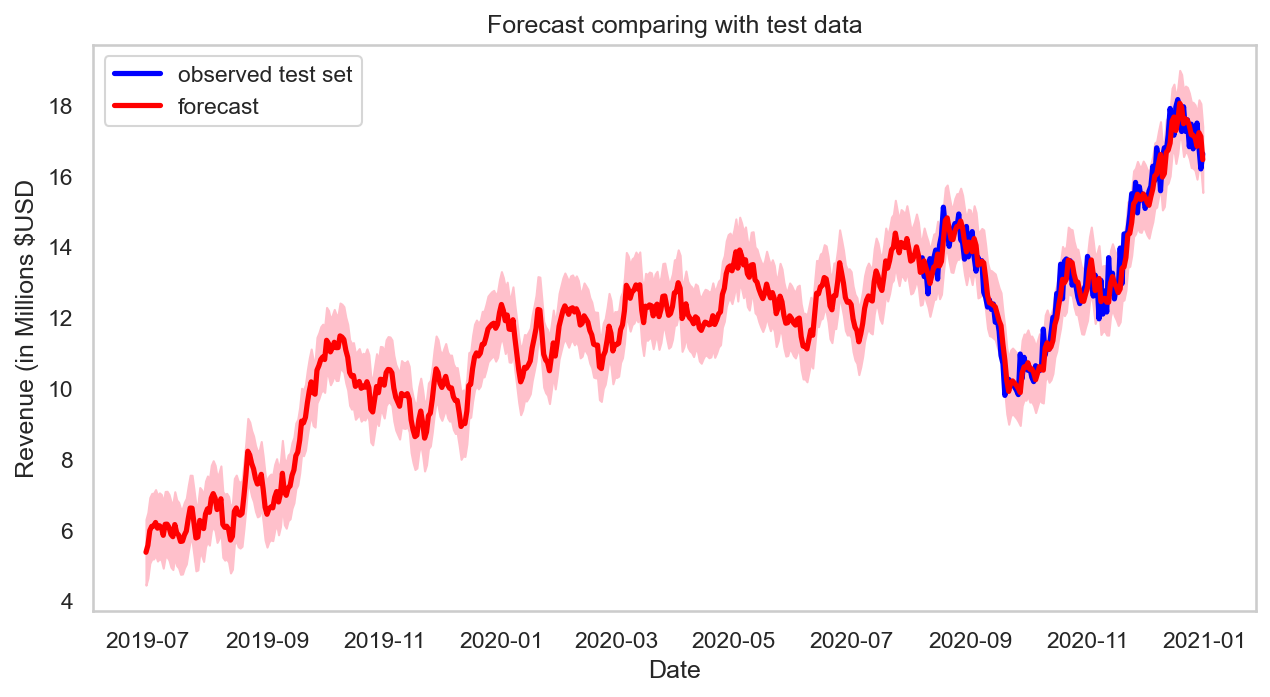

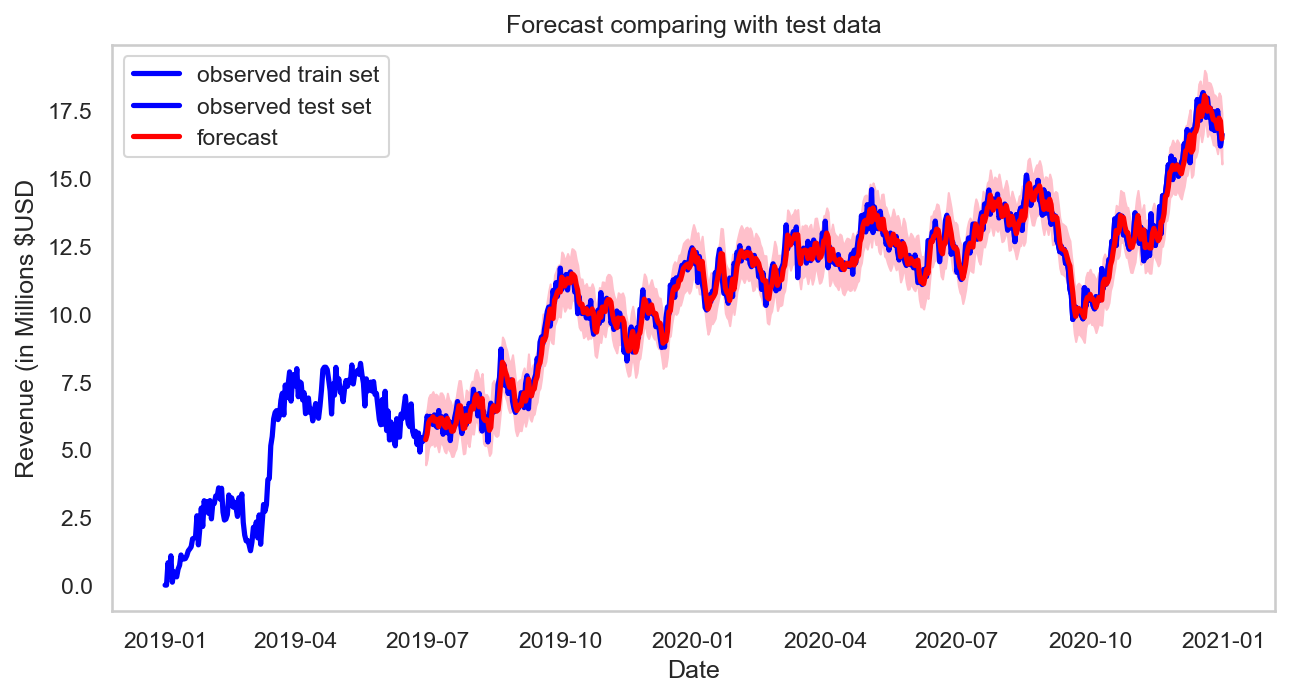

In [83]:
# Run various order combinations for AR and MA models to find the model with the lowest AIC score with differencing diff.
y = prep_df["Revenue"]
m = pm.auto_arima(
    y=y,
    m=1,
    d=0,
    information_criterion="aic",
    stationary=False,
    trace=True,
    n_jobs=-1,
    stepwise=True,
)


test_forecast(
    model=m,
    y=y,
    test_data=prep_test_df["Revenue"],
    all_data=prep_df["Revenue"],
    n_periods=180,
)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[2] intercept   : AIC=998.075, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[2] intercept   : AIC=4049.374, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[2] intercept   : AIC=1133.199, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[2] intercept   : AIC=2453.392, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[2]             : AIC=5521.206, Time=0.01 sec
 ARIMA(1,0,1)(0,0,1)[2] intercept   : AIC=998.916, Time=0.40 sec
 ARIMA(1,0,1)(1,0,0)[2] intercept   : AIC=996.237, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[2] intercept   : AIC=1032.152, Time=0.27 sec
 ARIMA(1,0,1)(2,0,0)[2] intercept   : AIC=998.120, Time=0.53 sec
 ARIMA(1,0,1)(2,0,1)[2] intercept   : AIC=1000.551, Time=0.81 sec
 ARIMA(0,0,1)(1,0,0)[2] intercept   : AIC=1117.074, Time=0.40 sec
 ARIMA(0,0,0)(1,0,0)[2] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,1)(1,0,0)[2]             : AIC=995.428, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[2]             : AIC=1031.213, Time=0.16 sec
 ARIMA(1,0,1)(2,0,0)[2]             : AIC=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  731
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 2)   Log Likelihood                -493.714
Date:                            Wed, 21 Sep 2022   AIC                            995.428
Time:                                    00:04:09   BIC                           1013.806
Sample:                                01-01-2019   HQIC                          1002.518
                                     - 12-31-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9995      0.001   1294.462      0.000       0.998       1.001
ma.L1         -0.4557      0.036    -12.616      0.000      -0.527      -0.385
ar.S.L2        0.2426      0.039      6.170      0.000       0.166       0.320
sigma2         0.2235      0.013     17.756      0.000       0.199       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.71   Prob(JB):                         0.34
Heteroskedasticity (H):               1.03   Skew:                            -0.02
Prob(H) (two-sided):                  0.80   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

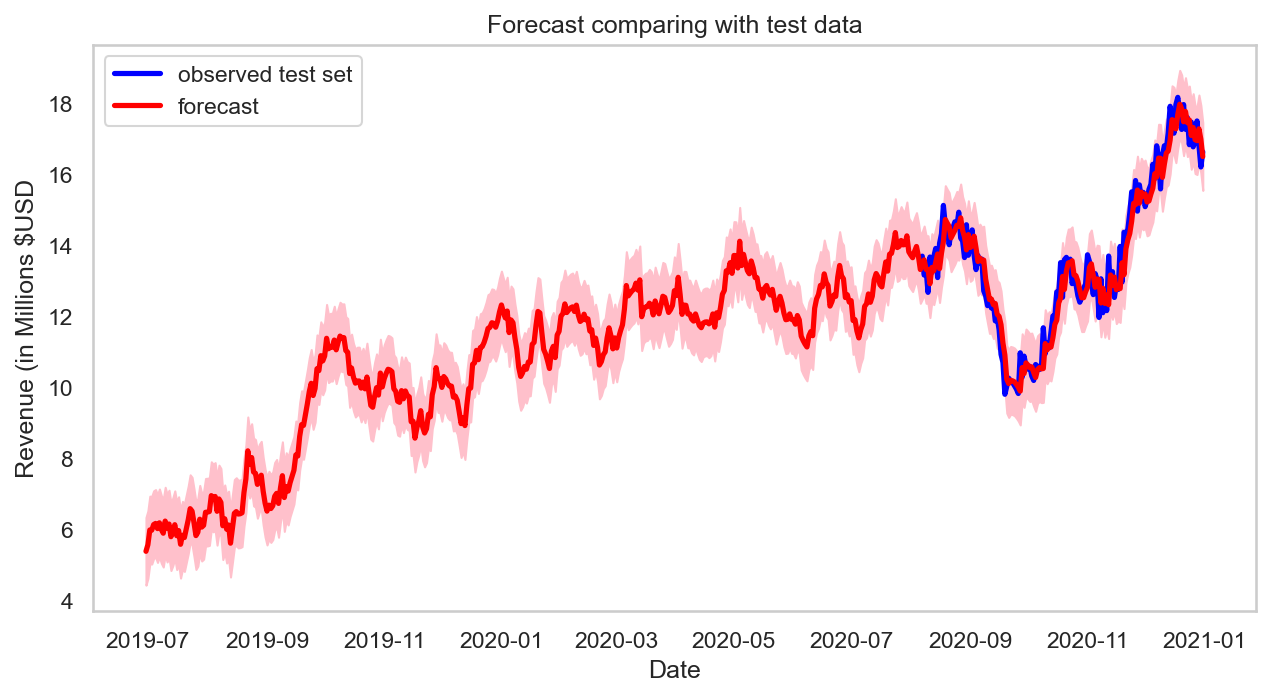

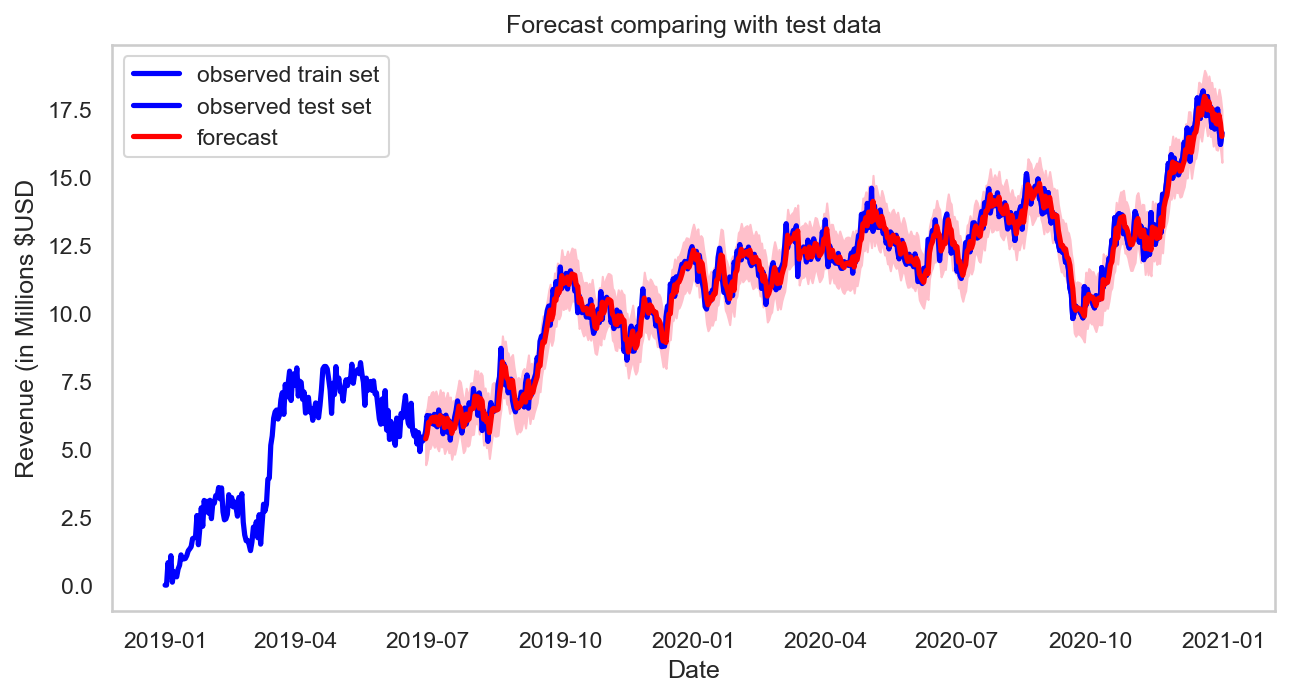

Performing stepwise search to minimize aic
 ARIMA(1,0,3)(1,0,1)[4] intercept   : AIC=1001.542, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=4049.374, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=2585.307, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=5521.206, Time=0.01 sec
 ARIMA(1,0,3)(0,0,1)[4] intercept   : AIC=998.653, Time=0.87 sec
 ARIMA(1,0,3)(0,0,0)[4] intercept   : AIC=997.674, Time=0.40 sec
 ARIMA(1,0,3)(1,0,0)[4] intercept   : AIC=998.604, Time=0.52 sec
 ARIMA(0,0,3)(0,0,0)[4] intercept   : AIC=2328.760, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[4] intercept   : AIC=997.699, Time=0.31 sec
 ARIMA(2,0,3)(0,0,0)[4] intercept   : AIC=998.628, Time=0.62 sec
 ARIMA(0,0,2)(0,0,0)[4] intercept   : AIC=2677.471, Time=0.22 sec
 ARIMA(2,0,2)(0,0,0)[4] intercept   : AIC=997.180, Time=0.81 sec
 ARIMA(2,0,2)(1,0,0)[4] intercept   : AIC=998.763, Time=0.64 sec
 ARIMA(2,0,2)(0,0,1)[4] intercept   : AIC=998

In [ ]:
# test different periods for seasonal diffing

for m in [2, 4, 12]:
    y = prep_df["Revenue"]
    m = pm.auto_arima(
        y=y,
        m=m,
        d=0,
        D=0,
        start_p=1,
        start_q=3,
        max_p=2,
        max_d=0,
        max_q=3,
        max_P=2,
        max_D=0,
        max_Q=3,
        information_criterion="aic",
        stationary=False,
        trace=True,
        n_jobs=-1,
        stepwise=True,
    )

    test_forecast(
        model=m,
        y=y,
        test_data=prep_test_df["Revenue"],
        all_data=prep_df["Revenue"],
        n_periods=180,
    )
    plt.show()


#### Auto ARIMA (Training Data) - 773
Lowest AIC is 773 with order (1, 1, 0).

In [ ]:
# Run various order combinations for AR and MA models to find the model with the lowest AIC score.
y = prep_train_df["Revenue"]
m = pm.auto_arima(
    y=y,
    m=1,
    information_criterion="aic",
    stationary=False,
    trace=True,
    n_jobs=-1,
    stepwise=True,
)

test_forecast(
    model=m,
    y=y,
    test_data=prep_test_df["Revenue"],
    all_data=prep_df["Revenue"],
    n_periods=180,
)


#### Auto ARIMA (All Differenced Original Data) - 983
Lowest AIC is 983 with order (1, 0, 0).


In [ ]:
# Run various order combinations for AR and MA models to find the model with the lowest AIC score.
y = prep_df["RevenueDiff"]
m = pm.auto_arima(
    y=y,
    m=1,
    information_criterion="aic",
    stationary=False,
    trace=True,
    n_jobs=-1,
    stepwise=True,
)

test_forecast(
    model=m,
    y=y,
    test_data=prep_test_df["RevenueDiff"],
    all_data=prep_df["RevenueDiff"],
    n_periods=180,
)


#### Auto ARIMA (Differenced Training Data) - 773
Lowest AIC is 773 with order (1, 0, 0).

In [ ]:
y = prep_train_df["RevenueDiff"]
m = pm.auto_arima(
    y=y,
    m=1,
    information_criterion="aic",
    stationary=False,
    trace=True,
    n_jobs=-1,
    stepwise=True,
)

test_forecast(
    model=m,
    y=y,
    test_data=prep_test_df["RevenueDiff"],
    all_data=prep_df["RevenueDiff"],
    n_periods=180,
)


### ✅ 3.  Perform a forecast using the derived ARIMA model.



In [ ]:
def ARIMA_forecast(
    y,
    test_data,
    all_data,
    y_label="Revenue",
    n_periods=90,
    start=1,
    steps=1,
    title="Forecast comparing with test data",
    predictions=False,
):
    model = ARIMA(endog=y, order=(1, 1, 0), seasonal_order=(0, 0, 0, 0)).fit()

    display(model.summary())

    if predictions:
        prediction = model.get_prediction(start=start)
    else:
        prediction = model.get_forecast(steps=steps)

    mean_prediction = prediction.predicted_mean

    confidence_intervals = prediction.conf_int()

    lower_limits = confidence_intervals.loc[:, f"lower {y_label}"]

    upper_limits = confidence_intervals.loc[:, f"upper {y_label}"]

    # test data
    plt.plot(test_data, label="observed test set", color="blue")
    plt.plot(mean_prediction.index, mean_prediction, label="forecast", color="red")

    plt.fill_between(
        lower_limits.index, lower_limits, upper_limits, color="pink", alpha=0.5
    )
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Revenue (in Millions $USD")
    plt.title(title)
    plt.grid(False)
    plt.show()

    # test and train data
    plt.plot(y, label="observed train set", color="blue")
    plt.plot(test_data, label="observed test set", color="blue")
    plt.plot(mean_prediction.index, mean_prediction, label="forecast", color="red")

    plt.fill_between(
        lower_limits.index, lower_limits, upper_limits, color="pink", alpha=0.5
    )
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Revenue (in Millions $USD")
    plt.title(title)
    plt.grid(False)
    plt.show()


In [ ]:
# forecast 6 months starting with the test dataset
ARIMA_forecast(
    y=prep_train_df["Revenue"],
    test_data=prep_test_df["Revenue"],
    all_data=prep_df["Revenue"],
    steps=180 + prep_test_df.shape[0],
)

# forecast last 90 days of test dataset
ARIMA_forecast(
    y=prep_test_df["Revenue"],
    test_data=prep_test_df["Revenue"],
    all_data=prep_df["Revenue"],
    start=-90,
    predictions=True,
)

# forecast 6 months after the test dataset
ARIMA_forecast(
    y=prep_df["Revenue"],
    test_data=prep_test_df["Revenue"],
    all_data=prep_df["Revenue"],
    steps=180,
)

# forecast last 90 days of test dataset
ARIMA_forecast(
    y=prep_df["Revenue"],
    test_data=prep_test_df["Revenue"],
    all_data=prep_df["Revenue"],
    start=-90,
    predictions=True,
)


In [ ]:
# one-step out-of sample forecast
# 3_years = 1095
forecast = diff_model.forecast(steps=183)
# diff_forecast = diff_model.get_forecast(steps=5)

pd.DataFrame(forecast.values, index=forecast.index, columns=["RevenueDiff Forecast"])


# ARIMA_forecast(y=y,test_data=prep_test_df["RevenueDiff"], all_data=prep_df["RevenueDiff"], start=-1 * prep_test_df.shape[0])
ARIMA_forecast(
    y=prep_train_df["RevenueDiff"],
    test_data=prep_test_df["RevenueDiff"],
    all_data=prep_df["RevenueDiff"],
    y_label="RevenueDiff",
    title="Forecast comparing with test differenced data",
    steps=180,
)


In [ ]:
test_forecast(
    model=m,
    y=y,
    test_data=prep_test_df["Revenue"],
    all_data=prep_df["Revenue"],
    n_periods=180,
)


### ✅ 4.  Provide the output and calculations of the analysis you performed.

- Code to make and validate stationarity
- Code for autocorrelation plots (ACF & PACF)
- Code for using SARIMAX or whatever to generate seasonal model.
- Provide the model summary.
- Predictions on out-of-model data (future dates).


### ✅ 5.  Provide the code used to support the implementation of the time series model.
- A copy of the Jupyter notebook used to develop and run the ARIMA model.
- Key code sections used for implementing the time series model.
- EDA
- Code for splitting the data into training and test sets.
- Code used to identify the model order for AR, MA, and seasonality using ACF and PACF plots.
- Code for running the SARIMAX model using different model orders to find the best model with the lowest AIC score.
- ACF and PACF
- Code to validate the model on test data

# Part V:  Data Summary and Implications
## E.  Summarize your findings and assumptions, including the following points:

### 1.  Discuss the results of your data analysis, including the following:


#### ✅ A. the selection of an ARIMA model

To identify a suitable ARIMA model, you will first generate the ACF and PACF. Then run various order combinations for AR and MA to find the model with the lowest AIC score. Show the code and the graph.


In [ ]:
FINAL_MODEL = ARIMA(
    endog=prep_train_df["Revenue"], order=(1, 1, 0), seasonal_order=(0, 0, 0, 0)
).fit()
FINAL_MODEL.summary()


#### ✅ B. the prediction interval of the forecast
The prediction interval of the forecast is 1 day. Our TM data is a 2-year daily revenue. Therefore, ARIMA model identifies the correlations and seasonality to predict revenue at a day interval. 


#### ✅ C. a justification of the forecast length
For a 2-year daily revenue data, TM can only forecast up to 1 year of future revenue. Predictions earlier than 1 year will even be more accurate.  Long term predictions will require more historical data. 


#### ✅ D. the model evaluation procedure and error metric
Model evaluation procedure may include the fact that you created and fitted ARMA(p, q) model. You selected model with the best AIC.  You performed Auto-Arima to find the suitable seasonal order.  In terms of error metric, you can discuss the numbers for the mean square error (MSE), root mean squared error (RMSE), and the mean absolute error (MAE) as applicable. If the error metrics are so low and so close to 0, you can conclude that the error rates are low given the number of observations in the data. 


In [ ]:
# MAE
mean_absolute_error(y_true=prep_test_df.Revenue, y_pred=FINAL_MODEL.forecast(steps=147))

# MSE
mean_squared_error(y_true=prep_test_df.Revenue, y_pred=FINAL_MODEL.forecast(steps=147))

# AIC
FINAL_MODEL.aic

# BIC
FINAL_MODEL.bic


### ✅ 2.  Provide an annotated visualization of the forecast of the final model compared to the test set.

In [ ]:
ARIMA_forecast(
    y=prep_test_df["Revenue"],
    test_data=prep_test_df["Revenue"],
    all_data=prep_df["Revenue"],
    start=1,
    predictions=True,
    title="Goldfield & Banks Projected Revenue (in Millions $USD)",
)


### 3.  Recommend a course of action based on your results.
- Ex 1. Time series has a good performance accuracy to forecast 90 days future revenue.  
- Ex 2. Stakeholders should continue to work toward reducing readmissions rates to decrease payment reductions from penalties imposed by the program while growing confidence from the patients.
- Ex 3. Shorter time forecasts are easier and more accurate to predict than long term with a  2-year data.
- Ex 4. ARIMA model can perform a forecast with a prediction interval of 1 day and a forecast length of 90-180 days. Using the model company can forecast the revenue projection for the next 2 quarters (180 days).
- Ex 5. The company can use this forecast to plan for network capacity expansion for its customers.


# Part VI: Reporting

## F.  Create your report from part E using an industry-relevant interactive development environment (e.g., a Jupyter Notebook). Include a PDF or HTML document of your executed notebook presentation.


## G. List the web sources used to acquire data or segments of third-party code to support the application.
- [Time Series Forecasting with Machine Learning](https://www.youtube.com/watch?v=_ZQ-lQrK9Rg)
- [x](https://www.kaggle.com/code/freespirit08/time-series-for-beginners-with-arima/notebook)
- https://machinelearningmastery.com/time-series-data-stationary-python/
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
- https://machinelearningmastery.com/difference-time-series-dataset-python/
- https://www.youtube.com/watch?v=UFvDSX3jsYg
- https://www.youtube.com/watch?v=fRhSGaJ4Ku8
- https://www.youtube.com/watch?v=Y2khrpVo6qI
- https://towardsdatascience.com/most-useful-python-functions-for-time-series-analysis-ed1a9cb3aa8b
- https://www.investopedia.com/terms/d/durbin-watson-statistic.asp
- https://cran.r-project.org/web/packages/sarima/sarima.pdf
- https://www.statisticshowto.com/ljung-box-test/
- https://www.statology.org/ljung-box-test/
- https://otexts.com/fpp2/AR.html#AR
- https://otexts.com/fpp2/stationarity.html
- https://towardsdatascience.com/time-series-from-scratch-white-noise-and-random-walk-5c96270514d3
- https://online.stat.psu.edu/stat510/lesson/5/5.1
- https://v8doc.sas.com/sashtml/ets/chap2/sect21.htm
- https://stats.stackexchange.com/questions/234492/what-is-the-difference-between-period-cycle-and-seasonality/234601
- https://betterprogramming.pub/using-auto-arima-with-python-e482e322f430
- https://pypi.org/project/pmdarima/
- https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
- https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
- https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
- https://web.stanford.edu/class/earthsys214/notes/series.html
- https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
- https://www.researchgate.net/post/How-does-one-determine-the-values-for-ARp-and-MAq
- https://online.stat.psu.edu/stat510/lesson/12/12.1
- https://www.stat.berkeley.edu/~bartlett/courses/153-fall2010/lectures/15.pdf
- https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
- https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
- https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
- https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
- https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html
-



## H. Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

Sangarshanan (Oct 03, 2018) "Timeseries Forecasting ARIMA models" Retrieved September 20,2022 from
https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06


https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/time-series-analysis/